# Phase 4 Project Notebook
- Author: Jonathan Holt
- Data Science Flex

## Business Problem
- What are the top 5 best zip codes for us to invest in?

### Criteria:
<b>In my meeting with the Company, I was given the following directions by the lead investors:</b>

1. The Company is is looking to <b>invest 500,000 per home per zip code</b>.
2. They want to diversify by investing in <b>5 different zip codes, in 5 different states</b>.
3. The Company would like to <b> maximize their ROI</b> per home. 
4. The Company would like to <b> minimize risk</b>. They want "sure thing" investments.
5. The Company is ready to invest now, and <b>wants forecasts for the next 3 years,</b>.

<b> Therefore, I classify the "best" zip codes as:</b>
1. median house prices around 500,000.
2. highest forecasted ROI over the next 3 years (2018-2020)
3. lowest chance of loss. (confidence index lower value)

<b>The Process:</b>
- I will search for zip codes with the best forecasted ROI.

## Questions to Answer

1. What is the average (mean) home price for zip codes?
    a. also by: State, Metro Region, etc.
2. Which zip codes performed above expectations?
3. Do the top performing zip codes have any identifiers?


## What Models & Metrics I plan on using

## Helper Functions
- Functions provided by Flatiron

In [1]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    #melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted = pd.melt(df, id_vars=['ZipCode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [2]:
#function for displaying money in millions.
def display_millions(x, pos):
    return '${:1.1f}M'.format(x*1e-6)

# PreProcessing

## Loading Data

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.max_rows', 1500) #change the amount of rows displayed

pd.options.display.float_format = '{:,.2f}'.format 

In [4]:
ts = pd.read_csv("zillow_data.csv")

In [5]:
ts.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank    1996-04    1996-05    1996-06  ...  2017-07  2017-08  2017-09  \
0         1 334,200.00 335,400.00 336,500.00  ...  1005500  1007500  1007800   
1         2 235,700.00 236,900.00 236,700.00  ...   308000   310000   312500   
2         3 210,400.00 212,200.00 212,200.00  ...   321000   320600   320200   
3         4 498,100.00 500,900.00 503,100.00  ...  1289800  1287700  1287400   
4         5  77,300.00  77,300.00  77,300.00  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

##  Changing RegionName to ZipCode
A google search shows that RegionName is the ZipCode for each Region. However, upon sorting, I discovered that any ZipCode beginning with a 0 was ignoring it and displaying as a 4 digit number. I will use the .str().zfill() method to ensure that all RegionNames are displaying the as 5 digits.

In [6]:
ts['RegionName'] = ts['RegionName'].astype(str).str.zfill(5)
ts.rename(columns={'RegionName': 'ZipCode'}, inplace=True)

## Checking for Null Values

In [7]:
ts.isnull().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

### Analysis
There are many Null Values. 
- For categorical data, 7% of Metro are null (1043 of 14,723).
- Dates from 1996 - mid 2003, also have 7% null values.
- Then it starts to get better. 6% null and decreasing.

<b> Decision: I will keep all of the nulls for now. I will likely care the most about the most recent data, and that is where the records are most complete.  </b>

### Metro
- The null values for Metro are because of rural zip codes that aren't close enough to a metro area to be classified as such. I will create a new value for Metro of 'no_metro' to represent these rural zip codes. 
- NOTE: for any analysis of Metro areas, 'no_metro' should be excluded as these zip codes are NOT part of the same area.

In [8]:
ts['Metro'].value_counts().head()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
Name: Metro, dtype: int64

In [9]:
ts['Metro'].fillna('no_metro', inplace=True)

In [10]:
ts['Metro'].value_counts().head()

no_metro                          1043
New York                           779
Los Angeles-Long Beach-Anaheim     347
Chicago                            325
Philadelphia                       281
Name: Metro, dtype: int64

In [11]:
ts.isna().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro            0
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

- All remaining null values are for the time series data. I will leave them as is for now, and deal with them later on as it will likely depend on how I am grouping the data, etc.

## Changing dtype for all housing data to float.

In [12]:
ts[ts.columns[7:]] = ts[ts.columns[7:]].astype(float)

# Creating avg_home_df
- Create Dataset that is just the mean values to do analysis of trends, etc for baseline.
- then I can look for zip codes that have the best performance above and beyond baseline.

In [13]:
data_values = ts.iloc[:, 7:]
data_values['2018-04'].dtype

dtype('float64')

In [14]:
avg_home_df = pd.DataFrame(data_values.mean())
avg_home_df = avg_home_df.reset_index()
avg_home_df['time'] = pd.to_datetime(avg_home_df['index'])
avg_home_df.set_index('time', inplace=True)
avg_home_df.drop(columns=('index'), inplace=True)
avg_home_df.rename(columns={0: 'home_value'}, inplace=True)

In [15]:
avg_home_df.head()

home_value
time                  
1996-04-01  118,299.12
1996-05-01  118,419.04
1996-06-01  118,537.42
1996-07-01  118,653.07
1996-08-01  118,780.25

## Analysis of Avg_Home_DF

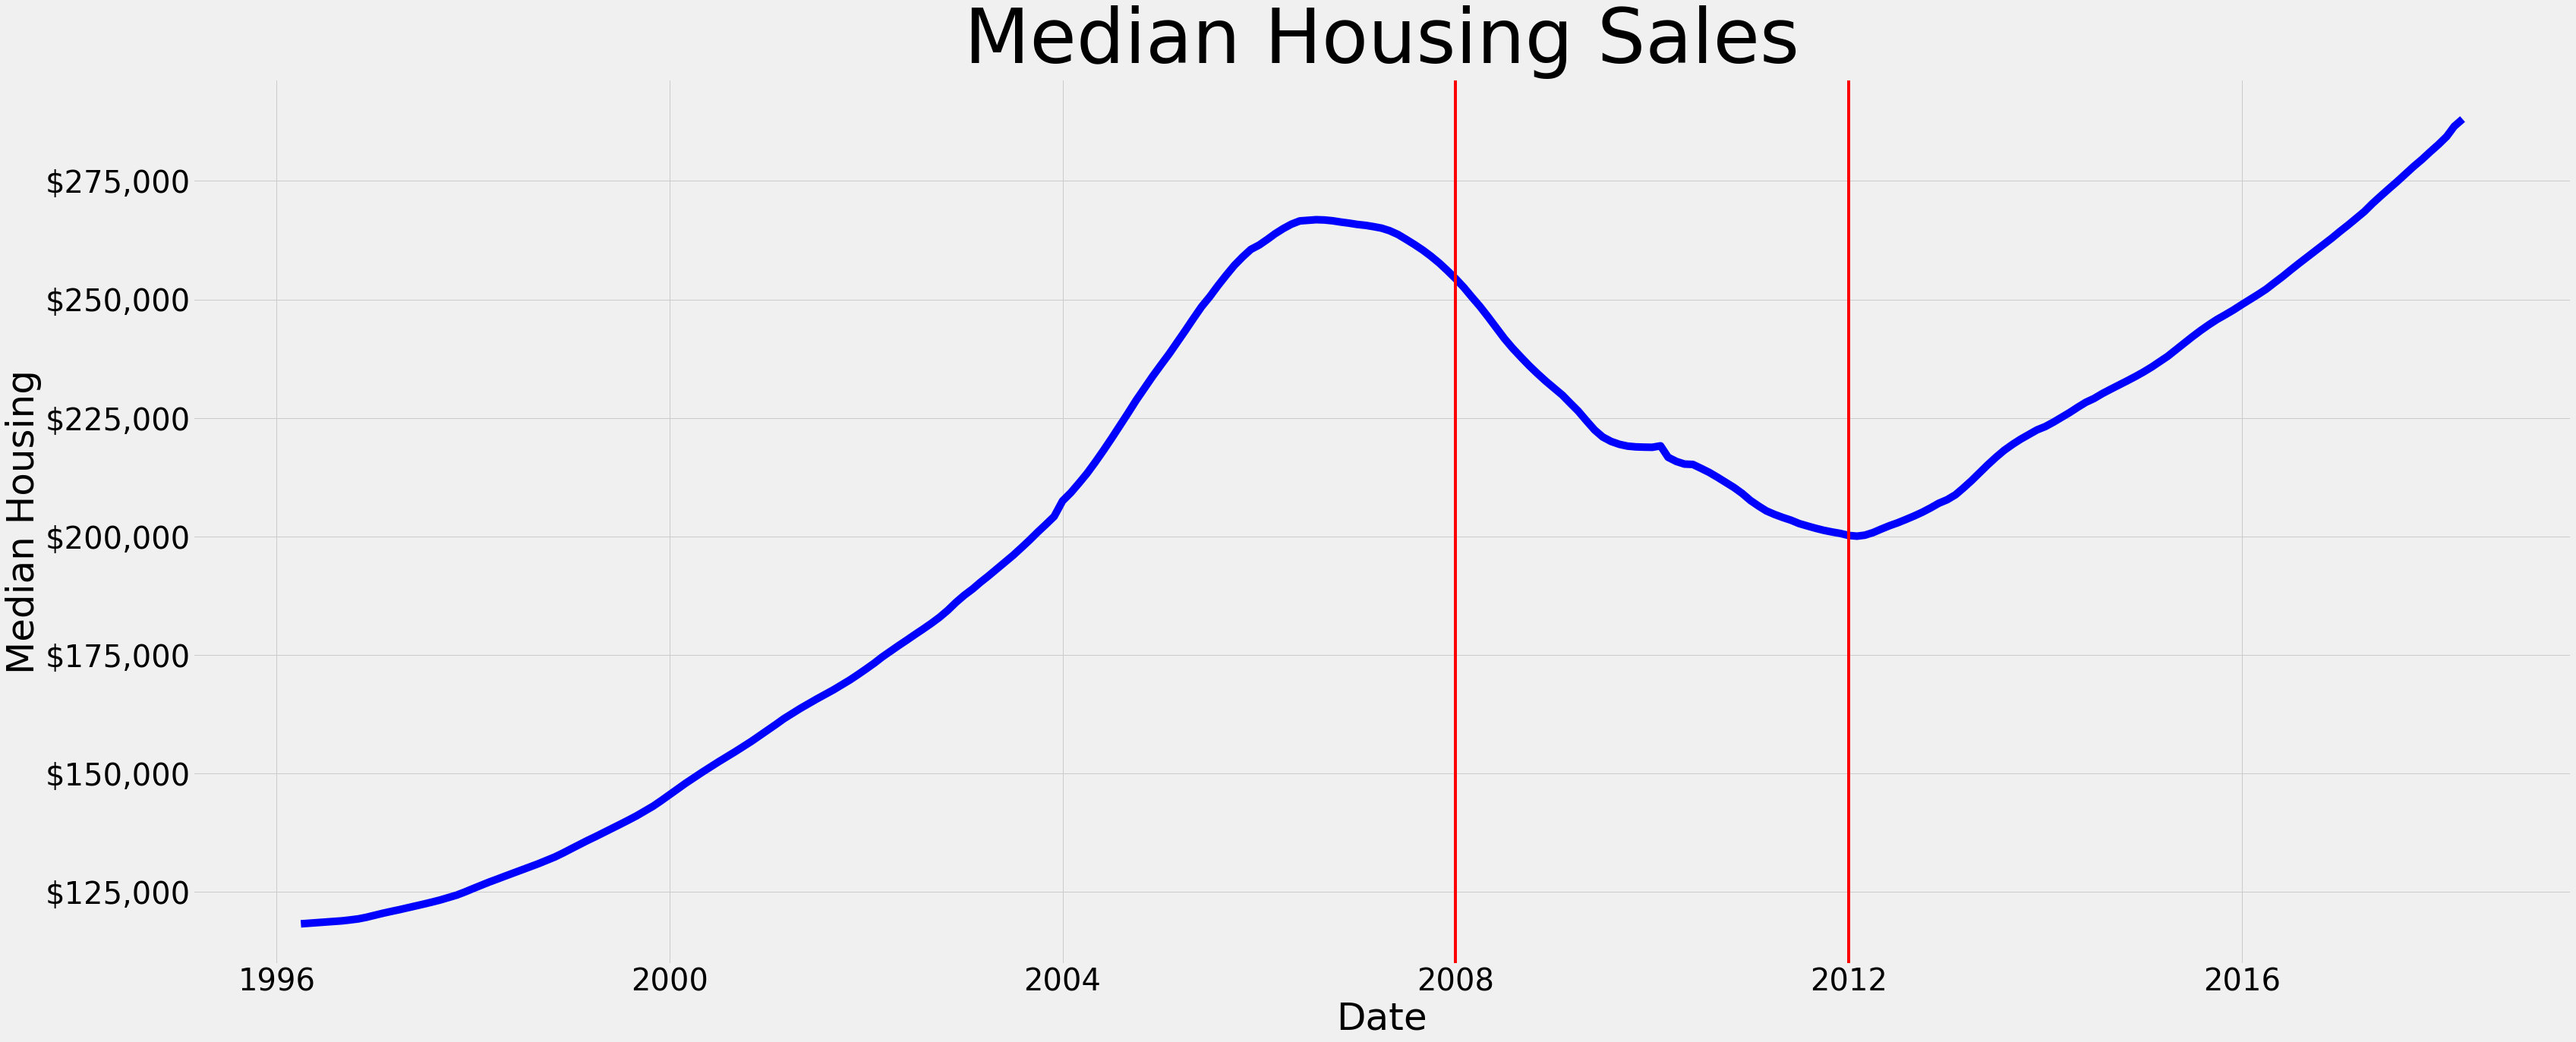

In [16]:
fig, ax = plt.subplots(figsize=(50, 20))

p = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='blue', linewidth=10);


p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01', color='red') #housing market crash begins
y2 = p.axvline('2012-01', color='red') #housing market crash ends
#ax.fill_between(y1, y2, color='yellow')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

## Analysis:
- Home Sales Values are on an upward trend, however there was a significant dip from aprox 2006 - 2012, before recovering and trending upward again.
- The dip was due to the US Housing Market Crash of 2008. (https://en.wikipedia.org/wiki/United_States_housing_bubble)

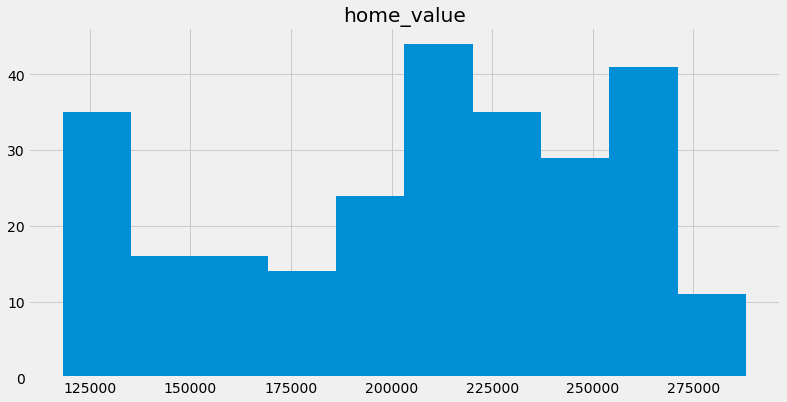

In [17]:
avg_home_df.hist(figsize = (12,6))
plt.show()

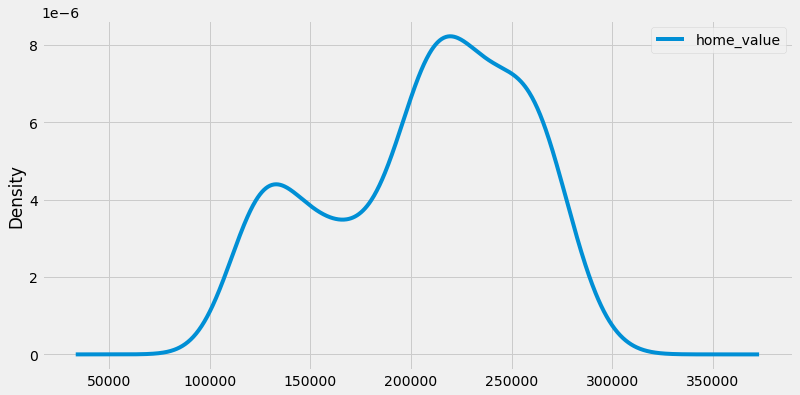

In [18]:
avg_home_df.plot(kind='kde', figsize = (12,6))
plt.show()

In [19]:
# Determine rolling statistics
#roll_mean = avg_home_df.rolling(window=12, center=False).mean()
#roll_std = avg_home_df.rolling(window=12, center=False).std()

## Dickey Fuller Test

In [20]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(avg_home_df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -1.89
p-value                         0.34
#Lags Used                      2.00
Number of Observations Used   262.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


# Feature Engineering

- I want to add additional features to the DataSet so that I can determine what data I want to analyze further and ultimately model.
- add: Region Mean, Region Growth, etc
- THE POINT IS TO IDENTIFY WHICH ZIPS ARE THE BEST PERFORMING SO I CAN NARROW DOWN THE DATA TO CAPTURE!!!!

In [21]:
new_df = ts.copy()

In [22]:
#making sure that all the data fields were changed to floats
new_df['2018-04'].dtype

dtype('float64')

In [23]:
new_df['mean'] = data_values.apply(lambda x: x.mean(), axis=1)

In [24]:
new_df.head()

RegionID ZipCode      City State              Metro CountyName  SizeRank  \
0     84654   60657   Chicago    IL            Chicago       Cook         1   
1     90668   75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982   77494      Katy    TX            Houston     Harris         3   
3     84616   60614   Chicago    IL            Chicago       Cook         4   
4     93144   79936   El Paso    TX            El Paso    El Paso         5   

     1996-04    1996-05    1996-06  ...      2017-08      2017-09  \
0 334,200.00 335,400.00 336,500.00  ... 1,007,500.00 1,007,800.00   
1 235,700.00 236,900.00 236,700.00  ...   310,000.00   312,500.00   
2 210,400.00 212,200.00 212,200.00  ...   320,600.00   320,200.00   
3 498,100.00 500,900.00 503,100.00  ... 1,287,700.00 1,287,400.00   
4  77,300.00  77,300.00  77,300.00  ...   119,400.00   120,000.00   

       2017-10      2017-11      2017-12      2018-01      2018-02  \
0 1,009,600.00 1,013,300.00 1,018,700.00 1,024,400.00 1,030,700.00   
1   314,100.00   315,000.00   316,600.00   318,100.00   319,600.00   
2   320,400.00   320,800.00   321,200.00   321,200.00   323,000.00   
3 1,291,500.00 1,296,600.00 1,299,000.00 1,302,700.00 1,306,400.00   
4   120,300.00   120,300.00   120,300.00   120,300.00   120,500.00   

       2018-03      2018-04       mean  
0 1,033,800.00 1,030,600.00 743,978.87  
1   321,100.00   321,800.00 219,655.85  
2   326,900.00   329,900.00 262,110.57  
3 1,308,500.00 1,307,000.00 974,139.25  
4   121,000.00   121,500.00 101,875.47  

[5 rows x 273 columns]

In [25]:
#new_df['min'] = data_values.apply(lambda x: x.min(), axis=1)
#new_df['max'] = data_values.apply(lambda x: x.max(), axis=1)
#new_df['delta'] = new_df.apply(lambda x: x['2018-04'] - x['min'], axis=1)
#new_df['delta_percent'] = new_df.apply(lambda x: x['delta'] / x['min'], axis=1)

# Analysis of New_df

## Top Zip Codes by Mean Value

In [26]:
new_df.sort_values('mean', ascending=False).head()

RegionID ZipCode      City State          Metro CountyName  SizeRank  \
272       61635   10021  New York    NY       New York   New York       273   
20        61625   10011  New York    NY       New York   New York        21   
508       61628   10014  New York    NY       New York   New York       509   
21        61703   10128  New York    NY       New York   New York        22   
10237     97518   94027  Atherton    CA  San Francisco  San Mateo     10238   

           1996-04      1996-05      1996-06  ...       2017-08       2017-09  \
272            nan          nan          nan  ... 18,703,500.00 18,605,300.00   
20             nan          nan          nan  ... 12,112,600.00 12,036,600.00   
508            nan          nan          nan  ...  9,958,800.00  9,828,700.00   
21    3,676,700.00 3,704,200.00 3,729,600.00  ...  7,422,400.00  7,417,600.00   
10237 1,179,200.00 1,184,300.00 1,189,700.00  ...  6,197,800.00  6,250,200.00   

            2017-10       2017-11       2017-12       2018-01       2018-02  \
272   18,569,400.00 18,428,800.00 18,307,100.00 18,365,900.00 18,530,400.00   
20    12,050,100.00 12,016,300.00 11,946,500.00 11,978,100.00 11,849,300.00   
508    9,631,000.00  9,515,800.00  9,492,800.00  9,524,900.00  9,373,400.00   
21     7,427,300.00  7,371,400.00  7,342,700.00  7,353,300.00  7,350,300.00   
10237  6,315,400.00  6,429,100.00  6,581,800.00  6,705,000.00  6,764,600.00   

            2018-03       2018-04          mean  
272   18,337,700.00 17,894,900.00 12,854,267.44  
20    11,563,000.00 11,478,300.00  7,755,843.75  
508    9,119,600.00  8,959,300.00  6,836,902.33  
21     7,363,000.00  7,386,600.00  5,085,435.85  
10237  6,788,400.00  6,796,500.00  3,487,129.06  

[5 rows x 273 columns]

## Analysis:
While this is a good metric to have, it doesn't tell me enough. Areas with high home values may have always had higher home values. I need to determine the value over time.

# Analysis DataFrame

<b> First, I will slice out the top quartile (75%) of mean home values. </b>

In [27]:
avg_home_df.describe()

home_value
count      265.00
mean   206,661.51
std     47,809.38
min    118,299.12
25%    168,653.36
50%    215,113.13
75%    245,934.66
max    288,039.94

<b>The top Quartile of avg US home values starts at 245,934. I will only be interested in Zip Codes that have a mean value of 246,000.</b>

In [28]:
new_df.describe()

RegionID  SizeRank      1996-04      1996-05      1996-06  \
count  14,723.00 14,723.00    13,684.00    13,684.00    13,684.00   
mean   81,075.01  7,362.00   118,299.12   118,419.04   118,537.42   
std    31,934.12  4,250.31    86,002.51    86,155.67    86,309.23   
min    58,196.00      1.00    11,300.00    11,500.00    11,600.00   
25%    67,174.50  3,681.50    68,800.00    68,900.00    69,100.00   
50%    78,007.00  7,362.00    99,500.00    99,500.00    99,700.00   
75%    90,920.50 11,042.50   143,200.00   143,300.00   143,225.00   
max   753,844.00 14,723.00 3,676,700.00 3,704,200.00 3,729,600.00   

           1996-07      1996-08      1996-09      1996-10      1996-11  ...  \
count    13,684.00    13,684.00    13,684.00    13,684.00    13,684.00  ...   
mean    118,653.07   118,780.25   118,927.53   119,120.52   119,345.35  ...   
std      86,467.95    86,650.94    86,872.08    87,151.85    87,479.81  ...   
min      11,800.00    11,800.00    12,000.00    12,100.00    12,200.00  ...   
25%      69,200.00    69,375.00    69,500.00    69,600.00    69,800.00  ...   
50%      99,700.00    99,800.00    99,900.00    99,950.00   100,100.00  ...   
75%     143,225.00   143,500.00   143,700.00   143,900.00   144,125.00  ...   
max   3,754,600.00 3,781,800.00 3,813,500.00 3,849,600.00 3,888,900.00  ...   

            2017-08       2017-09       2017-10       2017-11       2017-12  \
count     14,723.00     14,723.00     14,723.00     14,723.00     14,723.00   
mean     274,865.77    276,464.62    278,033.19    279,520.86    281,095.32   
std      361,467.76    362,756.27    364,460.95    365,600.33    367,045.39   
min       14,500.00     14,700.00     14,800.00     14,500.00     14,300.00   
25%      127,500.00    128,200.00    128,700.00    129,250.00    129,900.00   
50%      189,600.00    190,500.00    191,400.00    192,500.00    193,400.00   
75%      306,650.00    308,500.00    309,800.00    311,700.00    313,400.00   
max   18,703,500.00 18,605,300.00 18,569,400.00 18,428,800.00 18,307,100.00   

            2018-01       2018-02       2018-03       2018-04          mean  
count     14,723.00     14,723.00     14,723.00     14,723.00     14,723.00  
mean     282,657.06    284,368.69    286,511.38    288,039.94    205,653.02  
std      369,572.74    371,773.91    372,461.23    372,054.40    233,945.10  
min       14,100.00     13,900.00     13,800.00     13,800.00     18,660.20  
25%      130,600.00    131,050.00    131,950.00    132,400.00    102,711.70  
50%      194,100.00    195,000.00    196,700.00    198,100.00    150,634.72  
75%      315,100.00    316,850.00    318,850.00    321,100.00    235,686.04  
max   18,365,900.00 18,530,400.00 18,337,700.00 17,894,900.00 12,854,267.44  

[8 rows x 268 columns]

In [29]:
recent_df = new_df[new_df['mean'] >= 246000]

In [30]:
recent_df.describe()

RegionID  SizeRank      1996-04      1996-05      1996-06  \
count   3,440.00  3,440.00     3,354.00     3,354.00     3,354.00   
mean   82,309.50  6,091.64   214,679.25   214,849.64   215,019.29   
std    38,428.44  4,003.58   120,099.88   120,520.01   120,938.39   
min    58,197.00      1.00    67,100.00    68,100.00    69,100.00   
25%    62,038.75  2,681.75   155,225.00   155,300.00   155,225.00   
50%    76,465.50  5,675.50   184,300.00   184,650.00   184,850.00   
75%    96,596.25  9,182.25   235,475.00   235,600.00   235,900.00   
max   753,843.00 14,723.00 3,676,700.00 3,704,200.00 3,729,600.00   

           1996-07      1996-08      1996-09      1996-10      1996-11  ...  \
count     3,354.00     3,354.00     3,354.00     3,354.00     3,354.00  ...   
mean    215,185.15   215,381.66   215,626.48   215,975.07   216,403.25  ...   
std     121,369.76   121,844.71   122,395.30   123,046.12   123,781.12  ...   
min      70,200.00    71,300.00    72,500.00    73,700.00    74,900.00  ...   
25%     155,300.00   155,300.00   155,500.00   155,725.00   155,725.00  ...   
50%     185,000.00   185,000.00   184,850.00   184,900.00   185,150.00  ...   
75%     236,300.00   236,600.00   236,700.00   236,675.00   236,700.00  ...   
max   3,754,600.00 3,781,800.00 3,813,500.00 3,849,600.00 3,888,900.00  ...   

            2017-08       2017-09       2017-10       2017-11       2017-12  \
count      3,440.00      3,440.00      3,440.00      3,440.00      3,440.00   
mean     626,988.81    630,759.36    634,633.81    638,205.41    642,048.17   
std      617,179.05    618,617.61    621,000.37    622,131.96    623,870.19   
min      227,200.00    232,400.00    238,100.00    240,200.00    238,100.00   
25%      376,575.00    377,875.00    378,950.00    381,350.00    383,250.00   
50%      467,350.00    470,400.00    473,200.00    475,500.00    477,100.00   
75%      670,150.00    672,600.00    677,325.00    682,750.00    687,700.00   
max   18,703,500.00 18,605,300.00 18,569,400.00 18,428,800.00 18,307,100.00   

            2018-01       2018-02       2018-03       2018-04          mean  
count      3,440.00      3,440.00      3,440.00      3,440.00      3,440.00  
mean     646,140.61    650,391.72    655,182.27    658,300.58    445,705.83  
std      628,120.37    631,549.01    631,049.11    628,628.09    388,191.53  
min      235,500.00    234,100.00    234,200.00    233,800.00    246,156.98  
25%      385,375.00    387,700.00    390,025.00    391,875.00    286,609.43  
50%      478,600.00    481,800.00    486,350.00    489,200.00    353,714.53  
75%      691,775.00    696,425.00    698,275.00    699,850.00    480,623.77  
max   18,365,900.00 18,530,400.00 18,337,700.00 17,894,900.00 12,854,267.44  

[8 rows x 268 columns]

# Last 3 Years DataFrame

In [31]:
recent_data_2 = new_df.copy()

In [32]:
recent_data_2.iloc[:, 7:-41]

1996-04    1996-05    1996-06    1996-07    1996-08    1996-09  \
0     334,200.00 335,400.00 336,500.00 337,600.00 338,500.00 339,500.00   
1     235,700.00 236,900.00 236,700.00 235,400.00 233,300.00 230,600.00   
2     210,400.00 212,200.00 212,200.00 210,700.00 208,300.00 205,500.00   
3     498,100.00 500,900.00 503,100.00 504,600.00 505,500.00 505,700.00   
4      77,300.00  77,300.00  77,300.00  77,300.00  77,400.00  77,500.00   
...          ...        ...        ...        ...        ...        ...   
14718  94,600.00  94,300.00  94,000.00  93,700.00  93,400.00  93,200.00   
14719  92,700.00  92,500.00  92,400.00  92,200.00  92,100.00  91,900.00   
14720  57,100.00  57,300.00  57,500.00  57,700.00  58,000.00  58,200.00   
14721 191,100.00 192,400.00 193,700.00 195,000.00 196,300.00 197,700.00   
14722 176,400.00 176,300.00 176,100.00 176,000.00 175,900.00 175,800.00   

         1996-10    1996-11    1996-12    1997-01  ...      2014-03  \
0     340,400.00 341,300.00 342,600.00 344,400.00  ...   863,900.00   
1     227,300.00 223,400.00 219,600.00 215,800.00  ...   234,200.00   
2     202,500.00 199,800.00 198,300.00 197,300.00  ...   282,100.00   
3     505,300.00 504,200.00 503,600.00 503,400.00  ... 1,149,900.00   
4      77,600.00  77,700.00  77,700.00  77,800.00  ...   112,000.00   
...          ...        ...        ...        ...  ...          ...   
14718  93,000.00  92,900.00  92,700.00  92,600.00  ...   187,600.00   
14719  91,700.00  91,300.00  90,900.00  90,500.00  ...   180,000.00   
14720  58,400.00  58,700.00  59,100.00  59,500.00  ...   105,100.00   
14721 199,100.00 200,700.00 202,600.00 204,900.00  ...   528,900.00   
14722 175,800.00 176,000.00 176,200.00 176,500.00  ...   266,800.00   

           2014-04      2014-05      2014-06      2014-07      2014-08  \
0       872,900.00   883,300.00   889,500.00   892,800.00   893,600.00   
1       235,400.00   236,600.00   238,500.00   240,500.00   242,600.00   
2       284,200.00   286,000.00   288,300.00   290,700.00   293,300.00   
3     1,155,200.00 1,160,100.00 1,163,300.00 1,167,700.00 1,173,900.00   
4       112,500.00   112,700.00   113,100.00   113,900.00   114,400.00   
...            ...          ...          ...          ...          ...   
14718   187,300.00   187,300.00   188,100.00   189,600.00   190,800.00   
14719   180,000.00   181,400.00   181,900.00   182,200.00   183,300.00   
14720   105,200.00   104,800.00   104,200.00   104,200.00   104,700.00   
14721   532,000.00   535,200.00   538,500.00   538,300.00   543,700.00   
14722   269,200.00   271,500.00   273,800.00   276,200.00   278,600.00   

           2014-09      2014-10      2014-11      2014-12  
0       891,300.00   889,900.00   891,500.00   893,000.00  
1       244,700.00   246,300.00   247,600.00   249,600.00  
2       295,900.00   298,300.00   300,200.00   301,300.00  
3     1,175,100.00 1,173,500.00 1,175,500.00 1,178,500.00  
4       114,500.00   114,400.00   114,300.00   114,400.00  
...            ...          ...          ...          ...  
14718   189,800.00   188,500.00   189,400.00   191,100.00  
14719   185,800.00   187,700.00   187,500.00   184,900.00  
14720   104,600.00   104,600.00   104,800.00   104,800.00  
14721   551,400.00   552,800.00   547,100.00   537,900.00  
14722   280,400.00   282,000.00   283,600.00   285,900.00  

[14723 rows x 225 columns]

In [33]:
recent_data_2= recent_data_2.drop(recent_data_2.iloc[:, 7:-41], axis=1)

In [34]:
recent_data_2.head()

RegionID ZipCode      City State              Metro CountyName  SizeRank  \
0     84654   60657   Chicago    IL            Chicago       Cook         1   
1     90668   75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982   77494      Katy    TX            Houston     Harris         3   
3     84616   60614   Chicago    IL            Chicago       Cook         4   
4     93144   79936   El Paso    TX            El Paso    El Paso         5   

       2015-01      2015-02      2015-03  ...      2017-08      2017-09  \
0   893,000.00   895,000.00   901,200.00  ... 1,007,500.00 1,007,800.00   
1   251,400.00   253,000.00   255,200.00  ...   310,000.00   312,500.00   
2   301,700.00   302,400.00   303,600.00  ...   320,600.00   320,200.00   
3 1,176,400.00 1,174,600.00 1,178,500.00  ... 1,287,700.00 1,287,400.00   
4   114,700.00   115,000.00   115,000.00  ...   119,400.00   120,000.00   

       2017-10      2017-11      2017-12      2018-01      2018-02  \
0 1,009,600.00 1,013,300.00 1,018,700.00 1,024,400.00 1,030,700.00   
1   314,100.00   315,000.00   316,600.00   318,100.00   319,600.00   
2   320,400.00   320,800.00   321,200.00   321,200.00   323,000.00   
3 1,291,500.00 1,296,600.00 1,299,000.00 1,302,700.00 1,306,400.00   
4   120,300.00   120,300.00   120,300.00   120,300.00   120,500.00   

       2018-03      2018-04       mean  
0 1,033,800.00 1,030,600.00 743,978.87  
1   321,100.00   321,800.00 219,655.85  
2   326,900.00   329,900.00 262,110.57  
3 1,308,500.00 1,307,000.00 974,139.25  
4   121,000.00   121,500.00 101,875.47  

[5 rows x 48 columns]

In [35]:
recent_data_2.drop(columns = ['mean'], inplace=True)

In [36]:
recent_data_2.head(2)

RegionID ZipCode      City State              Metro CountyName  SizeRank  \
0     84654   60657   Chicago    IL            Chicago       Cook         1   
1     90668   75070  McKinney    TX  Dallas-Fort Worth     Collin         2   

     2015-01    2015-02    2015-03  ...      2017-07      2017-08  \
0 893,000.00 895,000.00 901,200.00  ... 1,005,500.00 1,007,500.00   
1 251,400.00 253,000.00 255,200.00  ...   308,000.00   310,000.00   

       2017-09      2017-10      2017-11      2017-12      2018-01  \
0 1,007,800.00 1,009,600.00 1,013,300.00 1,018,700.00 1,024,400.00   
1   312,500.00   314,100.00   315,000.00   316,600.00   318,100.00   

       2018-02      2018-03      2018-04  
0 1,030,700.00 1,033,800.00 1,030,600.00  
1   319,600.00   321,100.00   321,800.00  

[2 rows x 47 columns]

In [37]:
recent_data_2['mean_3yr'] = recent_data_2.iloc[:, 7:].apply(lambda x: x.mean(), axis=1)

In [38]:
recent_data_2['ROI'] = recent_data_2.iloc[:, 7:].apply(lambda x: x['2018-04'] - x['2015-01'], axis=1)
recent_data_2['ROI%'] = recent_data_2.iloc[:, 7:].apply(lambda x: x['ROI'] / x['2015-01'], axis=1)

In [39]:
recent_data_2.head()

RegionID ZipCode      City State              Metro CountyName  SizeRank  \
0     84654   60657   Chicago    IL            Chicago       Cook         1   
1     90668   75070  McKinney    TX  Dallas-Fort Worth     Collin         2   
2     91982   77494      Katy    TX            Houston     Harris         3   
3     84616   60614   Chicago    IL            Chicago       Cook         4   
4     93144   79936   El Paso    TX            El Paso    El Paso         5   

       2015-01      2015-02      2015-03  ...      2017-10      2017-11  \
0   893,000.00   895,000.00   901,200.00  ... 1,009,600.00 1,013,300.00   
1   251,400.00   253,000.00   255,200.00  ...   314,100.00   315,000.00   
2   301,700.00   302,400.00   303,600.00  ...   320,400.00   320,800.00   
3 1,176,400.00 1,174,600.00 1,178,500.00  ... 1,291,500.00 1,296,600.00   
4   114,700.00   115,000.00   115,000.00  ...   120,300.00   120,300.00   

       2017-12      2018-01      2018-02      2018-03      2018-04  \
0 1,018,700.00 1,024,400.00 1,030,700.00 1,033,800.00 1,030,600.00   
1   316,600.00   318,100.00   319,600.00   321,100.00   321,800.00   
2   321,200.00   321,200.00   323,000.00   326,900.00   329,900.00   
3 1,299,000.00 1,302,700.00 1,306,400.00 1,308,500.00 1,307,000.00   
4   120,300.00   120,300.00   120,500.00   121,000.00   121,500.00   

      mean_3yr        ROI  ROI%  
0   971,970.00 137,600.00  0.15  
1   291,002.50  70,400.00  0.28  
2   320,937.50  28,200.00  0.09  
3 1,249,762.50 130,600.00  0.11  
4   116,845.00   6,800.00  0.06  

[5 rows x 50 columns]

In [40]:
#recent_data_2[recent_data_2['City'] == 'Charleston']

In [41]:
recent_data_2.iloc[:, 8 :-4]

2015-02      2015-03      2015-04      2015-05      2015-06  \
0       895,000.00   901,200.00   909,400.00   915,000.00   916,700.00   
1       253,000.00   255,200.00   258,000.00   261,200.00   264,700.00   
2       302,400.00   303,600.00   306,200.00   309,100.00   311,900.00   
3     1,174,600.00 1,178,500.00 1,185,700.00 1,192,900.00 1,198,800.00   
4       115,000.00   115,000.00   115,200.00   115,600.00   115,900.00   
...            ...          ...          ...          ...          ...   
14718   193,300.00   193,400.00   192,000.00   191,200.00   190,900.00   
14719   181,900.00   182,300.00   184,400.00   186,300.00   188,300.00   
14720   104,400.00   104,400.00   105,000.00   105,900.00   106,800.00   
14721   517,500.00   538,300.00   552,700.00   545,800.00   536,100.00   
14722   288,300.00   289,100.00   291,000.00   293,300.00   295,200.00   

           2015-07      2015-08      2015-09      2015-10      2015-11  ...  \
0       917,700.00   919,800.00   925,800.00   937,100.00   948,200.00  ...   
1       268,400.00   271,400.00   273,600.00   275,200.00   276,400.00  ...   
2       314,100.00   316,300.00   319,000.00   322,000.00   324,300.00  ...   
3     1,200,400.00 1,198,900.00 1,200,200.00 1,207,400.00 1,218,600.00  ...   
4       115,600.00   115,400.00   115,400.00   115,500.00   115,800.00  ...   
...            ...          ...          ...          ...          ...  ...   
14718   190,900.00   191,100.00   191,900.00   191,400.00   190,700.00  ...   
14719   190,800.00   191,800.00   189,500.00   187,700.00   186,800.00  ...   
14720   107,500.00   107,700.00   107,800.00   108,300.00   108,600.00  ...   
14721   538,300.00   537,800.00   539,000.00   543,500.00   556,000.00  ...   
14722   296,900.00   298,400.00   299,200.00   299,500.00   301,200.00  ...   

           2017-06      2017-07      2017-08      2017-09      2017-10  \
0       999,100.00 1,005,500.00 1,007,500.00 1,007,800.00 1,009,600.00   
1       307,000.00   308,000.00   310,000.00   312,500.00   314,100.00   
2       320,900.00   321,000.00   320,600.00   320,200.00   320,400.00   
3     1,289,000.00 1,289,800.00 1,287,700.00 1,287,400.00 1,291,500.00   
4       118,900.00   119,100.00   119,400.00   120,000.00   120,300.00   
...            ...          ...          ...          ...          ...   
14718   215,400.00   216,800.00   217,700.00   218,600.00   218,500.00   
14719   197,300.00   202,100.00   208,400.00   212,200.00   215,200.00   
14720   121,100.00   121,800.00   122,800.00   124,600.00   126,700.00   
14721   647,300.00   662,800.00   671,200.00   682,400.00   695,600.00   
14722   331,300.00   333,800.00   336,400.00   339,700.00   343,800.00   

           2017-11      2017-12      2018-01      2018-02      2018-03  
0     1,013,300.00 1,018,700.00 1,024,400.00 1,030,700.00 1,033,800.00  
1       315,000.00   316,600.00   318,100.00   319,600.00   321,100.00  
2       320,800.00   321,200.00   321,200.00   323,000.00   326,900.00  
3     1,296,600.00 1,299,000.00 1,302,700.00 1,306,400.00 1,308,500.00  
4       120,300.00   120,300.00   120,300.00   120,500.00   121,000.00  
...            ...          ...          ...          ...          ...  
14718   218,100.00   216,400.00   213,100.00   209,800.00   209,200.00  
14719   214,300.00   213,100.00   213,700.00   218,300.00   222,700.00  
14720   128,800.00   130,600.00   131,700.00   132,500.00   133,000.00  
14721   695,500.00   694,700.00   706,400.00   705,300.00   681,500.00  
14722   346,800.00   348,900.00   350,400.00   353,000.00   356,000.00  

[14723 rows x 38 columns]

In [42]:
recent_data_2= recent_data_2.drop(recent_data_2.iloc[:, 8:-4], axis=1)

In [43]:
recent_data_2 = recent_data_2[recent_data_2['2018-04'] <= 500000]

### searching for the best ROI percentage over the last 3 years with a current (april 2018) value of 500,000 or less

In [44]:
recent_data_2.sort_values('2018-04', ascending=False).head(100)

RegionID ZipCode              City State  \
6041     399553   18902        Buckingham    PA   
2275      91655   77006           Houston    TX   
2053      96843   92373          Redlands    CA   
6126      61889   10603        Greenburgh    NY   
293       96468   91710             Chino    CA   
10668     67452   22947           Keswick    VA   
3312      67230   22312         Lincolnia    VA   
5986      72550   33331            Weston    FL   
7130      60557   07044            Verona    NJ   
3661      96473   91722            Covina    CA   
4741      91201   76034       Colleyville    TX   
1204      97274   93446       Paso Robles    CA   
10235     61829   10516       Philipstown    NY   
14644     95417   87540              Lamy    NM   
3426      67227   22309      Mount Vernon    VA   
8248      71526   31411   Skidaway Island    GA   
10330     98887   96750        Kealakekua    HI   
6262     100234   99516         Anchorage    AK   
4962      62105   11419          New York    NY   
6408      93586   80908      Black Forest    CO   
10631     98401   95722      Meadow Vista    CA   
6286      62168   11581     Valley Stream    NY   
1438      99133   97219          Portland    OR   
14690     98404   95728           Truckee    CA   
13819     98185   95421          Cazadero    CA   
9313      62156   11565          Malverne    NY   
3621      67233   22315         Franconia    VA   
5315      58671   02171            Quincy    MA   
614       97075   92882            Corona    CA   
5613      58433   01581       Westborough    MA   
3544      62194   11710          Bellmore    NY   
1466      71047   30328     Sandy Springs    GA   
6515      96136   90304         Inglewood    CA   
1380      58489   01801            Woburn    MA   
8466      61952   10970         Mount Ivy    NY   
1926      71056   30338          Dunwoody    GA   
6690      62213   11733          Setauket    NY   
3717      72523   33304   Fort Lauderdale    FL   
2411      97739   94531           Antioch    CA   
7467      96201   90670  Santa Fe Springs    CA   
11653     61914   10913        Orangetown    NY   
5239      79030   48168        Northville    MI   
5884      61981   11010   Franklin Square    NY   
7191      66669   20855           Derwood    MD   
2512      98379   95688         Vacaville    CA   
3781      99597   98146            Burien    WA   
9090      62219   11740        Huntington    NY   
3710      93267   80138            Parker    CO   
4427      96495   91752          Eastvale    CA   
2341      93244   80112        Centennial    CO   
6002      87137   66221     Overland Park    KS   
6226      60579   07070        Rutherford    NJ   
423       62014   11203          New York    NY   
1921      58642   02128            Boston    MA   
6653      93443   80517        Estes Park    CO   
5551      58533   01887        Wilmington    MA   
10067     99009   97002            Aurora    OR   
8038      60525   07009       Cedar Grove    NJ   
4258      96480   91733    South El Monte    CA   
7238      79113   48301  Bloomfield Hills    MI   
2635      69774   28211         Charlotte    NC   
13332     84429   60184             Wayne    IL   
183       96546   91911       Chula Vista    CA   
3287      66248   20155       Gainesville    VA   
1870      84453   60302          Oak Park    IL   
4132      67166   22152       Springfield    VA   
3165      94458   84095      South Jordan    UT   
6184      98298   95602            Auburn    CA   
8489      62132   11518     East Rockaway    NY   
4416      58581   02026            Dedham    MA   
1570      84292   60025          Glenview    IL   
4458      96887   92508         Riverside    CA   
11981     97281   93453           Simmler    CA   
8274      67754   23510           Norfolk    VA   
9801      66810   21163         Woodstock    MD   
5914      62236   11762   Massapequa Park    NY   
3451      96633   92083             Vista    CA   
12554     58550   01922      

In [45]:
recent_data_3 = recent_data_2[recent_data_2['ROI%'] >= 0.5]

In [46]:
recent_data_3.drop(columns=['RegionID'], inplace=True)

## Target Zips

In [47]:
target_zips = recent_data_3.sort_values('2018-04', ascending=False).head(15)
target_zips.sort_values('ROI', ascending=False)

ZipCode               City State                           Metro  \
4678    29403         Charleston    SC                      Charleston   
3781    98146             Burien    WA                         Seattle   
11899   95570           Trinidad    CA                          Eureka   
11136   37046      College Grove    TN                       Nashville   
5021    98043  Mountlake Terrace    WA                         Seattle   
4733    98178   Bryn Mawr-Skyway    WA                         Seattle   
6515    90304          Inglewood    CA  Los Angeles-Long Beach-Anaheim   
1921    02128             Boston    MA                          Boston   
4860    02121             Boston    MA                          Boston   
13123   95918      Browns Valley    CA                       Yuba City   
319     07087         Union City    NJ                        New York   
10589   98359             Olalla    WA                       Bremerton   
10638   80102            Bennett    CO                          Denver   
11320   89704        Carson City    NV                     Carson City   
4655    84105     Salt Lake City    UT                  Salt Lake City   

        CountyName  SizeRank    2015-01    2018-04   mean_3yr        ROI  ROI%  
4678    Charleston      4679 261,400.00 462,700.00 343,962.50 201,300.00  0.77  
3781          King      3782 292,100.00 491,100.00 391,625.00 199,000.00  0.68  
11899     Humboldt     11900 282,300.00 480,600.00 375,162.50 198,300.00  0.70  
11136   Williamson     11137 268,900.00 459,800.00 350,822.50 190,900.00  0.71  
5021     Snohomish      5022 287,800.00 474,700.00 366,512.50 186,900.00  0.65  
4733          King      4734 270,300.00 455,100.00 365,355.00 184,800.00  0.68  
6515   Los Angeles      6516 326,100.00 494,300.00 404,962.50 168,200.00  0.52  
1921       Suffolk      1922 323,700.00 489,900.00 398,212.50 166,200.00  0.51  
4860       Suffolk      4861 290,100.00 452,700.00 376,882.50 162,600.00  0.56  
13123         Yuba     13124 312,500.00 473,600.00 377,520.00 161,100.00  0.52  
319         Hudson       320 289,500.00 448,900.00 336,135.00 159,400.00  0.55  
10589       Kitsap     10590 285,700.00 444,600.00 370,297.50 158,900.00  0.56  
10638        Adams     10639 276,500.00 434,500.00 350,020.00 158,000.00  0.57  
11320  Carson City     11321 275,300.00 425,300.00 338,797.50 150,000.00  0.54  
4655     Salt Lake      4656 292,800.00 441,300.00 366,010.00 148,500.00  0.51

# Target Zips

## Turning Target Zips into Time Series

<b>These are the top ten zips with the following criteria:
- Avg Home Value aprox 500,000 as of most recent data point (April 2018)
- Ranked by ROI total amount over the previous 3 years</b>

In [48]:
data = ts[ts['ZipCode'] == '29403']
melted_data = melt_data(data)
zip_29403_ts = melted_data
zip_29403_ts.head()

value
time                
1996-04-01 61,500.00
1996-05-01 61,800.00
1996-06-01 62,100.00
1996-07-01 62,400.00
1996-08-01 62,700.00

In [49]:
zip_29403_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


In [50]:
data = ts[ts['ZipCode'] == '98146']
melted_data = melt_data(data)
zip_98146_ts = melted_data

In [51]:
data = ts[ts['ZipCode'] == '95570']
melted_data = melt_data(data)
zip_95570_ts = melted_data

In [52]:
data = ts[ts['ZipCode'] == '37046']
melted_data = melt_data(data)
zip_37046_ts = melted_data

In [53]:
data = ts[ts['ZipCode'] == '98043']
melted_data = melt_data(data)
zip_98043_ts = melted_data

In [54]:
data = ts[ts['ZipCode'] == '98178']
melted_data = melt_data(data)
zip_98178_ts = melted_data

In [55]:
data = ts[ts['ZipCode'] == '90304']
melted_data = melt_data(data)
zip_90304_ts = melted_data

In [56]:
data = ts[ts['ZipCode'] == '02128']
melted_data = melt_data(data)
zip_02128_ts = melted_data

In [57]:
data = ts[ts['ZipCode'] == '02121']
melted_data = melt_data(data)
zip_02121_ts = melted_data_ts = melted_data

In [58]:
data = ts[ts['ZipCode'] == '95918']
melted_data = melt_data(data)
zip_95918_ts = melted_data

In [59]:
data = ts[ts['ZipCode'] == '07087']
melted_data = melt_data(data)
zip_07087_ts = melted_data

In [60]:
data = ts[ts['ZipCode'] == '90304']
melted_data = melt_data(data)
zip_90304_ts = melted_data
zip_90304_ts.head()

value
time                 
1996-04-01 136,600.00
1996-05-01 136,100.00
1996-06-01 135,600.00
1996-07-01 135,000.00
1996-08-01 134,400.00

In [61]:
zip_07087_ts

value
time                 
1996-04-01 127,300.00
1996-05-01 127,000.00
1996-06-01 126,700.00
1996-07-01 126,400.00
1996-08-01 126,100.00
1996-09-01 125,900.00
1996-10-01 125,800.00
1996-11-01 125,800.00
1996-12-01 126,000.00
1997-01-01 126,400.00
1997-02-01 126,700.00
1997-03-01 127,000.00
1997-04-01 127,400.00
1997-05-01 127,700.00
1997-06-01 128,100.00
1997-07-01 128,500.00
1997-08-01 128,900.00
1997-09-01 129,500.00
1997-10-01 130,100.00
1997-11-01 130,800.00
1997-12-01 131,700.00
1998-01-01 132,800.00
1998-02-01 133,800.00
1998-03-01 134,800.00
1998-04-01 135,700.00
1998-05-01 136,700.00
1998-06-01 137,500.00
1998-07-01 138,300.00
1998-08-01 139,100.00
1998-09-01 139,900.00
1998-10-01 140,700.00
1998-11-01 141,600.00
1998-12-01 142,500.00
1999-01-01 143,600.00
1999-02-01 144,800.00
1999-03-01 145,800.00
1999-04-01 146,800.00
1999-05-01 147,800.00
1999-06-01 148,800.00
1999-07-01 149,800.00
1999-08-01 150,800.00
1999-09-01 151,900.00
1999-10-01 153,100.00
1999-11-01 154,500.00
1999-12-01 156,000.00
2000-01-01 157,700.00
2000-02-01 159,500.00
2000-03-01 161,100.00
2000-04-01 162,800.00
2000-05-01 164,500.00
2000-06-01 166,200.00
2000-07-01 167,800.00
2000-08-01 169,500.00
2000-09-01 171,200.00
2000-10-01 173,100.00
2000-11-01 175,100.00
2000-12-01 177,200.00
2001-01-01 179,400.00
2001-02-01 181,700.00
2001-03-01 183,900.00
2001-04-01 186,100.00
2001-05-01 188,200.00
2001-06-01 190,300.00
2001-07-01 192,200.00
2001-08-01 194,200.00
2001-09-01 196,300.00
2001-10-01 198,500.00
2001-11-01 200,900.00
2001-12-01 203,400.00
2002-01-01 206,100.00
2002-02-01 208,800.00
2002-03-01 211,500.00
2002-04-01 214,200.00
2002-05-01 216,800.00
2002-06-01 219,300.00
2002-07-01 221,700.00
2002-08-01 224,100.00
2002-09-01 226,600.00
2002-10-01 229,300.00
2002-11-01 232,200.00
2002-12-01 235,400.00
2003-01-01 238,700.00
2003-02-01 242,300.00
2003-03-01 246,100.00
2003-04-01 250,100.00
2003-05-01 254,400.00
2003-06-01 259,100.00
2003-07-01 264,000.00
2003-08-01 269,000.00
2003-09-01 273,900.00
2003-10-01 278,700.00
2003-11-01 283,100.00
2003-12-01 287,400.00
2004-01-01 291,700.00
2004-02-01 296,100.00
2004-03-01 300,700.00
2004-04-01 305,500.00
2004-05-01 310,400.00
2004-06-01 315,800.00
2004-07-01 321,900.00
2004-08-01 328,400.00
2004-09-01 334,900.00
2004-10-01 341,300.00
2004-11-01 347,700.00
2004-12-01 354,500.00
2005-01-01 361,100.00
2005-02-01 366,600.00
2005-03-01 371,400.00
2005-04-01 376,200.00
2005-05-01 381,200.00
2005-06-01 386,900.00
2005-07-01 393,300.00
2005-08-01 400,000.00
2005-09-01 406,600.00
2005-10-01 412,600.00
2005-11-01 417,900.00
2005-12-01 423,100.00
2006-01-01 428,500.00
2006-02-01 433,900.00
2006-03-01 440,100.00
2006-04-01 447,200.00
2006-05-01 454,100.00
2006-06-01 460,100.00
2006-07-01 465,300.00
2006-08-01 469,400.00
2006-09-01 473,100.00
2006-10-01 476,500.00
2006-11-01 479,400.00
2006-12-01 482,200.00
2007-01-01 484,900.00
2007-02-01 486,500.00
2007-03-01 487,700.00
2007-04-01 489,700.00
2007-05-01 491,600.00
2007-06-01 493,000.00
2007-07-01 494,500.00
2007-08-01 495,600.00
2007-09-01 496,400.00
2007-10-01 496,700.00
2007-11-01 495,300.00
2007-12-01 492,800.00
2008-01-01 489,900.00
2008-02-01 485,300.00
2008-03-01 480,400.00
2008-04-01 475,700.00
2008-05-01 470,500.00
2008-06-01 464,100.00
2008-07-01 456,300.00
2008-08-01 446,500.00
2008-09-01 436,400.00
2008-10-01 427,000.00
2008-11-01 416,800.00
2008-12-01 406,300.00
2009-01-01 396,300.00
2009-02-01 386,000.00
2009-03-01 375,900.00
2009-04-01 366,300.00
2009-05-01 356,200.00
2009-06-01 345,600.00
2009-07-01 335,900.00
2009-08-01 327,500.00
2009-09-01 320,800.00
2009-10-01 315,800.00
2009-11-01 311,500.00
2009-12-01 306,400.00
2010-01-01 300,000.00
2010-02-01 298,600.00
2010-03-01 299,600.00
2010-04-01 296,100.00
2010-05-01 289,200.00
2010-06-01 284,800.00
2010-07-01 280,600.00
2010-08-01 275,200.00
2010-09-01 269,200.00
2010-10-01 264,700.00
2010-11-01 261,900.00
2010-12-01 259,500.00
2011-01-01 256,700.00
2011-02-01 253,900.00
2011-03-01 252,500.00
2011-04-01 2

## Visual = Comparing Top 10 Zips to National Average

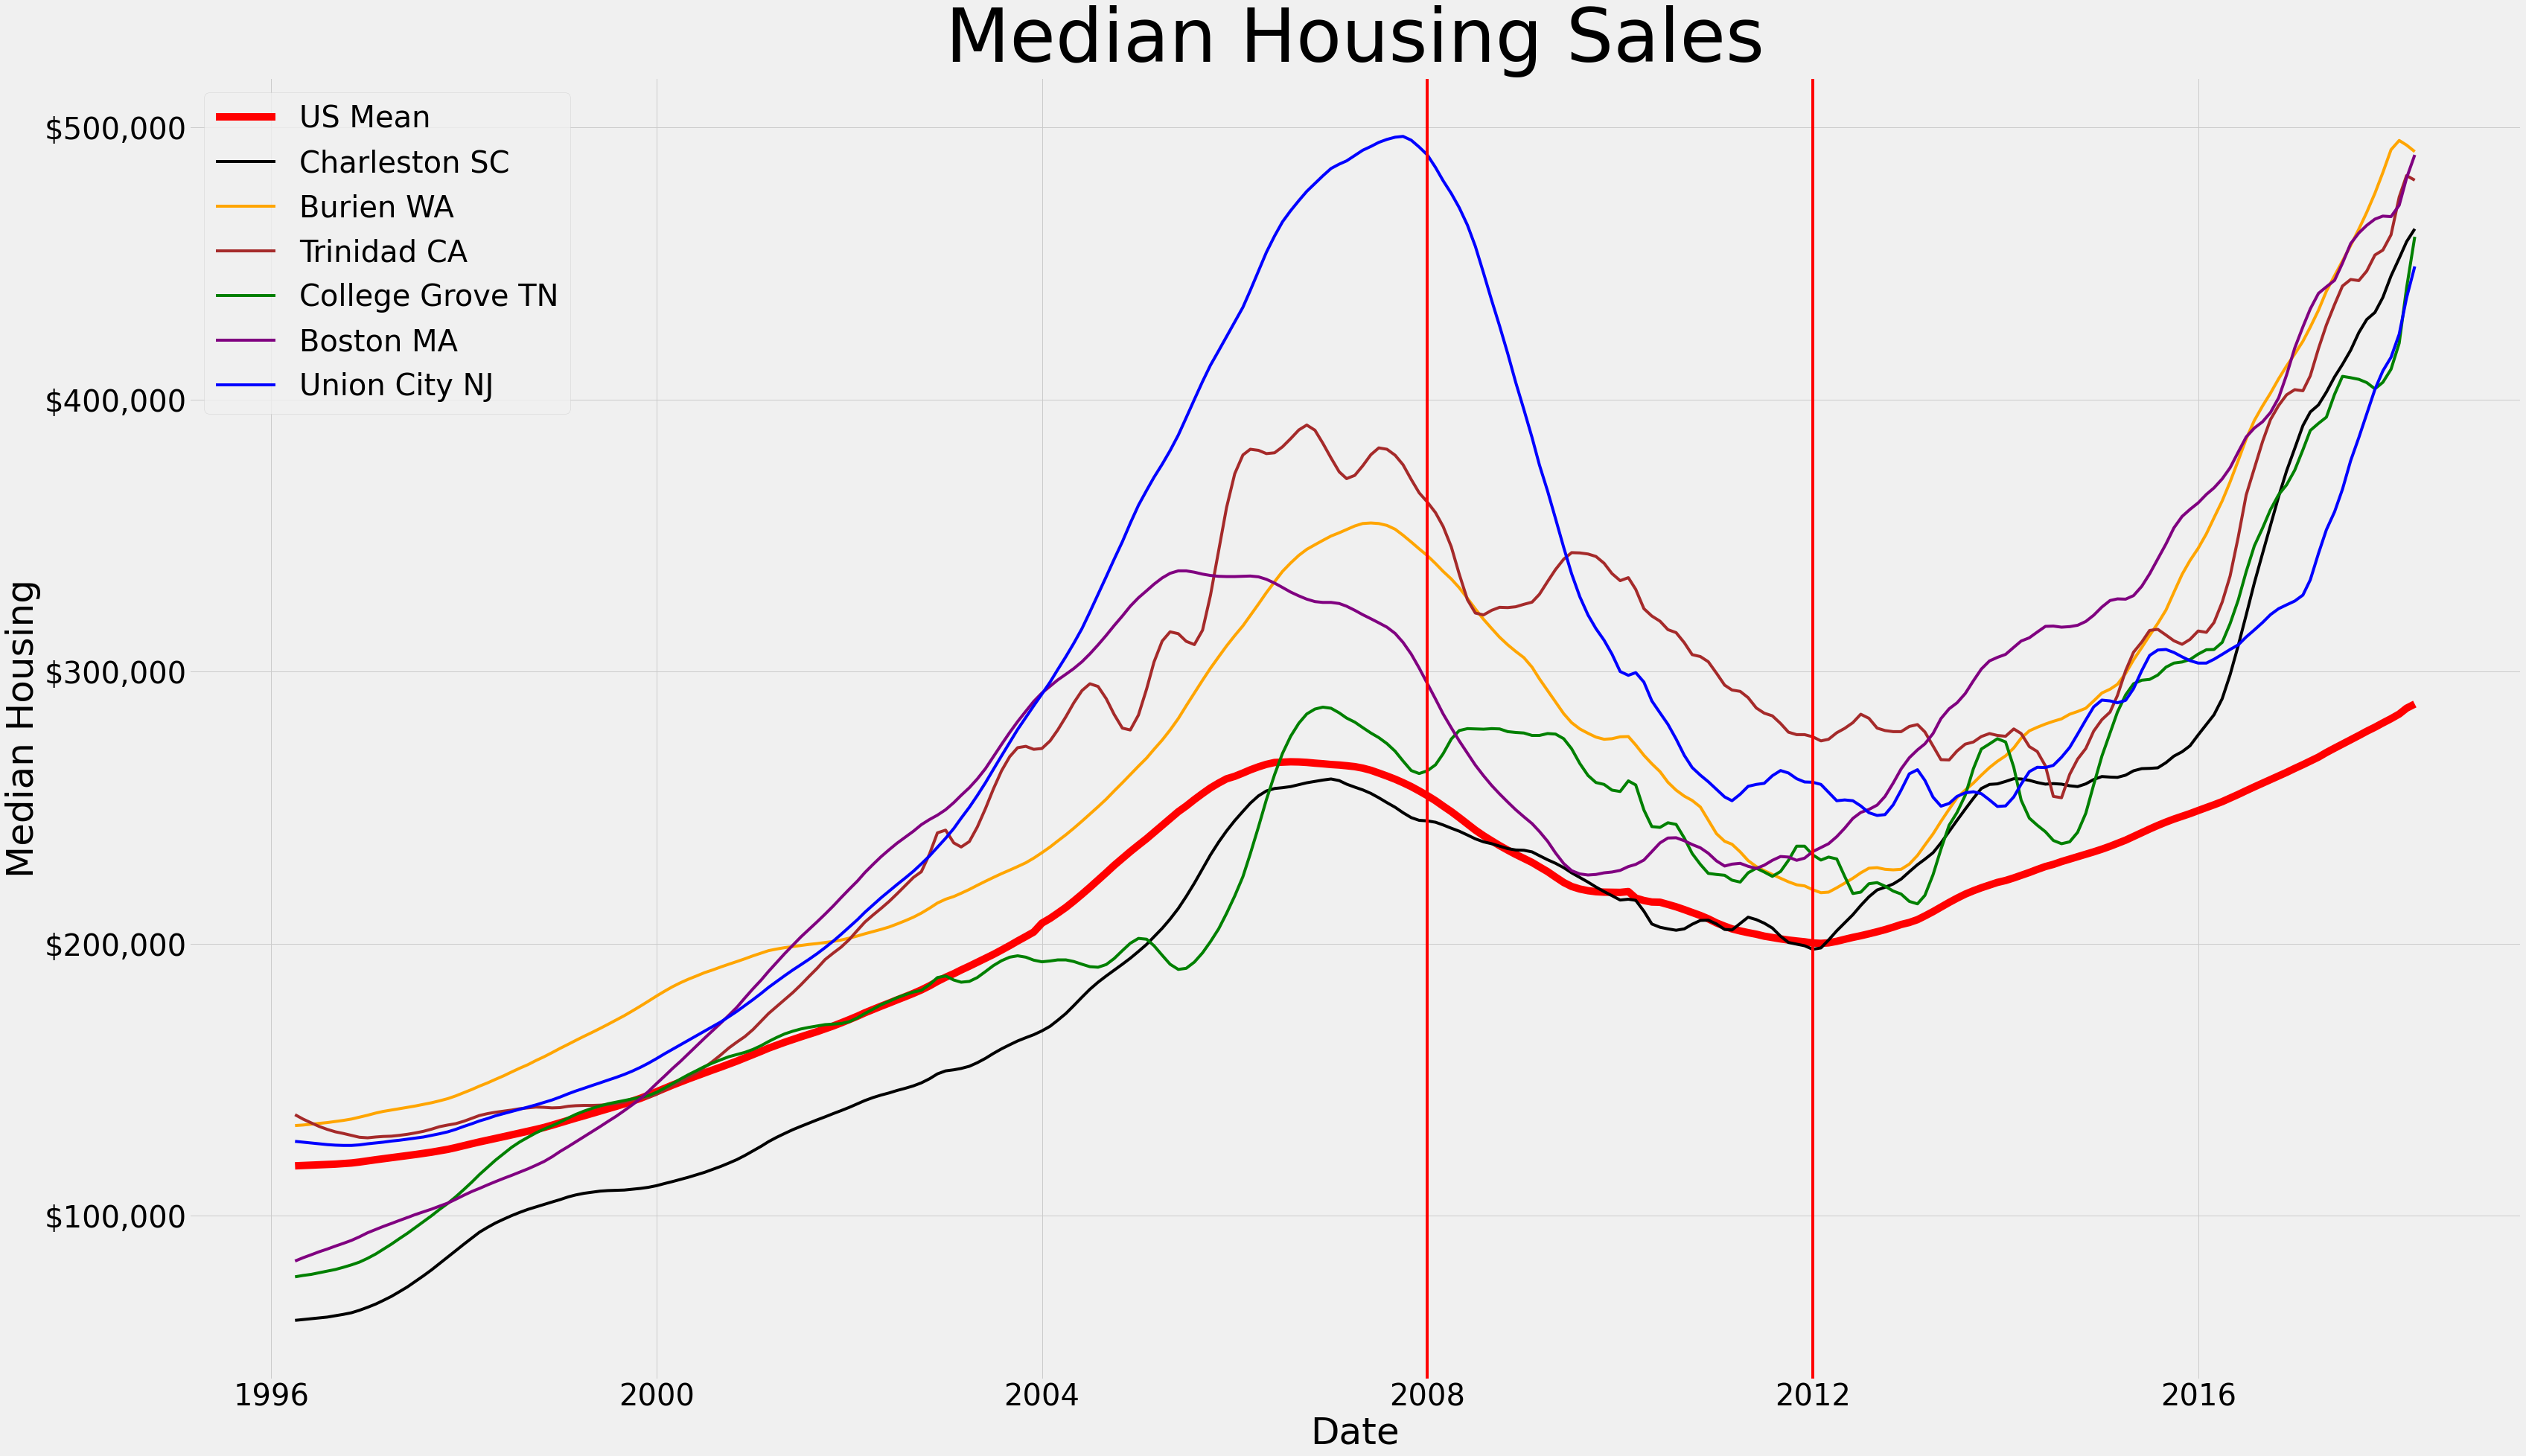

In [62]:
fig, ax = plt.subplots(figsize=(50, 30))

p = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean', linewidth = 10);
p = sns.lineplot(data=zip_29403_ts, x='time', y='value', color='black', label='Charleston SC');
p = sns.lineplot(data=zip_98146_ts, x='time', y='value', color='orange', label='Burien WA');
p = sns.lineplot(data=zip_95570_ts, x='time', y='value', color='brown', label='Trinidad CA');
p = sns.lineplot(data=zip_37046_ts, x='time', y='value', color='green', label='College Grove TN');
#line6 = sns.lineplot(data=zip_98043_ts, x='time', y='value', color='purple', label='98043');
#line7 = sns.lineplot(data=zip_98178_ts, x='time', y='value', color='yellow', label='98178');
#line8 = sns.lineplot(data=zip_90304_ts, x='time', y='value', color='green', label='90304');
p = sns.lineplot(data=zip_02128_ts, x='time', y='value', color='purple', label='Boston MA');
#line10 = sns.lineplot(data=zip_02121_ts, x='time', y='value', color='blue', label='02121');
p = sns.lineplot(data=zip_07087_ts, x='time', y='value', color='blue', label='Union City NJ');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01', color='red') #housing market crash begins
y2 = p.axvline('2012-01', color='red') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.legend(fontsize=40)

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Analysis: 
- These Zips have avg home values that are increasing at a much higher rate than the national average.

# Modeling Target Zips

In [63]:
def sarimax_param_search(ts):
    
    # Setting up parameter combinations.
    p = d = q = (0, 1)

    pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
    pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
    combo, value = (None, None)
    for pdq_combo in pdq:
        for pdqs_combo in pdqs:
            model = SARIMAX(
                ts, 
                order=pdq_combo,
                seasonal_order=pdqs_combo,
                enforce_stationarity=False,
                enforce_invertibility=False
                )
            output = model.fit()

            if value is None or output.aic < value:
                combo, value = ((pdq_combo, pdqs_combo), output.aic)
                print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
    return(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

##### 29403: Charleston SC: CLAUDE METHOD

In [64]:
#plt.style.use('ggplot')

In [65]:
#test_data = zip_29403_ts

In [66]:
#test_data_sqrt = np.sqrt(test_data)

In [67]:
#test_data.plot(figsize=(12,6));

In [68]:
# Setting up parameter combinations.
#p = d = q = (0, 1)

#pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
#pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

# Iterate and try models.
#combo, value = (None, None)
#for pdq_combo in pdq:
#for pdqs_combo in pdqs:
#       model = SARIMAX(
#            test_data, 
#            order=pdq_combo,
#            seasonal_order=pdqs_combo,
#            enforce_stationarity=False,
#            enforce_invertibility=False
#            )
#        output = model.fit()
#
#        if value is None or output.aic < value:
#            combo, value = ((pdq_combo, pdqs_combo), output.aic)
#            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
#                
#            
#print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

In [69]:
#combo

In [70]:
#combo = zip_29403_advanced_results

In [71]:
#combo = (((2, 2, 2), (0, 2, 2, 12)))

In [72]:
# Manually split data.
#SPLIT = int(test_data.shape[0]*0.8)
#train, test = test_data[:SPLIT], test_data[SPLIT:]

# Model
#sarima_model_best = SARIMAX(
#    train,
#    order=combo[0],
#    seasonal_order=combo[1],
#    enforce_stationarity=False,
#    enforce_invertibility=False).fit()
#sarima_model_best.summary()

In [73]:
#pred = sarima_model_best.get_prediction(
#    start=test.index.min(), 
#    end=test.index.max(), 
#    dynamic=False)

#fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(train, label='Training Data')
#ax.plot(test, label='Test Data')
#ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#ax.legend()
#fig.tight_layout()

In [74]:
#pred.conf_int().head()

In [75]:
#fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(test, label='Test Data', color='tab:green')
#ax.plot(pred.predicted_mean, 
#        label='Mean Prediction',
#        color='tab:blue', 
#        ls=':')
#ax.plot(pred.conf_int()['lower value'], 
#        label='Lower Confidence Interval', 
#        color='tab:red')
#ax.plot(pred.conf_int()['upper value'], 
#        label='Upper Confidence Interval', 
#        color='tab:red')
#ax.legend()
#fig.tight_layout()

##### Getting larger PDQs to test

In [76]:
#combo

In [77]:
#charleston_combo = combo

In [78]:
#zip_98146_sqrt = np.sqrt(zip_98146_ts)
#zip_95570_sqrt = np.sqrt(zip_95570_ts)
#zip_37046_sqrt = np.sqrt(zip_37046_ts)
#zip_98043_sqrt = np.sqrt(zip_98043_ts)
#zip_02128_sqrt = np.sqrt(zip_02128_ts)
#zip_07087_sqrt = np.sqrt(zip_07087_ts)


In [79]:
#sarimax_param_search(zip_98146_sqrt)

## Modeling Avg Home DF

In [80]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            avg_home_df, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7227.7079129085505
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6742.951906598109
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 5572.264748163526


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5320.30250225246
SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5042.996371372234


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 1), (0, 1, 1, 12)) AIC: 4970.644728102759


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 4522.908195768892
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4134.045772924266
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 4079.4273237624784
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 3879.8996217683434


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 3720.365361558163


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 3563.3895854949087
SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 3498.392163450404


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 3496.161500302899


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((1, 1, 0), (1, 1, 1, 12)) AIC: 3496.0018089190553


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 3444.7138121821463


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3400.4512923783514

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [81]:
sarimax_param_search(zip_29403_ts)

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7253.568859465069
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6771.834476474499
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 5942.061862134093


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5667.810479507031
SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5546.4152128871465


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (1, 1, 1, 12)) AIC: 5526.763986319401


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((0, 0, 1), (1, 1, 0, 12)) AIC: 5482.36205715134


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 4955.2236391574825
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4651.7172154905975
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4454.088584688814


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (1, 1, 1, 12)) AIC: 4452.9184408061565
SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4338.332564113003


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4157.82831739853


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (1, 1, 1, 12)) AIC: 4150.537726655904


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 4104.528840658375
SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 4020.9270770090047


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 4009.9263870131626


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((1, 1, 0), (1, 1, 1, 12)) AIC: 4003.7092880512832
SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 4002.2509711258244


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 3907.6753052990994


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3900.908480207153


'\n********************\nOptimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))'

In [82]:
combo

((1, 1, 1), (1, 1, 1, 12))

In [83]:
temp_ts = avg_home_df

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

In [84]:
# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         home_value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1424.317
Date:                            Wed, 18 May 2022   AIC                           2858.633
Time:                                    14:55:11   BIC                           2875.075
Sample:                                04-01-1996   HQIC                          2865.288
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9799      0.019     51.102      0.000       0.942       1.017
ma.L1         -0.2176      0.038     -5.774      0.000      -0.291      -0.144
ar.S.L12       0.0863      0.029      2.960      0.003       0.029       0.143
ma.S.L12      -0.9988      4.487     -0.223      0.824      -9.793       7.796
sigma2      8.937e+04   3.99e+05      0.224      0.823   -6.93e+05    8.72e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.43   Jarque-Bera (JB):              4692.26
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):              24.77   Skew:                            -2.06
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
avg_home_model = sarima_model

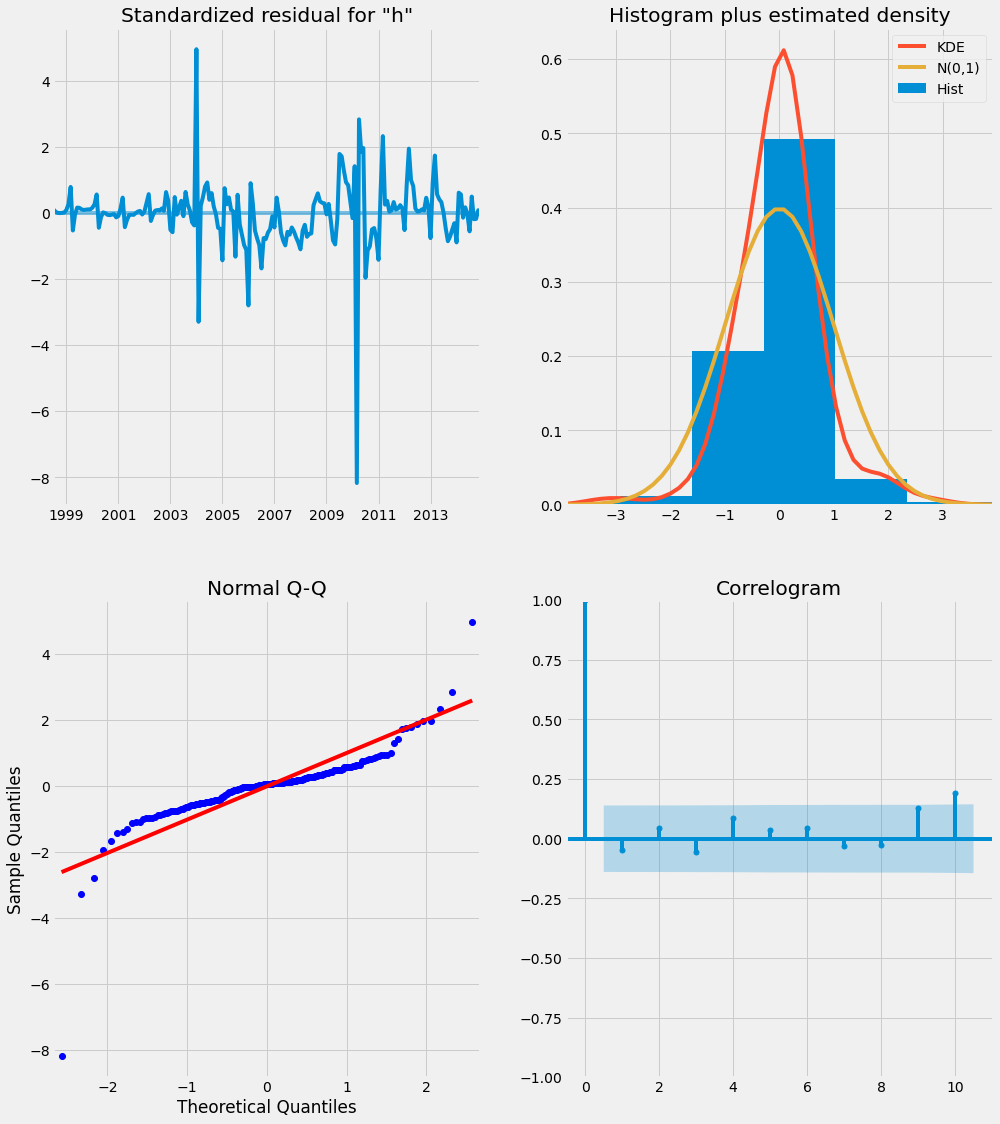

In [86]:
avg_home_model.plot_diagnostics(figsize=(15, 18))
plt.show()

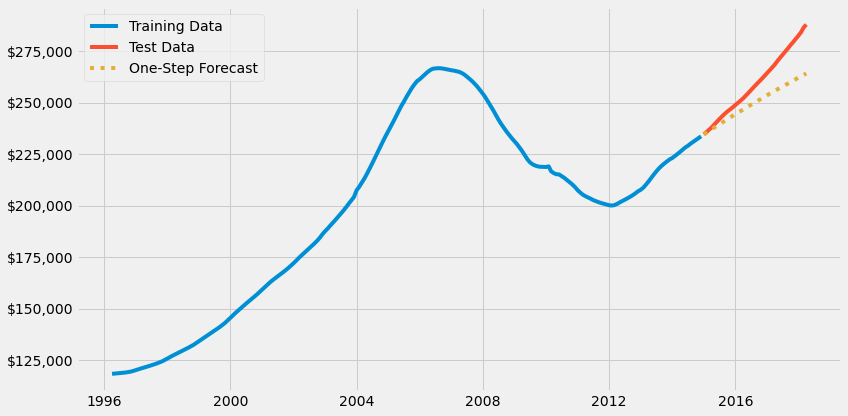

In [87]:
 pred = avg_home_model.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [88]:
avg_home_df.head()

home_value
time                  
1996-04-01  118,299.12
1996-05-01  118,419.04
1996-06-01  118,537.42
1996-07-01  118,653.07
1996-08-01  118,780.25

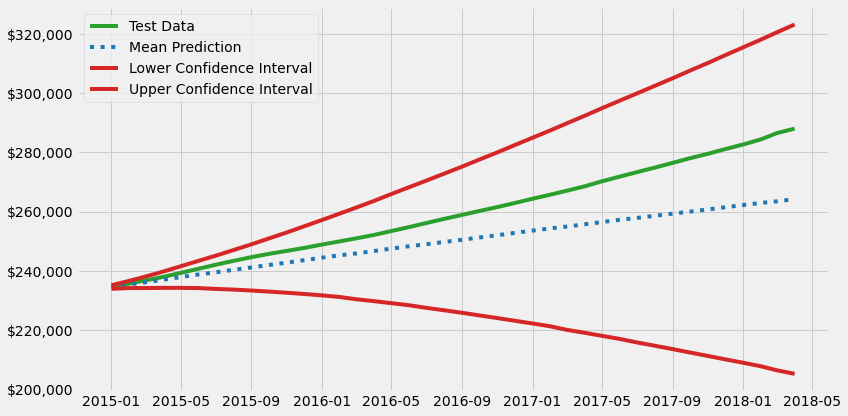

In [89]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower home_value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper home_value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

In [90]:
forecast = pred.predicted_mean
actual = test['home_value']

In [91]:
mse = ((forecast - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 137351398.17


In [92]:
# Running model again with FULL data

sarima_model = SARIMAX(
    avg_home_df,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         home_value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1695.226
Date:                            Wed, 18 May 2022   AIC                           3400.451
Time:                                    14:55:13   BIC                           3417.813
Sample:                                04-01-1996   HQIC                          3407.448
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9824      0.014     68.316      0.000       0.954       1.011
ma.L1         -0.2273      0.033     -6.825      0.000      -0.293      -0.162
ar.S.L12       0.0788      0.016      5.062      0.000       0.048       0.109
ma.S.L12      -0.9992      0.031    -31.849      0.000      -1.061      -0.938
sigma2      7.882e+04   3.99e-07   1.98e+11      0.000    7.88e+04    7.88e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.47   Jarque-Bera (JB):              6742.73
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -2.14
Prob(H) (two-sided):                  0.05   Kurtosis:                        28.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.98e+26. Standard errors may be unstable.
"""

In [93]:
avg_home_model_full = sarima_model

In [94]:
avg_home_df['2018-04']

home_value
time                  
2018-04-01  288,039.94

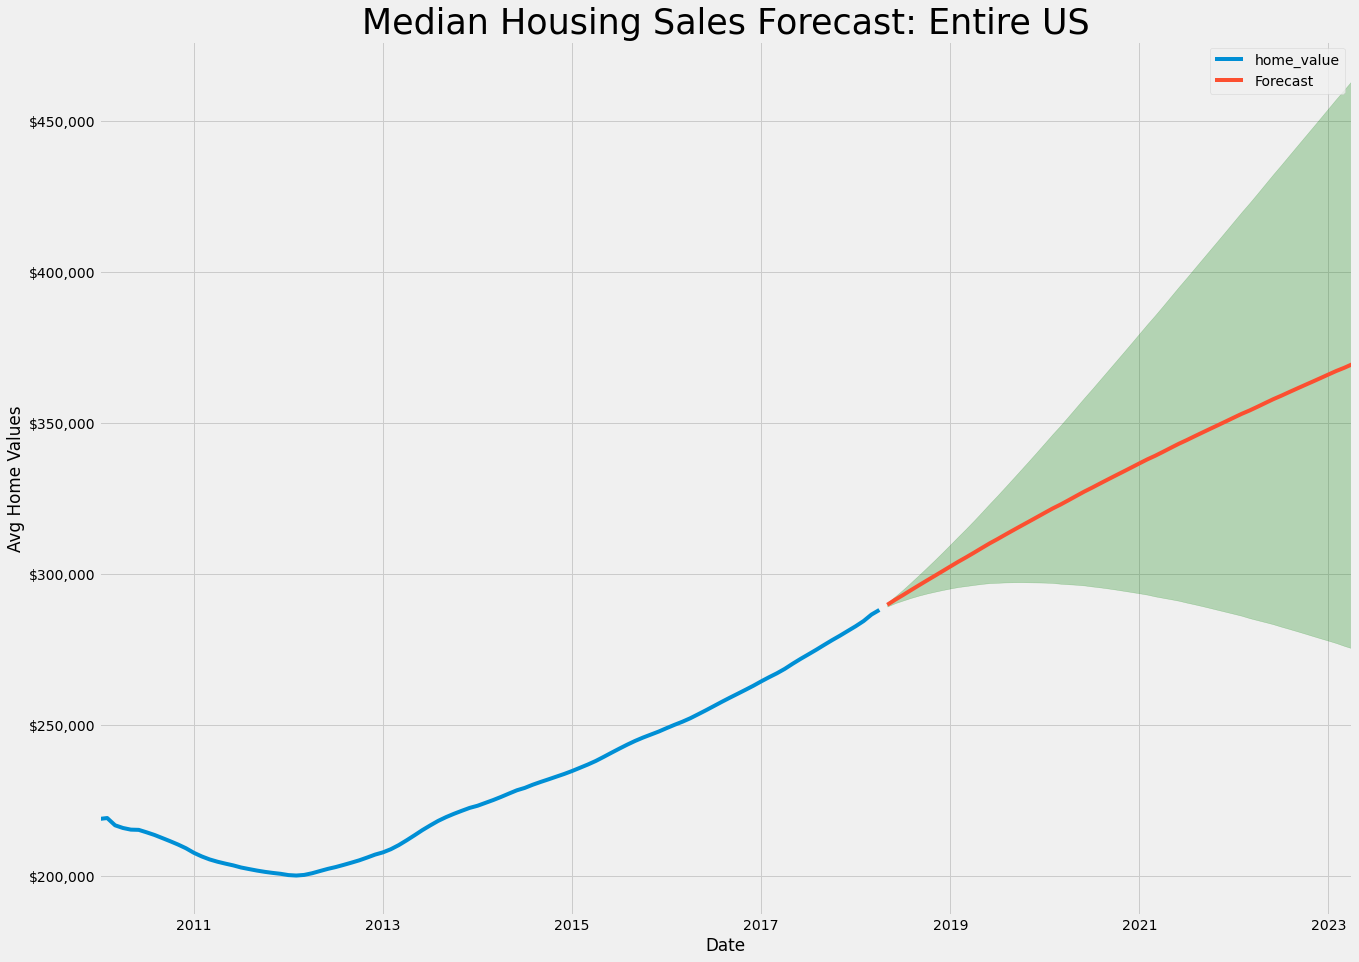

In [95]:
# Get forecast 5 yrs ahead in future (60 steps)
prediction = avg_home_model_full.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = avg_home_df['2010-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: Entire US", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

## 29403: Charleston SC

In [96]:
zip_29403_ts.head()

value
time                
1996-04-01 61,500.00
1996-05-01 61,800.00
1996-06-01 62,100.00
1996-07-01 62,400.00
1996-08-01 62,700.00

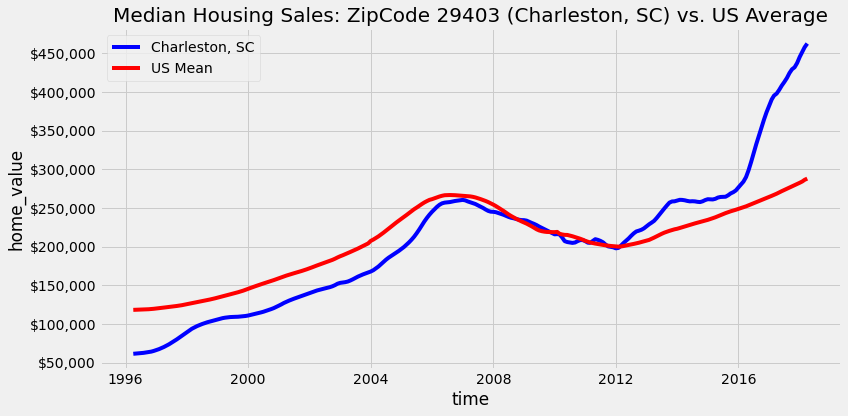

In [97]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_29403_ts, label='Charleston, SC', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 29403 (Charleston, SC) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [98]:
#zip_29403_y = zip_29403_ts.resample('Y').mean()

In [99]:
zip_29403_sqrt = np.sqrt(zip_29403_ts)
zip_29403_sqrt.head()

value
time             
1996-04-01 247.99
1996-05-01 248.60
1996-06-01 249.20
1996-07-01 249.80
1996-08-01 250.40

In [100]:
zip_29403_ts.head()

value
time                
1996-04-01 61,500.00
1996-05-01 61,800.00
1996-06-01 62,100.00
1996-07-01 62,400.00
1996-08-01 62,700.00

In [101]:
#zip_29403_ts = blah
#zip_29403_ts.head()

In [102]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_29403_sqrt, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 3981.047220795841
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 3511.2794138182862
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 2452.226106744308


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 2336.096084603634
SARIMA Combos: ((0, 0, 0), (1, 0, 1, 12)) AIC: 2236.5885998158074
SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 2193.3422284238754


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (1, 1, 1, 12)) AIC: 2186.3174627361996


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((0, 0, 1), (0, 1, 0, 12)) AIC: 2103.291498895697
SARIMA Combos: ((0, 0, 1), (0, 1, 1, 12)) AIC: 1839.9221405022736


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 1306.1876049790408
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 1175.5247040277372
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 1120.6884490864409


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 0, 0, 12)) AIC: 979.477216536021
SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 876.8150532055397
SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 841.9122627344249


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 0, 1), (0, 0, 1, 12)) AIC: 831.6303837540222


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((1, 1, 0), (0, 0, 0, 12)) AIC: 651.8159670449755
SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 623.6320984957787


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 0, 1, 12)) AIC: 617.0525473108514


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 0, 0, 12)) AIC: 565.6282806152326
SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 536.265818116498


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 0, 1, 12)) AIC: 532.1449291734841


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'



********************
Optimal SARIMA order: ((1, 1, 1), (1, 0, 1, 12))


In [103]:
combo

((1, 1, 1), (1, 0, 1, 12))

In [104]:
# charleston(sqrt) param search results: SARIMA Combos: ((2, 2, 2), (1, 0, 2, 12)) AIC: 478.1602589266394
#charleston_optimal_order = ((2, 2, 2), (1, 0, 2, 12))

In [105]:
#combo = ((2, 2, 2), (1, 0, 2, 12))

In [106]:
# DO NOT DELETE! Results from doing a more advanced peramter search
#zip_29403_advanced_results = combo, value
#zip_29403_advanced_results
#combo = (((2, 2, 2), (0, 2, 2, 12)))

In [107]:
temp_ts = zip_29403_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

In [108]:
test.head()

value
time                 
2013-12-01 258,700.00
2014-01-01 259,600.00
2014-02-01 260,600.00
2014-03-01 260,500.00
2014-04-01 260,000.00

In [109]:
#best_model = SARIMAX(train, order=(2, 2, 2), seasonal_order=(0, 2, 2, 12)).fit(dis=-1)
#print(best_model.summary())

In [110]:
# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1525.679
Date:                            Wed, 18 May 2022   AIC                           3061.358
Time:                                    14:55:25   BIC                           3077.774
Sample:                                04-01-1996   HQIC                          3068.003
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9533      0.025     37.578      0.000       0.904       1.003
ma.L1          0.6082      0.036     17.103      0.000       0.539       0.678
ar.S.L12       0.2228      0.064      3.466      0.001       0.097       0.349
ma.S.L12      -0.7822      0.058    -13.527      0.000      -0.896      -0.669
sigma2      2.747e+05   1.86e+04     14.775      0.000    2.38e+05    3.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               209.64
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               8.35   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
zip_29403_model_1 = sarima_model

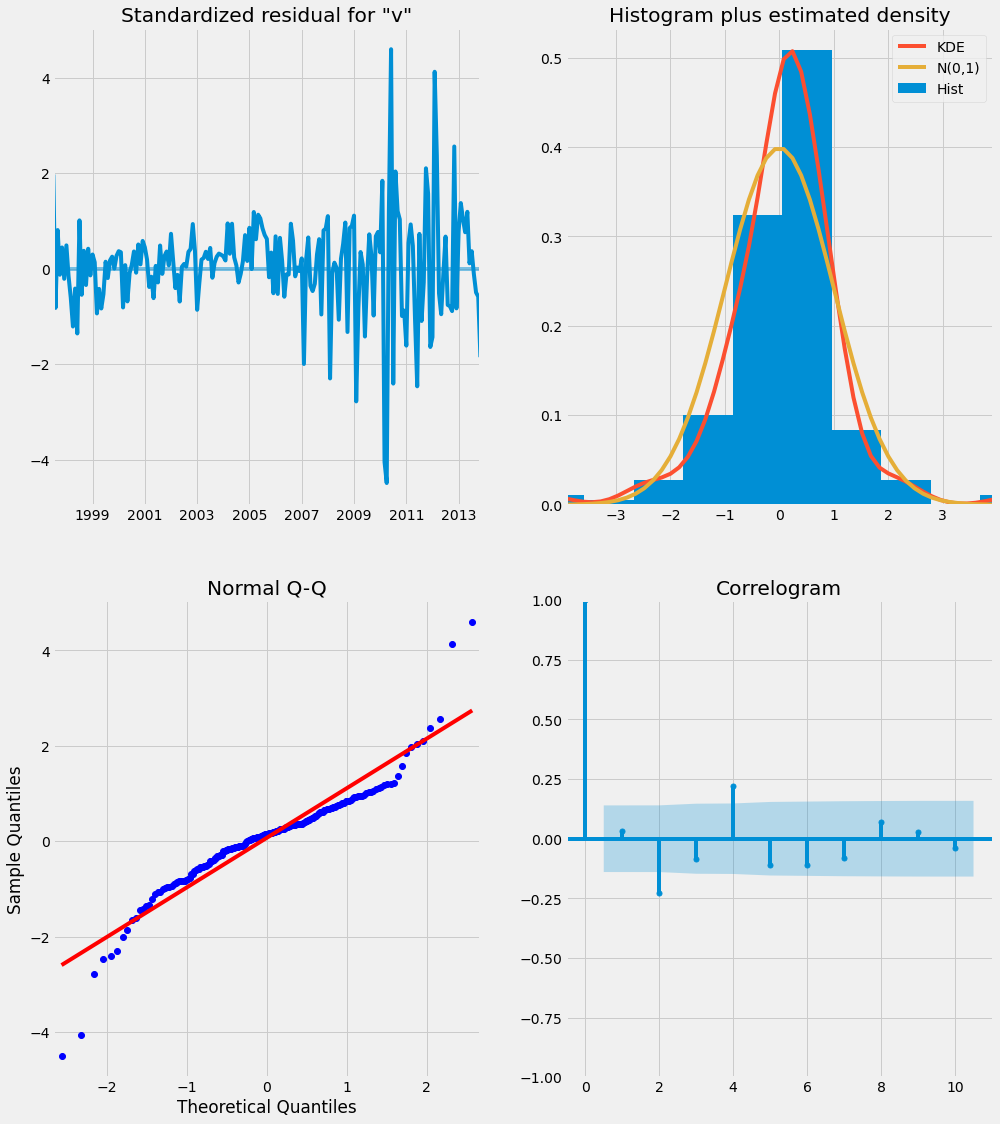

In [112]:
zip_29403_model_1.plot_diagnostics(figsize=(15, 18))
plt.show()

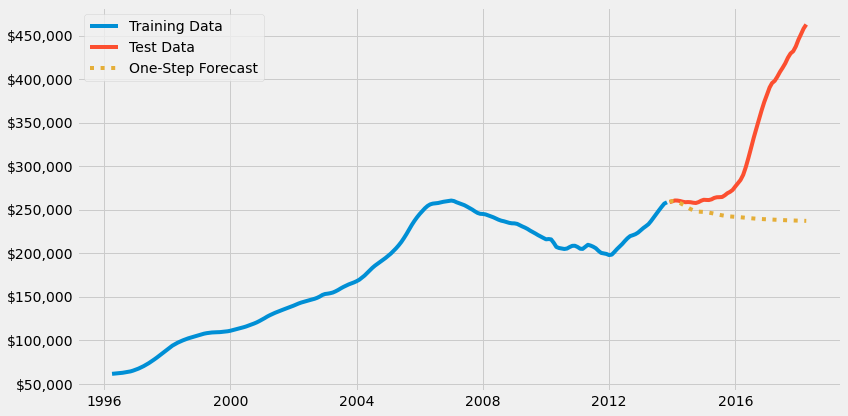

In [113]:
pred = zip_29403_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [114]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 12157265475.8
The Root Mean Squared Error is 110259.99


In [115]:
#pred = zip_29403_model_1.get_prediction(
#    start=test.index.min(), 
#    end=test.index.max(), 
#    dynamic=False)

In [116]:
#transforming predictions back to base scale (removing square root transformation)
#forecast = pred.predicted_mean**2
#forecast.head()

In [117]:
#train = train**2
#test = test**2

In [118]:
#pred

In [119]:
#prediction.conf_int()

In [120]:
#fig, ax = plt.subplots(figsize=(12, 6))
#ax.plot(test, label='Test Data', color='tab:green')
#ax.plot(pred.predicted_mean, 
#        label='Mean Prediction',
#        color='tab:blue', 
#        ls=':')
#ax.plot(pred.conf_int()['lower value'], 
#        label='Lower Confidence Interval', 
#        color='tab:red')
#ax.plot(pred.conf_int()['upper value'], 
#        label='Upper Confidence Interval', 
#        color='tab:red')
#ax.yaxis.set_major_formatter(tick) 
#ax.legend()
#fig.tight_layout()

In [121]:
#mse = ((forecast - actual) ** 2).mean()
#print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [122]:
#mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
#mape

In [123]:
#rmse = np.mean((forecast - actual)**2)**.5
#rmse

#### Prediction

In [124]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_29403_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1996.646
Date:                            Wed, 18 May 2022   AIC                           4003.292
Time:                                    14:55:25   BIC                           4020.899
Sample:                                04-01-1996   HQIC                          4010.378
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9455      0.017     55.376      0.000       0.912       0.979
ma.L1          0.7059      0.032     21.885      0.000       0.643       0.769
ar.S.L12      -0.1109      0.199     -0.557      0.578      -0.501       0.280
ma.S.L12      -0.1846      0.196     -0.943      0.346      -0.568       0.199
sigma2      5.057e+05    2.6e+04     19.488      0.000    4.55e+05    5.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):               238.50
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):              21.65   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [125]:
zip_29403_model_full = sarima_model

In [126]:
#pred_conf = pred_conf**2

In [127]:
#pred_conf

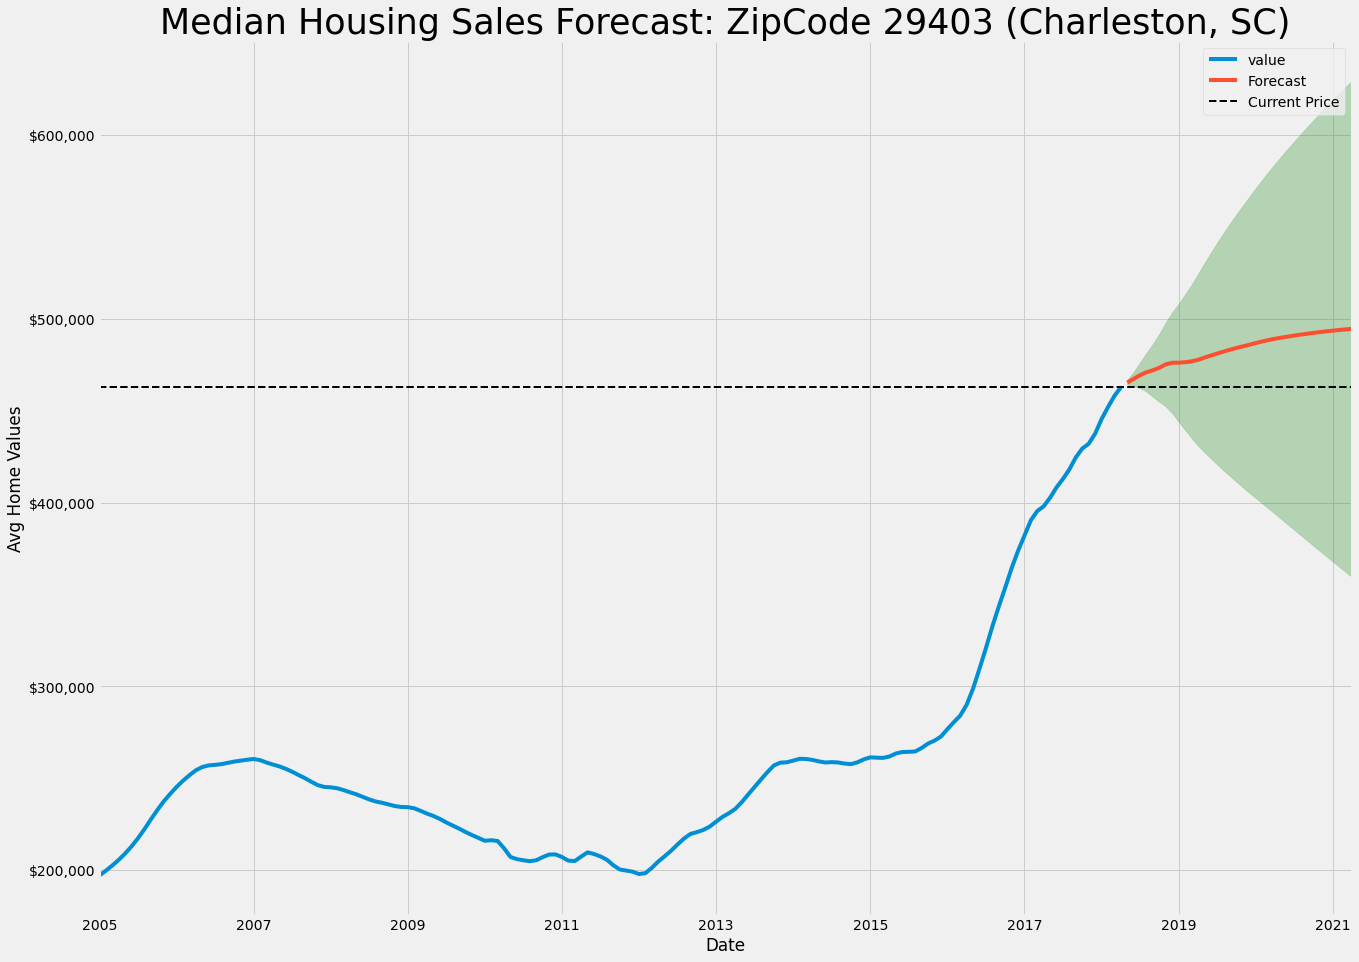

In [293]:
#Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_29403_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

ax = zip_29403_ts['2005-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(463000, ls='--', color='black', linewidth=(2), label='Current Price')
#ax.axhline(363000, ls='--', color='black', linewidth=(2))


ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 29403 (Charleston, SC)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### Analysis:
- The confidence window on this forecast is too large, leaving more uncertainty than the client would like.
- While potential gains are high, so are the potential losses. As the client wants to minimize losses in it's investments, I do not recommend this ZipCode.

In [129]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   471,168.37
2019-12-31   480,580.60
2020-12-31   490,349.40
2021-12-31   494,036.30
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   457,829.85   484,506.88
2019-12-31   423,162.97   537,998.24
2020-12-31   386,556.05   594,142.76
2021-12-31   363,580.56   624,492.04


In [130]:
pred_conf

lower value  upper value
2018-05-01   463,901.56   466,689.17
2018-06-01   463,329.46   471,228.77
2018-07-01   462,234.69   476,388.04
2018-08-01   460,286.88   481,543.42
2018-09-01   457,458.63   486,474.84
2018-10-01   454,699.96   491,995.09
2018-11-01   452,189.13   498,178.78
2018-12-01   448,538.50   503,556.97
2019-01-01   443,921.93   508,237.95
2019-02-01   439,454.63   513,283.09
2019-03-01   435,060.82   518,571.72
2019-04-01   430,981.41   524,306.98
2019-05-01   427,371.62   530,262.44
2019-06-01   423,964.36   535,991.88
2019-07-01   420,648.19   541,469.01
2019-08-01   417,450.79   546,780.14
2019-09-01   414,368.73   551,963.90
2019-10-01   411,292.32   556,941.79
2019-11-01   408,199.16   561,715.14
2019-12-01   405,241.64   566,454.85
2020-01-01   402,399.84   571,155.76
2020-02-01   399,550.05   575,706.06
2020-03-01   396,701.00   580,124.35
2020-04-01   393,826.60   584,392.73
2020-05-01   390,917.68   588,533.20
2020-06-01   388,006.42   592,597.36
2020-07-01   385,102.52   596,595.21
2020-08-01   382,201.58   600,522.70
2020-09-01   379,303.41   604,380.07
2020-10-01   376,420.06   608,179.87
2020-11-01   373,554.20   611,925.32
2020-12-01   370,689.27   615,600.47
2021-01-01   367,827.89   619,208.64
2021-02-01   364,984.27   622,764.74
2021-03-01   362,157.91   626,269.04
2021-04-01   359,352.19   629,725.74

## 98146: Burien WA

In [131]:
#zip_98146_ts.plot(figsize=(12,6));

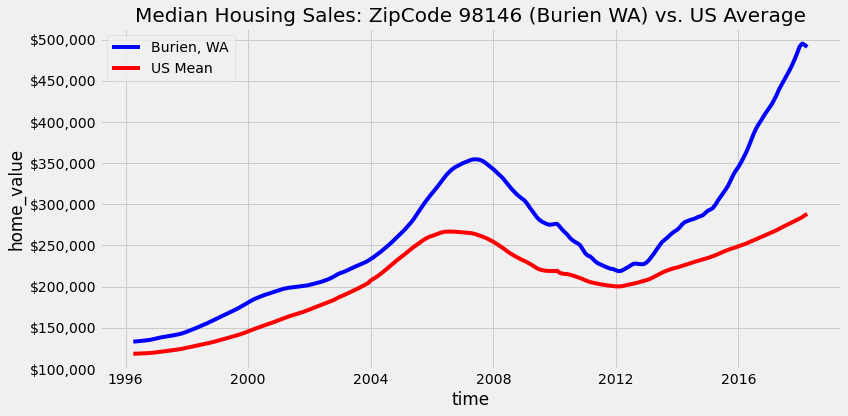

In [132]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_98146_ts, label='Burien, WA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 98146 (Burien WA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [133]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_98146_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7362.767296261583
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6874.331403322049
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 5973.633089203731
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5701.825802156531


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5454.963430737113


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((0, 0, 0), (1, 1, 1, 12)) AIC: 5434.974990751487


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 4961.666862824689
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4607.722372600709
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 4566.409039337339
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4361.7376846966035


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4313.392531987074


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4099.546982534159


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (1, 1, 1, 12)) AIC: 4091.911429335484


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 4054.411461278846
SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 3983.118460636853


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 3966.1427731868625


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 3959.739242324109
SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 3880.4019520846496


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3862.71535857798

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [134]:
combo

((1, 1, 1), (1, 1, 1, 12))

In [135]:
# Manually split data.
temp_ts = zip_98146_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1553.152
Date:                            Wed, 18 May 2022   AIC                           3116.304
Time:                                    14:55:40   BIC                           3132.745
Sample:                                04-01-1996   HQIC                          3122.959
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9495      0.022     43.171      0.000       0.906       0.993
ma.L1          0.3803      0.048      7.956      0.000       0.287       0.474
ar.S.L12       0.1357      0.024      5.694      0.000       0.089       0.182
ma.S.L12      -0.8935      0.047    -18.983      0.000      -0.986      -0.801
sigma2      2.859e+05    1.3e+04     21.913      0.000     2.6e+05    3.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.14   Jarque-Bera (JB):               311.86
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               9.30   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
zip_98146_model = sarima_model

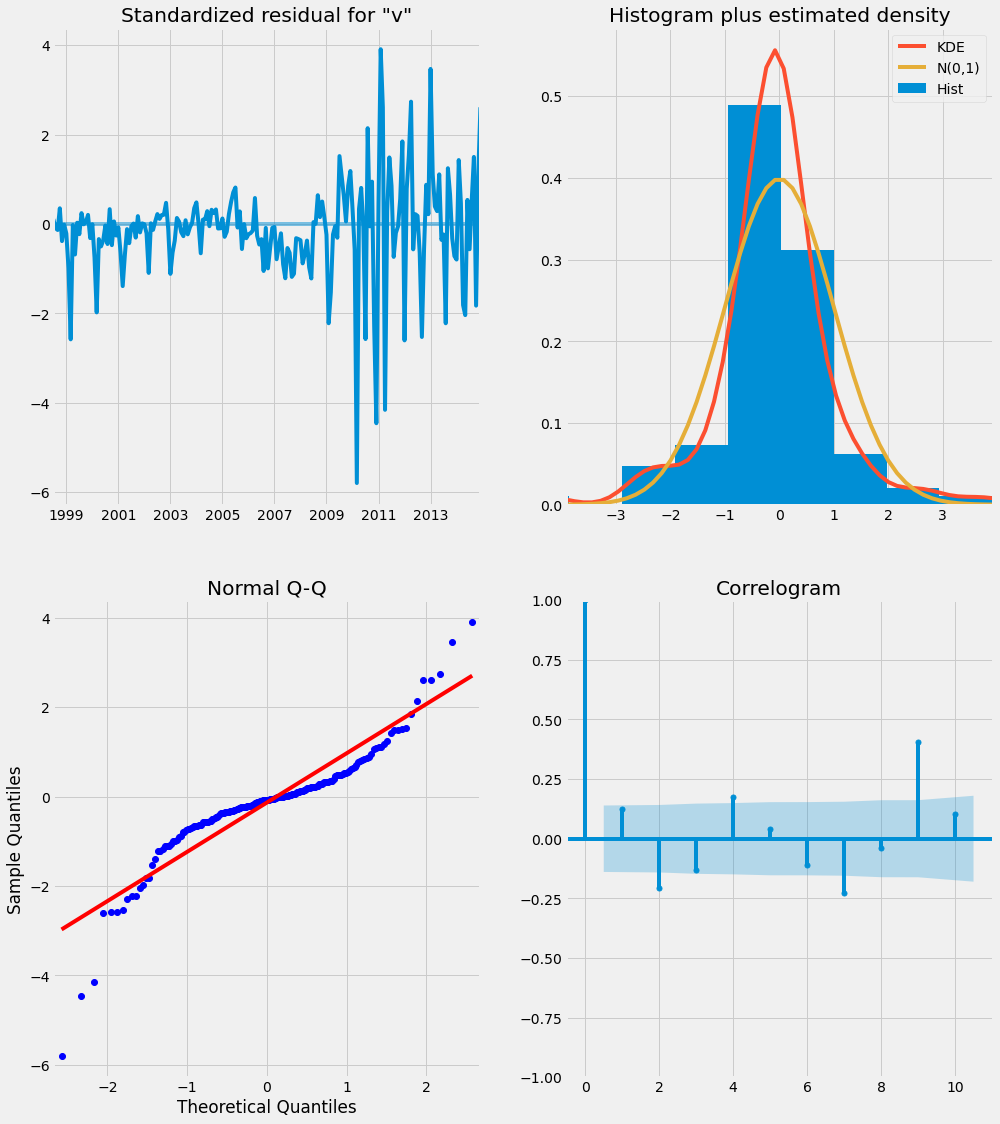

In [137]:
zip_98146_model.plot_diagnostics(figsize=(15, 18))
plt.show()

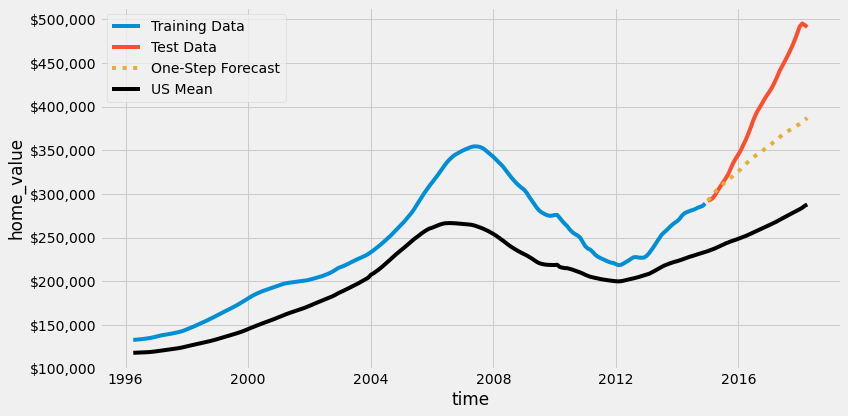

In [138]:
pred = zip_98146_model.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [139]:
#pred.predicted_mean

In [140]:
pred.conf_int().head()

lower value  upper value
2015-01-01   291,314.35   293,413.74
2015-02-01   293,117.75   298,440.30
2015-03-01   294,785.37   304,016.13
2015-04-01   295,912.39   309,564.58
2015-05-01   296,439.65   314,915.23

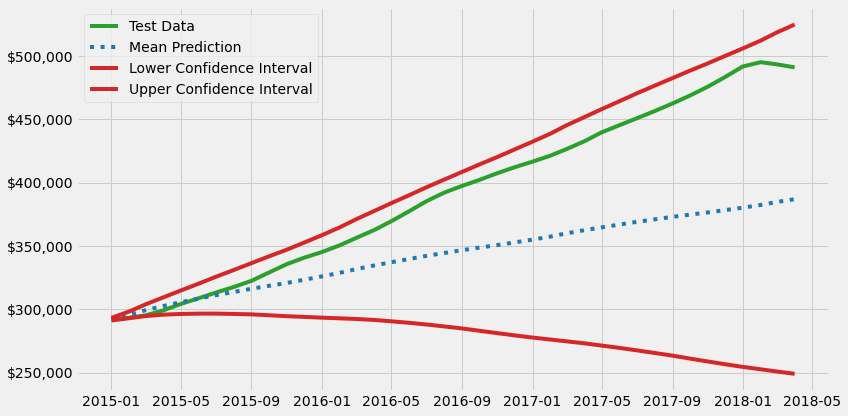

In [141]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

#### Prediction

In [142]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_98146_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1926.358
Date:                            Wed, 18 May 2022   AIC                           3862.715
Time:                                    14:55:41   BIC                           3880.077
Sample:                                04-01-1996   HQIC                          3869.712
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9071      0.032     28.389      0.000       0.844       0.970
ma.L1          0.5799      0.034     16.888      0.000       0.513       0.647
ar.S.L12       0.1196      0.060      1.980      0.048       0.001       0.238
ma.S.L12      -0.6561      0.065    -10.137      0.000      -0.783      -0.529
sigma2      5.325e+05   2.47e+04     21.542      0.000    4.84e+05    5.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):              1013.40
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               7.37   Skew:                            -1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [143]:
zip_98146_model_full = sarima_model

In [144]:
zip_98146_ts.tail()

value
time                 
2017-12-01 483,400.00
2018-01-01 491,800.00
2018-02-01 495,200.00
2018-03-01 493,500.00
2018-04-01 491,100.00

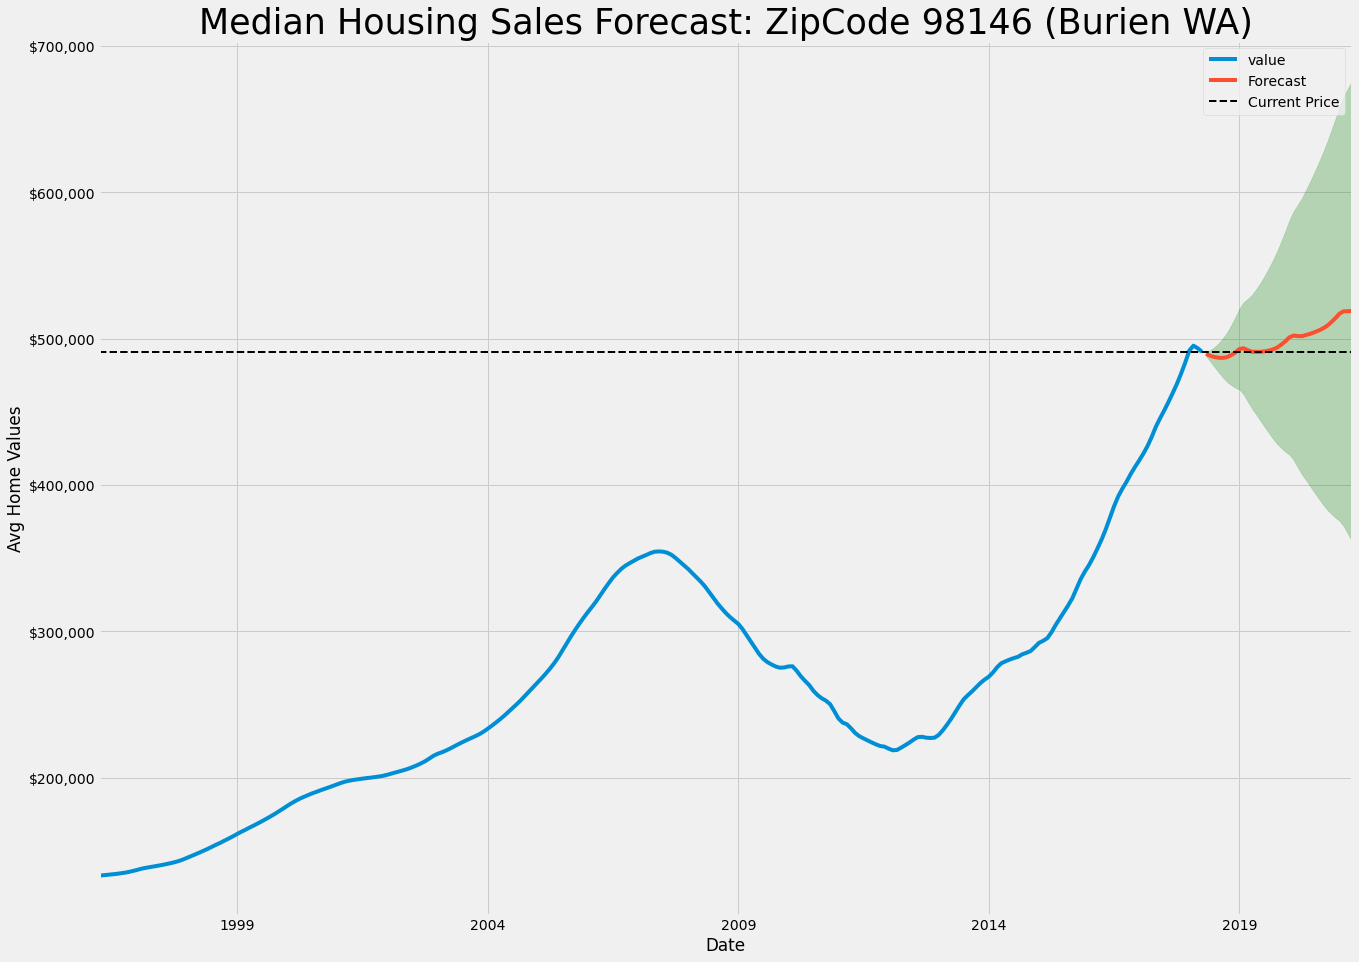

In [294]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_98146_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_98146_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(491000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98146 (Burien WA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### Analysis: 
- The confidence window on this zipcode is too wide, with a nearly equal chance of gains and losses. I do not recommend investing in this zipcode.

In [146]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   488,216.20
2019-12-31   492,938.33
2020-12-31   505,282.42
2021-12-31   518,407.87
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   476,197.30   500,235.10
2019-12-31   442,706.59   543,170.08
2020-12-31   397,683.19   612,881.66
2021-12-31   368,779.54   668,036.20


In [147]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 3754291194.92
The Root Mean Squared Error is 61272.27


## 95570: Trinidad CA

In [148]:
#zip_95570_ts.plot(figsize=(12,6));

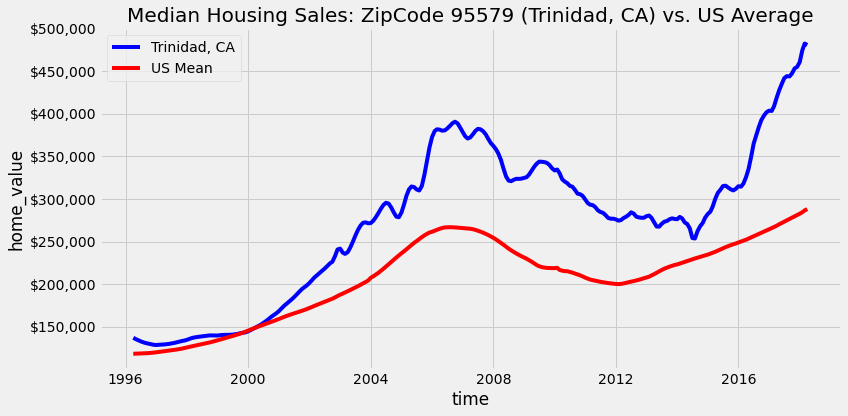

In [149]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_95570_ts, label='Trinidad, CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 95579 (Trinidad, CA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [150]:
#sarimax_param_search(zip_95570_ts)

In [151]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_95570_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7388.372931614158
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6899.347760326284
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 6009.486872441405
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5736.421631524832


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5678.670929101283


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 1), (1, 1, 0, 12)) AIC: 5549.955605706329


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 5163.083473375726
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4938.235126501251
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4771.791449808974


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (1, 1, 1, 12)) AIC: 4770.534308848984
SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4679.299779729259


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4578.523001372223


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (1, 1, 1, 12)) AIC: 4570.638928500629


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 4516.318584121826
SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 4479.435162074368


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4470.940175311183

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [152]:
combo

((1, 1, 1), (1, 1, 1, 12))

In [153]:
# Manually split data.
temp_ts = zip_95570_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1827.675
Date:                            Wed, 18 May 2022   AIC                           3665.350
Time:                                    14:55:52   BIC                           3681.791
Sample:                                04-01-1996   HQIC                          3672.004
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6468      0.062     10.412      0.000       0.525       0.769
ma.L1          0.8060      0.068     11.917      0.000       0.673       0.939
ar.S.L12       0.2504      0.062      4.067      0.000       0.130       0.371
ma.S.L12      -0.4710      0.062     -7.568      0.000      -0.593      -0.349
sigma2      7.786e+06   7.69e+05     10.129      0.000    6.28e+06    9.29e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.25   Jarque-Bera (JB):                48.73
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.81   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [154]:
zip_95570_model = sarima_model

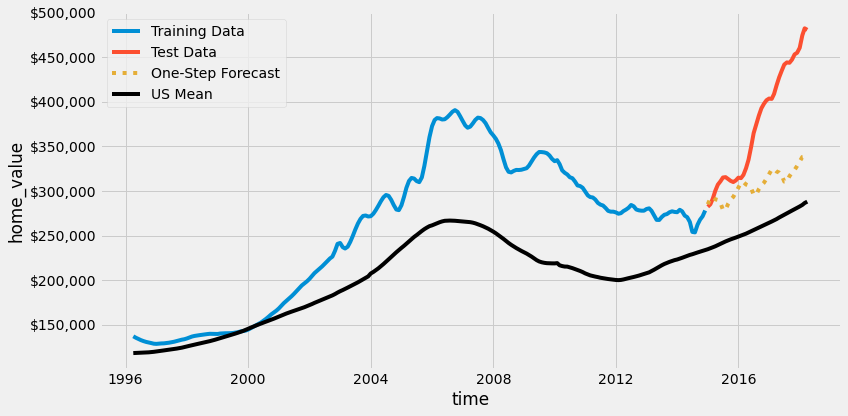

In [155]:
pred = zip_95570_model.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

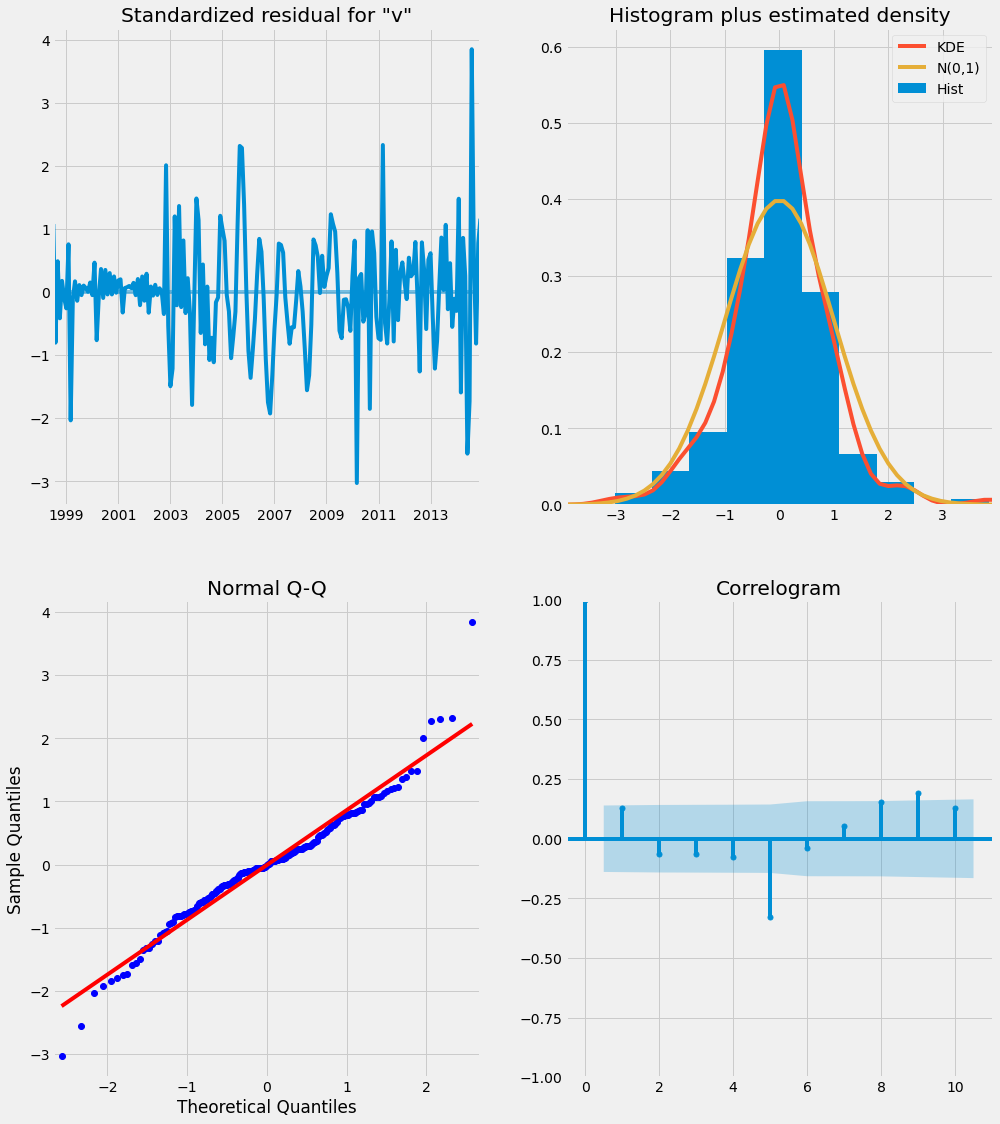

In [156]:
zip_95570_model.plot_diagnostics(figsize=(15, 18))
plt.show()

In [157]:
pred.conf_int().head()

lower value  upper value
2015-01-01   279,604.09   290,542.28
2015-02-01   277,222.51   306,196.75
2015-03-01   269,467.72   316,549.12
2015-04-01   258,506.38   322,783.49
2015-05-01   249,784.45   330,042.59

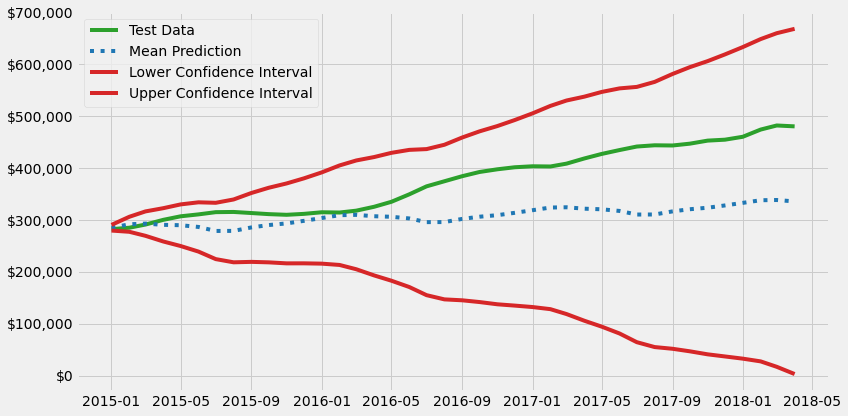

In [158]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

#### Prediction

In [159]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_95570_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2230.470
Date:                            Wed, 18 May 2022   AIC                           4470.940
Time:                                    14:55:53   BIC                           4488.302
Sample:                                04-01-1996   HQIC                          4477.937
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5914      0.055     10.846      0.000       0.485       0.698
ma.L1          0.7985      0.055     14.440      0.000       0.690       0.907
ar.S.L12       0.2910      0.061      4.766      0.000       0.171       0.411
ma.S.L12      -0.5194      0.064     -8.149      0.000      -0.644      -0.395
sigma2      1.035e+07   2.58e-09   4.02e+15      0.000    1.04e+07    1.04e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):                43.18
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.62e+31. Standard errors may be unstable.
"""

In [160]:
zip_95570_model_full = sarima_model

In [161]:
zip_95570_ts.tail(1)

value
time                 
2018-04-01 480,600.00

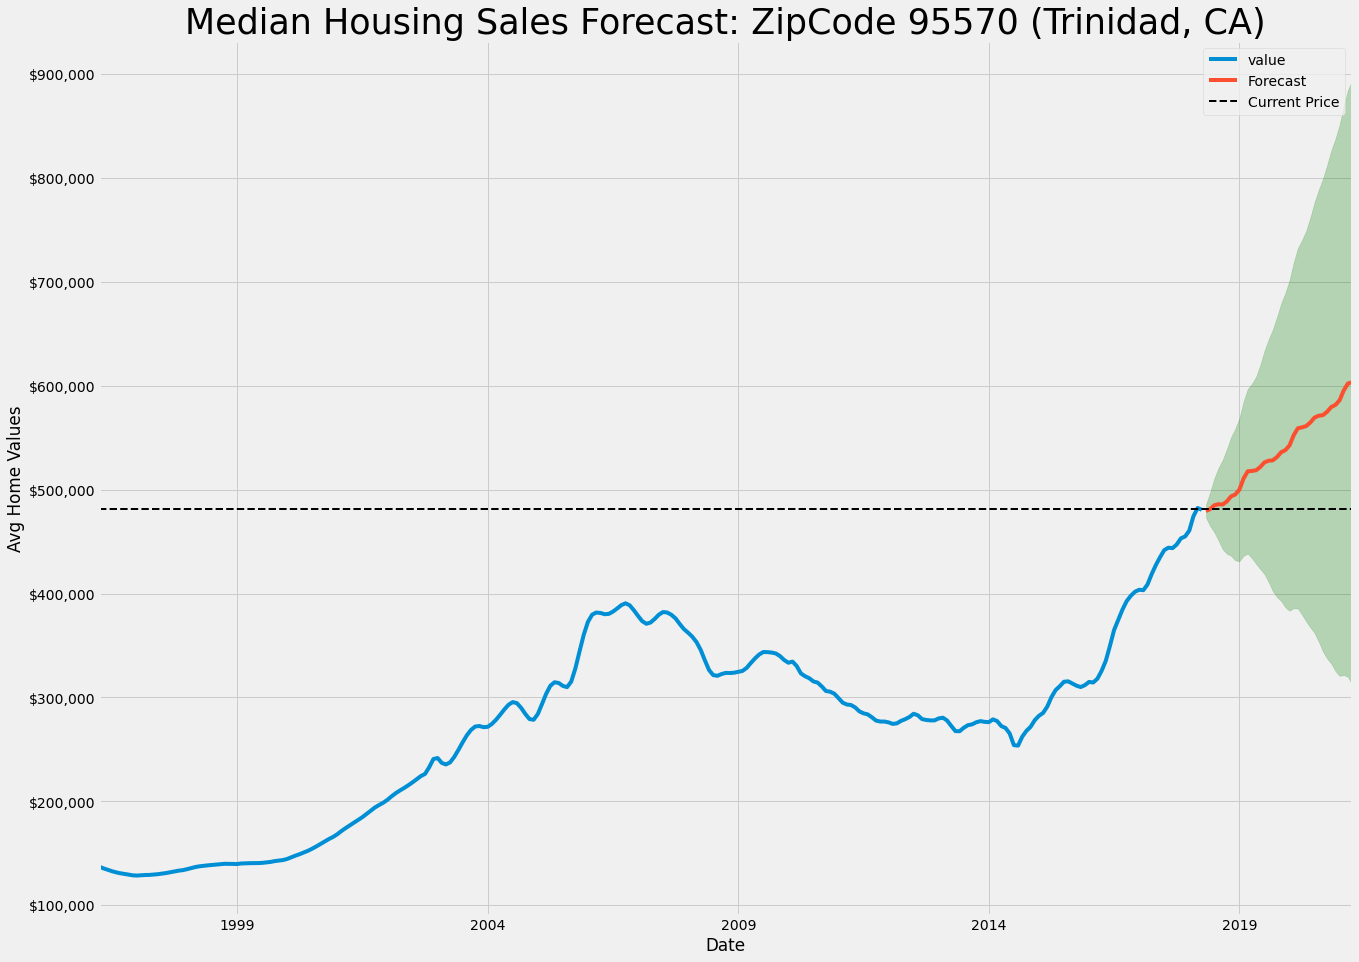

In [295]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_95570_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_95570_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(481000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 95570 (Trinidad, CA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### Analysis: 
- Confidence window is too large. Nearly equal chance for gain and loss. I do not recommend investing in this zipcode.

In [163]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   486,811.12
2019-12-31   522,836.42
2020-12-31   565,623.52
2021-12-31   596,726.17
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   449,635.92   523,986.32
2019-12-31   416,673.32   628,999.52
2020-12-31   360,852.78   770,394.26
2021-12-31   318,666.61   874,785.73


## 37046: College Grove TN

In [164]:
#zip_37046_ts.plot(figsize=(15,6));
#plt.show()

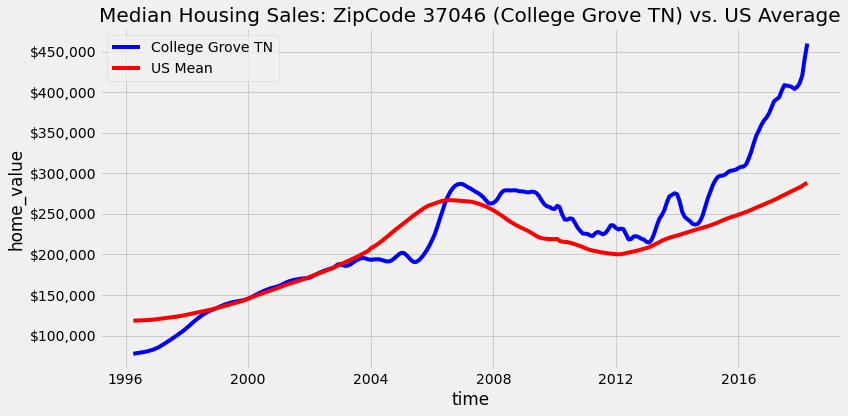

In [165]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_37046_ts, label='College Grove TN', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 37046 (College Grove TN) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [166]:
#sarimax_param_search(zip_37046_ts)

In [167]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_37046_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7286.68212279832
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 5936.895981794634
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5648.758836993744


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 1), (0, 1, 1, 12)) AIC: 5454.890025815646


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 1), (1, 1, 1, 12)) AIC: 5449.053089228191
SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 5123.875807692175
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4902.737244017266
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4734.160984218469


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (1, 1, 0, 12)) AIC: 4717.942498018894
SARIMA Combos: ((0, 1, 0), (1, 1, 1, 12)) AIC: 4691.296322195634
SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4637.073406806172


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4523.64599388748


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 4463.058877531224
SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 4450.904798061699


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 1, 12)) AIC: 4449.409324031111
SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 4434.536599587415


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 4346.6658124209225


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4342.43246819299

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [168]:
# Manually split data.
temp_ts = zip_37046_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1781.355
Date:                            Wed, 18 May 2022   AIC                           3572.709
Time:                                    14:56:04   BIC                           3589.151
Sample:                                04-01-1996   HQIC                          3579.364
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7109      0.056     12.781      0.000       0.602       0.820
ma.L1          0.7517      0.034     21.981      0.000       0.685       0.819
ar.S.L12       0.2216      0.087      2.560      0.010       0.052       0.391
ma.S.L12      -0.5984      0.067     -8.902      0.000      -0.730      -0.467
sigma2      4.415e+06   4.13e+05     10.701      0.000    3.61e+06    5.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.23   Jarque-Bera (JB):                38.13
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               9.27   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [169]:
zip_37046_model = sarima_model

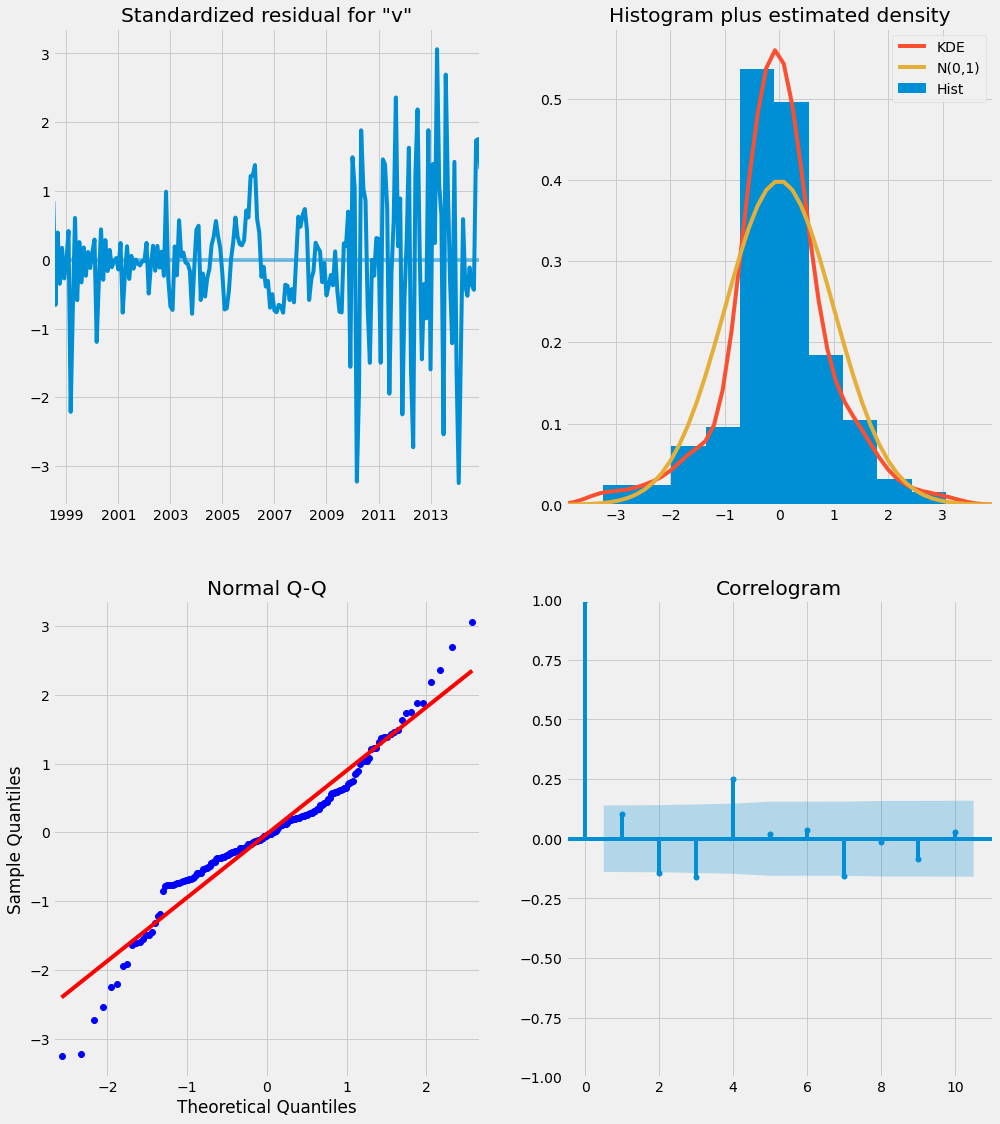

In [170]:
zip_37046_model.plot_diagnostics(figsize=(15, 18))
plt.show()

In [171]:
pred.conf_int().head()

lower value  upper value
2015-01-01   279,604.09   290,542.28
2015-02-01   277,222.51   306,196.75
2015-03-01   269,467.72   316,549.12
2015-04-01   258,506.38   322,783.49
2015-05-01   249,784.45   330,042.59

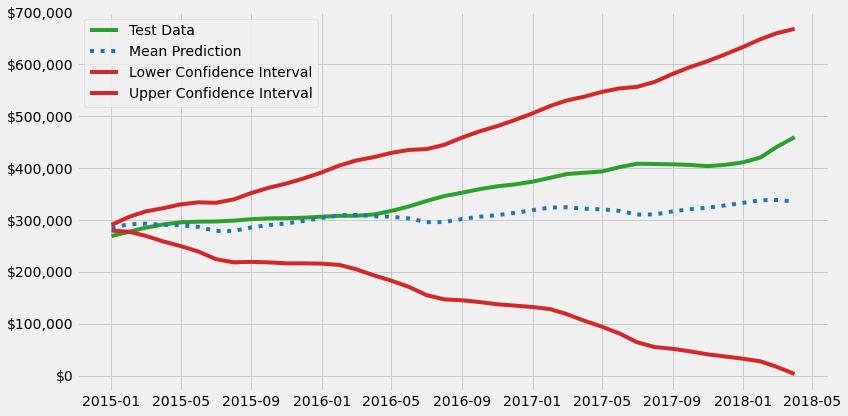

In [172]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

#### Prediction

In [173]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_37046_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2166.216
Date:                            Wed, 18 May 2022   AIC                           4342.432
Time:                                    14:56:05   BIC                           4359.794
Sample:                                04-01-1996   HQIC                          4349.429
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7166      0.057     12.507      0.000       0.604       0.829
ma.L1          0.7790      0.037     21.255      0.000       0.707       0.851
ar.S.L12       0.2480      0.086      2.898      0.004       0.080       0.416
ma.S.L12      -0.6107      0.068     -8.928      0.000      -0.745      -0.477
sigma2      5.939e+06   5.34e+05     11.114      0.000    4.89e+06    6.99e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                31.81
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               7.74   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [174]:
zip_37046_model_full = sarima_model

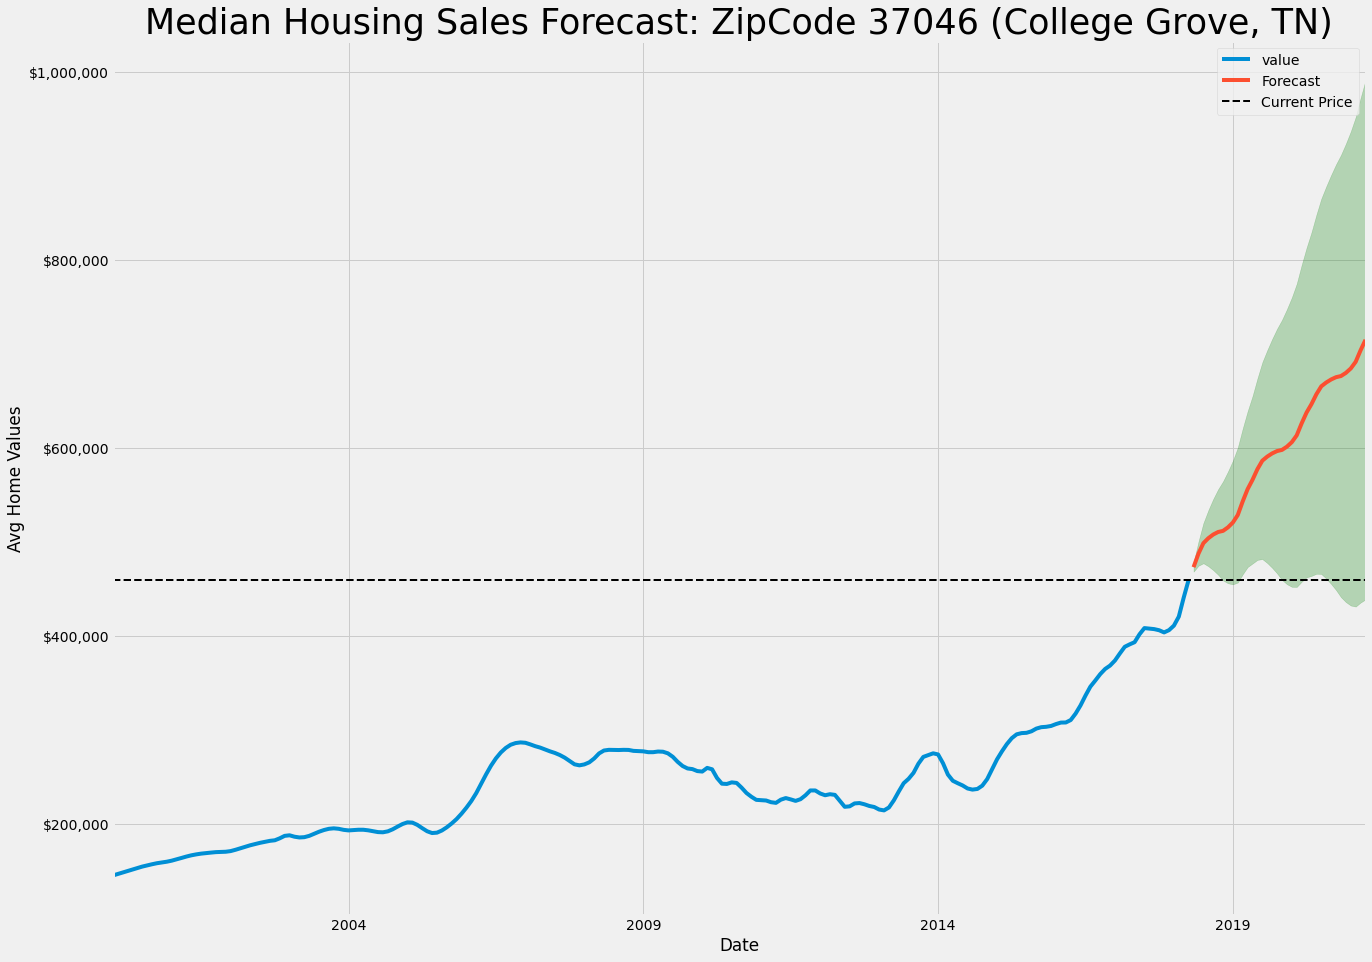

In [296]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_37046_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['2000-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(460000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 37046 (College Grove, TN)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

In [176]:
pred_conf.tail(2)

lower value  upper value
2021-03-01   435,701.86   972,295.96
2021-04-01   439,002.98   991,189.65

In [177]:
final_value = zip_37046_ts.tail(1)
final_value

value
time                 
2018-04-01 459,800.00

In [178]:
final_value.rename(columns={'value': 'mean'}, inplace=True)

In [179]:
df = pred_conf

In [180]:
df.head(1)

lower value  upper value
2018-05-01   468,515.37   478,068.11

In [181]:
df['mean'] = df.apply(lambda x: x.mean(), axis=1)

In [182]:
df = df.resample('Y').mean()

In [183]:
df.reset_index()

index  lower value  upper value       mean
0 2018-12-31   468,257.69   534,250.03 501,253.86
1 2019-12-31   468,612.24   674,831.47 571,721.86
2 2020-12-31   455,392.58   849,225.72 652,309.15
3 2021-12-31   434,655.38   963,055.53 698,855.46

In [184]:
 df = df.transpose()

In [185]:
df['ROI'] = df.apply(lambda x: x['2018-12-31'] / x['2021-12-31'], axis=1)

In [186]:
df.iloc[2]

2018-12-31 00:00:00   501,253.86
2019-12-31 00:00:00   571,721.86
2020-12-31 00:00:00   652,309.15
2021-12-31 00:00:00   698,855.46
ROI                         0.72
Name: mean, dtype: float64

In [187]:
#recent_data_2['ROI'] = recent_data_2.iloc[:, 7:].apply(lambda x: x['2018-04'] - x['2015-01'], axis=1)
#recent_data_2['ROI%'] = recent_data_2.iloc[:, 7:].apply(lambda x: x['ROI'] / x['2015-01'], axis=1)

### Analysis: 
- Potential loss forecast for the next three years is minimal. Model confidence interval lower value for year 3 is 439,002, which would just be a loss of 20,000. 
- While potential loss is low, potential gain is high. I recommend this as a zipcode to pursue.

In [188]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   501,253.86
2019-12-31   571,721.86
2020-12-31   652,309.15
2021-12-31   698,855.46
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value       mean
2018-12-31   468,257.69   534,250.03 501,253.86
2019-12-31   468,612.24   674,831.47 571,721.86
2020-12-31   455,392.58   849,225.72 652,309.15
2021-12-31   434,655.38   963,055.53 698,855.46


## 98043: Mountlake Terrace WA

In [189]:
#zip_98043_ts.plot(figsize=(15,6))
#plt.show()

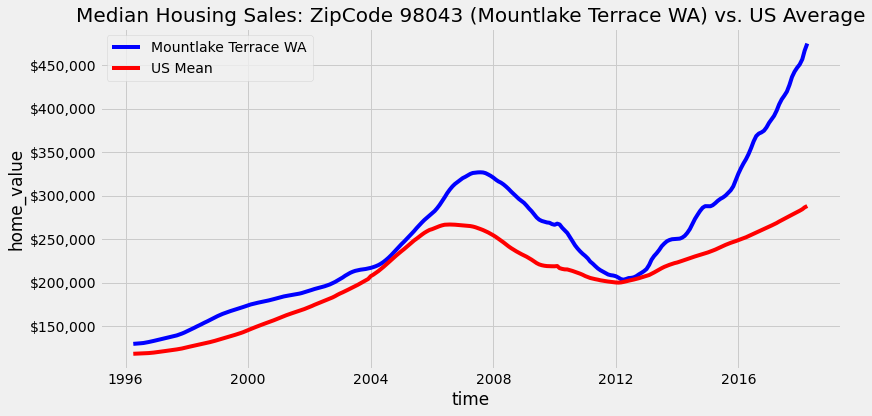

In [190]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_98043_ts, label='Mountlake Terrace WA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 98043 (Mountlake Terrace WA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [191]:
#sarimax_param_search(zip_98043_ts)

In [192]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_98043_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7329.350563848335
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6842.384340773566
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 5922.73753231322
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5652.857240163422


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5424.826640983445


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 4941.778096172813
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4610.870976907714
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 4598.164755384462
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4384.64482607762


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4305.2519440238


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4115.921077536983


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 4074.6588200993433
SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 4049.512706099364


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 4015.333694479775


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 3973.2081721085774


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 3936.6654490018127


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3916.8599638578153

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [193]:
# Manually split data.
temp_ts = zip_98043_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1576.714
Date:                            Wed, 18 May 2022   AIC                           3163.428
Time:                                    14:56:19   BIC                           3179.869
Sample:                                04-01-1996   HQIC                          3170.083
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9313      0.018     51.295      0.000       0.896       0.967
ma.L1          0.2482      0.022     11.177      0.000       0.205       0.292
ar.S.L12      -0.5604      0.051    -10.992      0.000      -0.660      -0.460
ma.S.L12      -0.0213      0.036     -0.583      0.560      -0.093       0.050
sigma2      4.724e+05   2.89e+04     16.332      0.000    4.16e+05    5.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.91   Jarque-Bera (JB):               149.55
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):              20.39   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
zip_98043_model = sarima_model

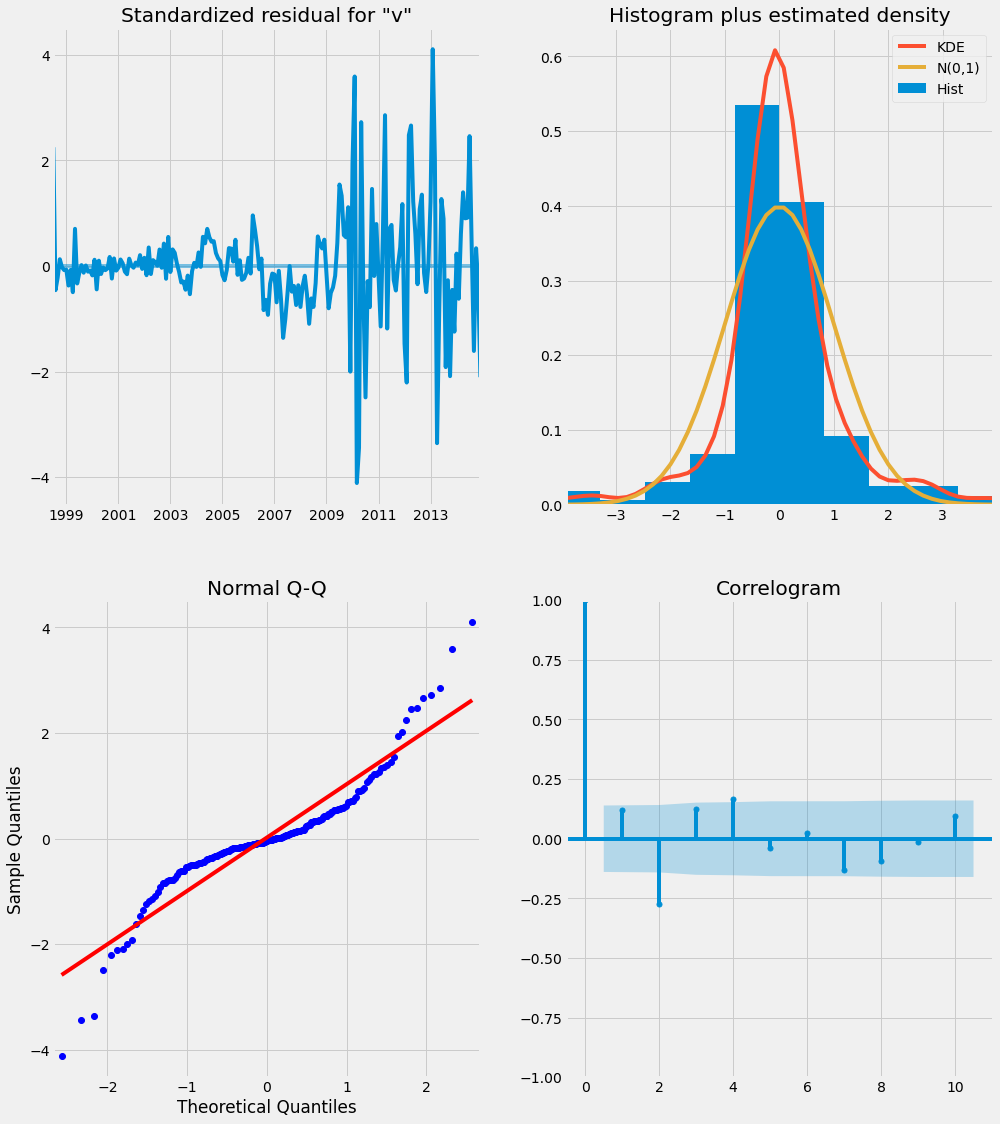

In [195]:
zip_98043_model.plot_diagnostics(figsize=(15, 18))
plt.show()

In [196]:
pred.conf_int().head()

lower value  upper value
2015-01-01   279,604.09   290,542.28
2015-02-01   277,222.51   306,196.75
2015-03-01   269,467.72   316,549.12
2015-04-01   258,506.38   322,783.49
2015-05-01   249,784.45   330,042.59

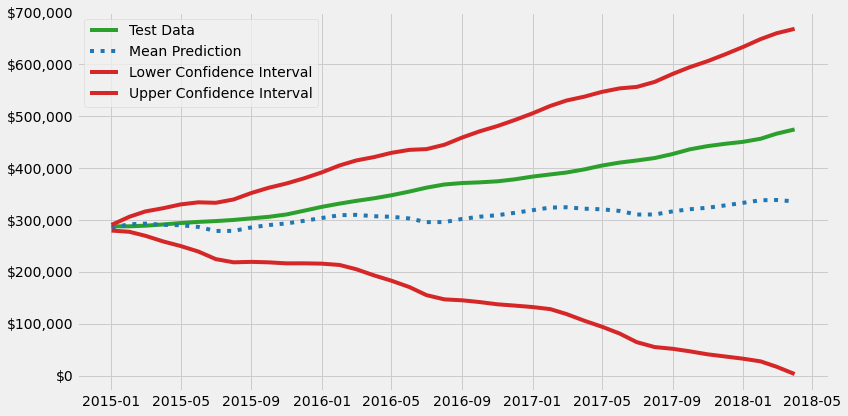

In [197]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

#### Prediction

In [198]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_98043_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1953.430
Date:                            Wed, 18 May 2022   AIC                           3916.860
Time:                                    14:56:20   BIC                           3934.221
Sample:                                04-01-1996   HQIC                          3923.857
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8252      0.027     30.924      0.000       0.773       0.877
ma.L1          0.7150      0.033     21.410      0.000       0.650       0.780
ar.S.L12       0.0948      0.037      2.585      0.010       0.023       0.167
ma.S.L12      -0.5773      0.033    -17.449      0.000      -0.642      -0.512
sigma2      6.748e+05   4.12e+04     16.380      0.000    5.94e+05    7.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.40   Jarque-Bera (JB):               122.34
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):               7.00   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
zip_98043_model_full = sarima_model

In [200]:
zip_98043_ts.tail(1)

value
time                 
2018-04-01 474,700.00

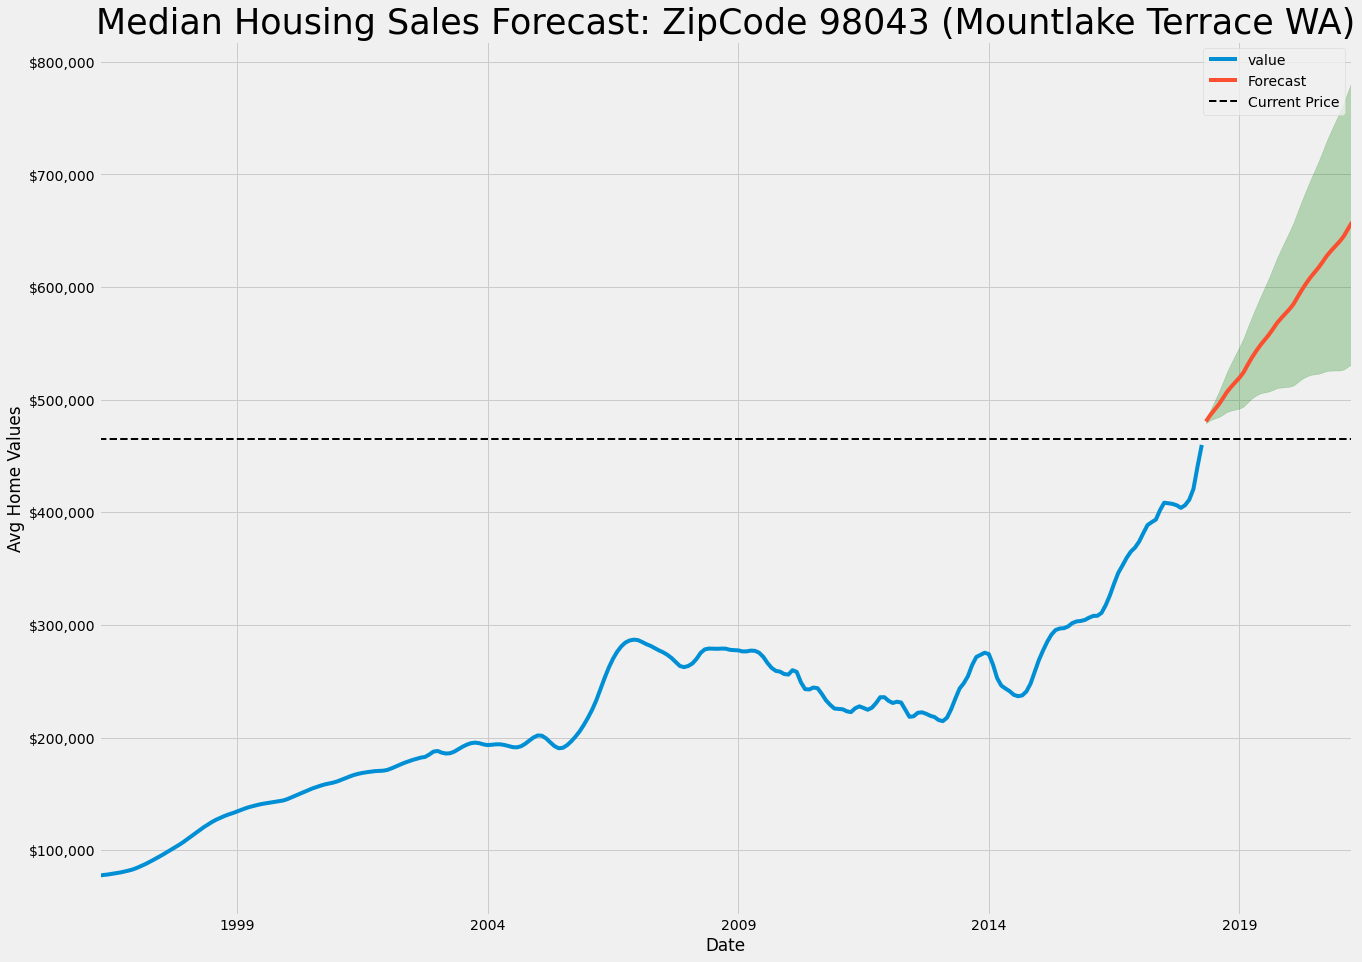

In [297]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_98043_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(465000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98043 (Mountlake Terrace WA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### Analysis: 
- confidence window is narrow and even the lower forecasted values are gains. I definitely recommend this zipcode!

In [202]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   498,359.83
2019-12-31   549,345.10
2020-12-31   609,655.87
2021-12-31   648,631.33
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   485,679.72   511,039.95
2019-12-31   504,012.88   594,677.32
2020-12-31   520,616.81   698,694.93
2021-12-31   528,397.22   768,865.44


## 02128: Boston MA 

In [203]:
#zip_02128_ts.plot(figsize=(15,6))
#plt.show()

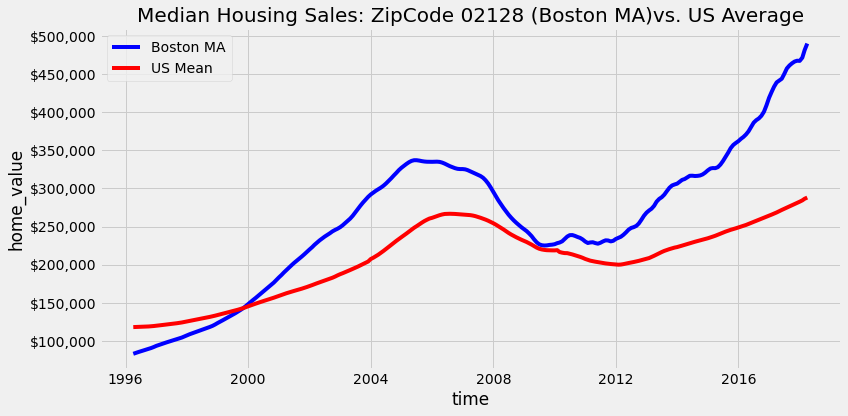

In [204]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_02128_ts, label='Boston MA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 02128 (Boston MA)vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [205]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_02128_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7365.310171750556
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6877.122594552993
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 5954.534906368024
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5682.025268876332


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5446.60371558842


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((0, 0, 0), (1, 1, 1, 12)) AIC: 5426.808971077991


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 4963.518708987453
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4660.234227187697
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 4642.319525299874
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4416.585504530893


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (1, 1, 1, 12)) AIC: 4414.710300387196


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4355.935924539917


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4133.5580657632


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 4108.231155568486


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 4053.6134242053895


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 3957.7876315458698


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3948.4693734854354

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [206]:
# Manually split data.
temp_ts = zip_02128_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1565.968
Date:                            Wed, 18 May 2022   AIC                           3141.937
Time:                                    14:56:33   BIC                           3158.378
Sample:                                04-01-1996   HQIC                          3148.592
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9090      0.027     33.912      0.000       0.856       0.962
ma.L1          0.7275      0.033     22.157      0.000       0.663       0.792
ar.S.L12       0.0700      0.038      1.830      0.067      -0.005       0.145
ma.S.L12      -0.8054      0.054    -14.893      0.000      -0.911      -0.699
sigma2        3.4e+05   2.87e+04     11.843      0.000    2.84e+05    3.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                40.47
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               7.27   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [207]:
zip_02128_model = sarima_model

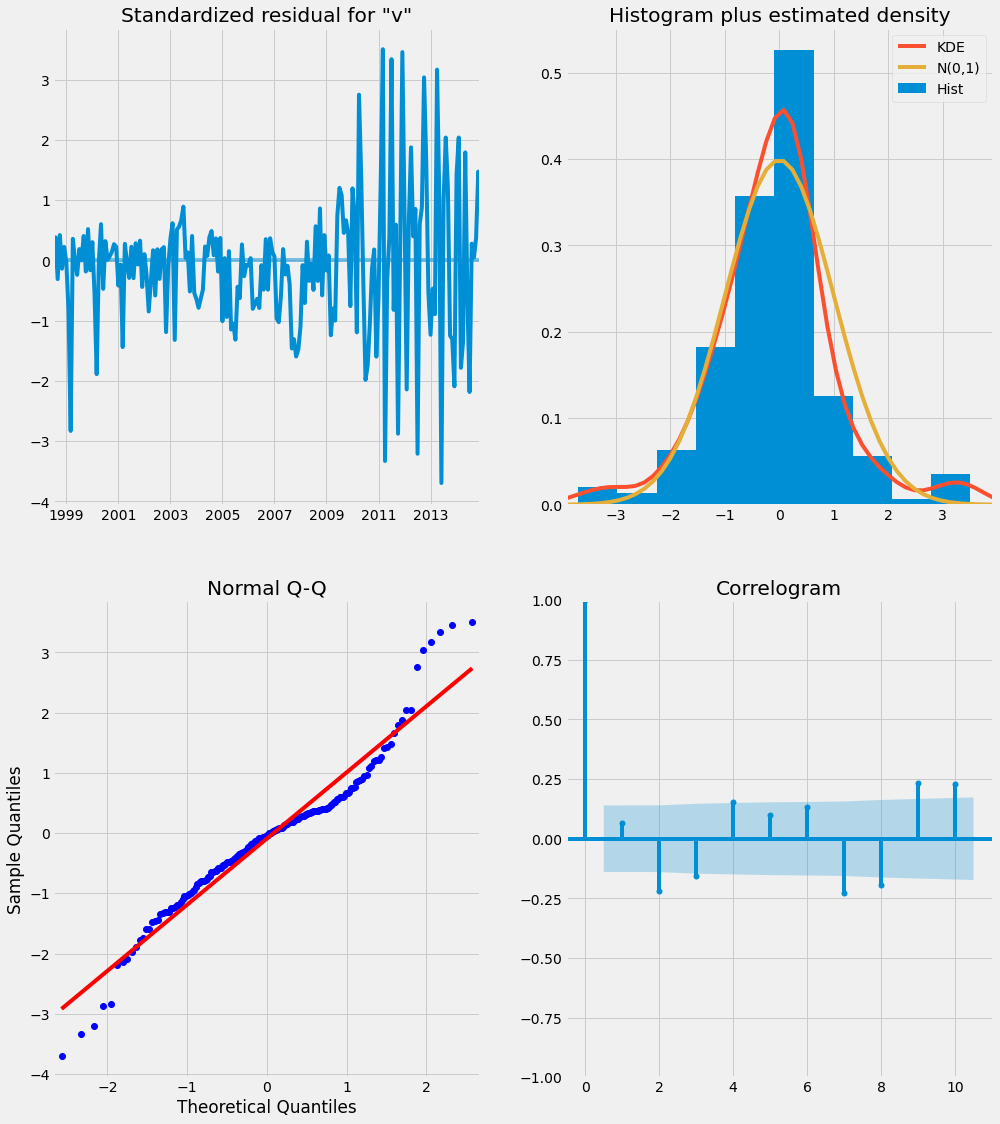

In [208]:
zip_02128_model.plot_diagnostics(figsize=(15, 18))
plt.show()

In [209]:
pred.conf_int().head()

lower value  upper value
2015-01-01   279,604.09   290,542.28
2015-02-01   277,222.51   306,196.75
2015-03-01   269,467.72   316,549.12
2015-04-01   258,506.38   322,783.49
2015-05-01   249,784.45   330,042.59

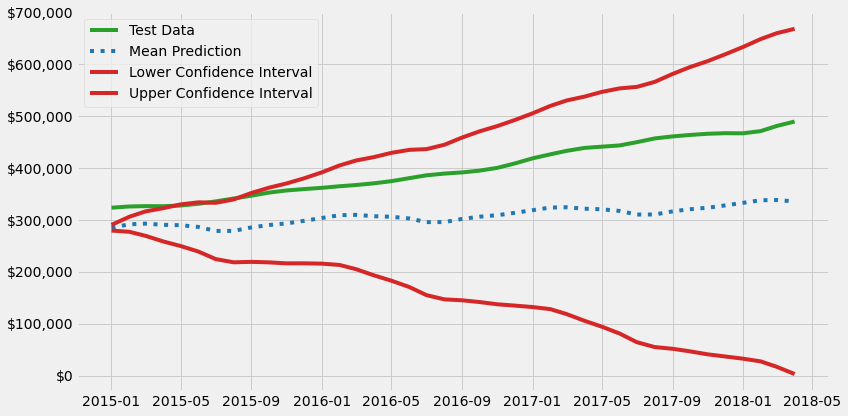

In [210]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

## 02121: Boston MA (#2)

In [211]:
#zip_02121_ts.plot(figsize=(15,6))
#plt.show()

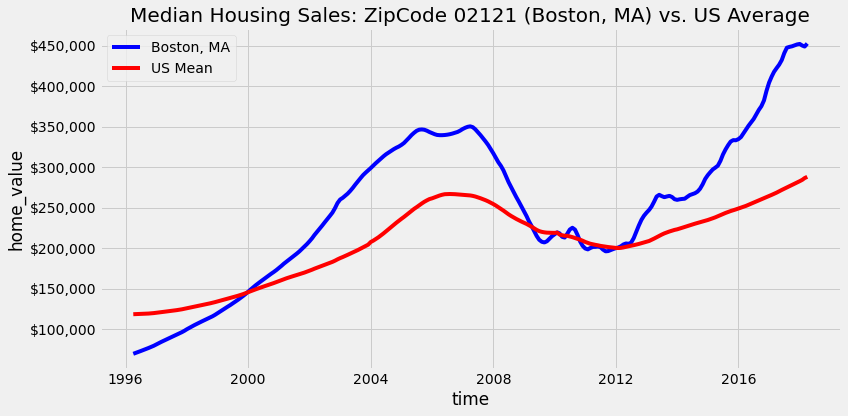

In [212]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_02121_ts, label='Boston, MA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 02121 (Boston, MA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [213]:
#sarimax_param_search(zip_02121_ts)

In [214]:
# Manually split data.
temp_ts = zip_02121_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1662.227
Date:                            Wed, 18 May 2022   AIC                           3334.454
Time:                                    14:56:35   BIC                           3350.896
Sample:                                04-01-1996   HQIC                          3341.109
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8682      0.034     25.795      0.000       0.802       0.934
ma.L1          0.7891      0.041     19.330      0.000       0.709       0.869
ar.S.L12       0.1279      0.048      2.691      0.007       0.035       0.221
ma.S.L12      -0.7331      0.041    -18.044      0.000      -0.813      -0.653
sigma2       9.61e+05    6.5e+04     14.775      0.000    8.33e+05    1.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.47   Jarque-Bera (JB):                81.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.19   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [215]:
zip_02121_model = sarima_model

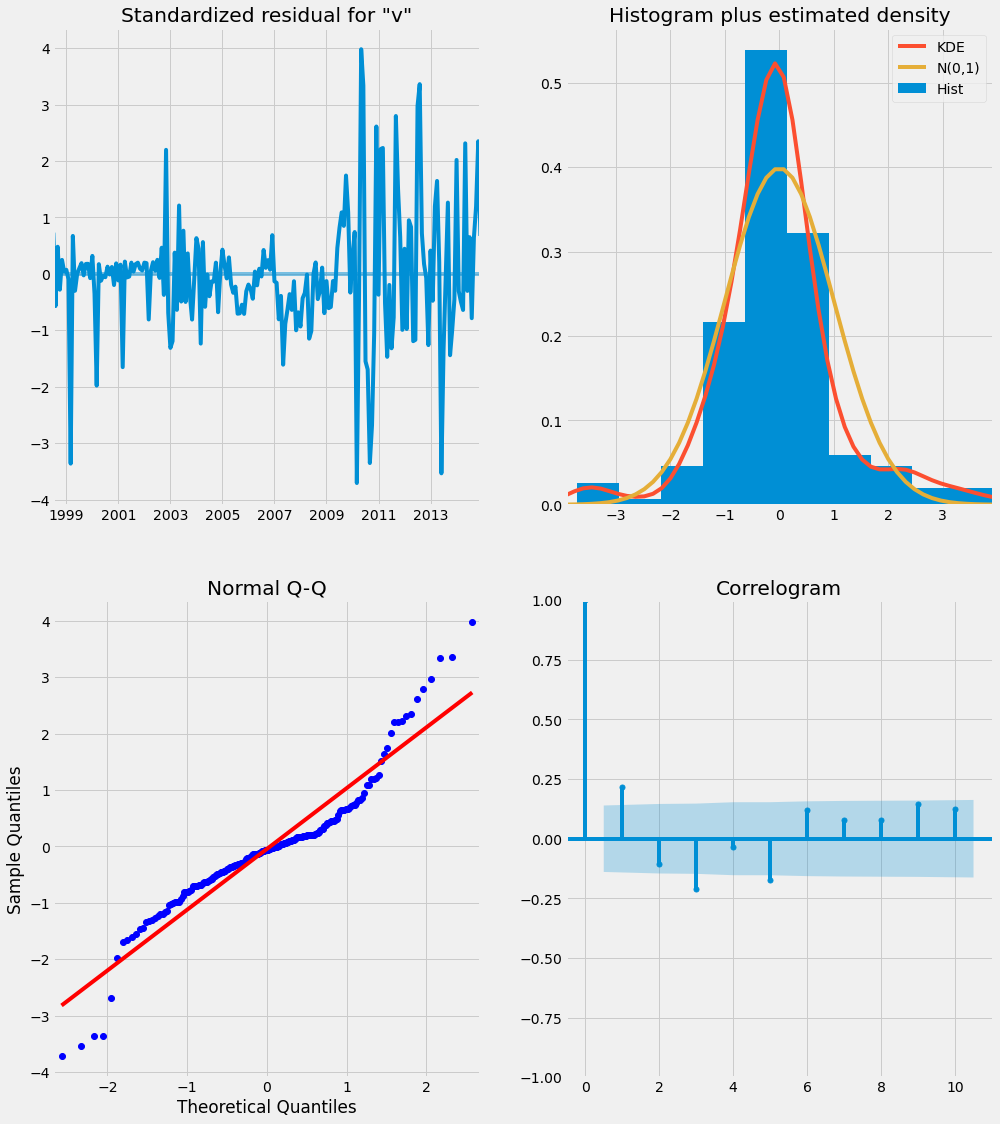

In [216]:
zip_02121_model.plot_diagnostics(figsize=(15, 18))
plt.show()

In [217]:
pred.conf_int().head()

lower value  upper value
2015-01-01   279,604.09   290,542.28
2015-02-01   277,222.51   306,196.75
2015-03-01   269,467.72   316,549.12
2015-04-01   258,506.38   322,783.49
2015-05-01   249,784.45   330,042.59

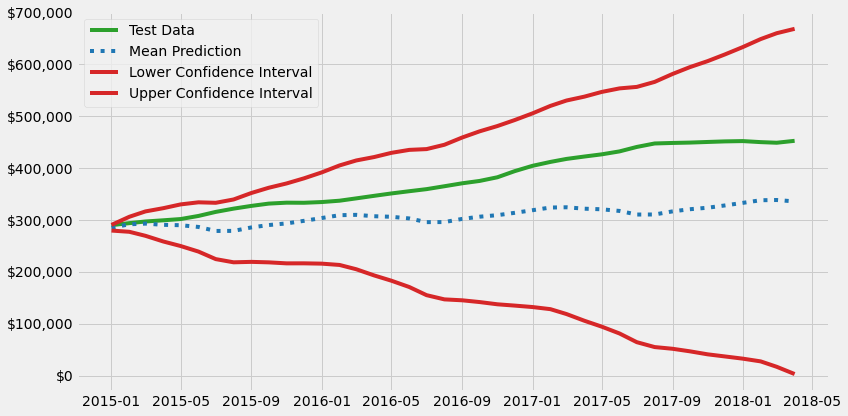

In [218]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

## Decision on Boston #1 vs Boston #2
- While both Zip Codes are nearly identical, and both would make great recommendations, I choose Zip Code 02128 as it performs slightly better, and notably had a higher ROI amount which was one of the client's stated criteria.
- It also is slightly more consistent when looking at the entire plot.
- Zip Code 02121 is a close #2 and is worth investing in as well.

### Boston Prediction

In [219]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_02128_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1969.235
Date:                            Wed, 18 May 2022   AIC                           3948.469
Time:                                    14:56:36   BIC                           3965.831
Sample:                                04-01-1996   HQIC                          3955.466
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7926      0.032     25.117      0.000       0.731       0.854
ma.L1          0.7739      0.028     27.686      0.000       0.719       0.829
ar.S.L12       0.0897      0.062      1.435      0.151      -0.033       0.212
ma.S.L12      -0.6286      0.049    -12.761      0.000      -0.725      -0.532
sigma2      8.071e+05   4.64e+04     17.388      0.000    7.16e+05    8.98e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.53   Jarque-Bera (JB):               230.85
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):              10.55   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [220]:
zip_02128_model_full = sarima_model

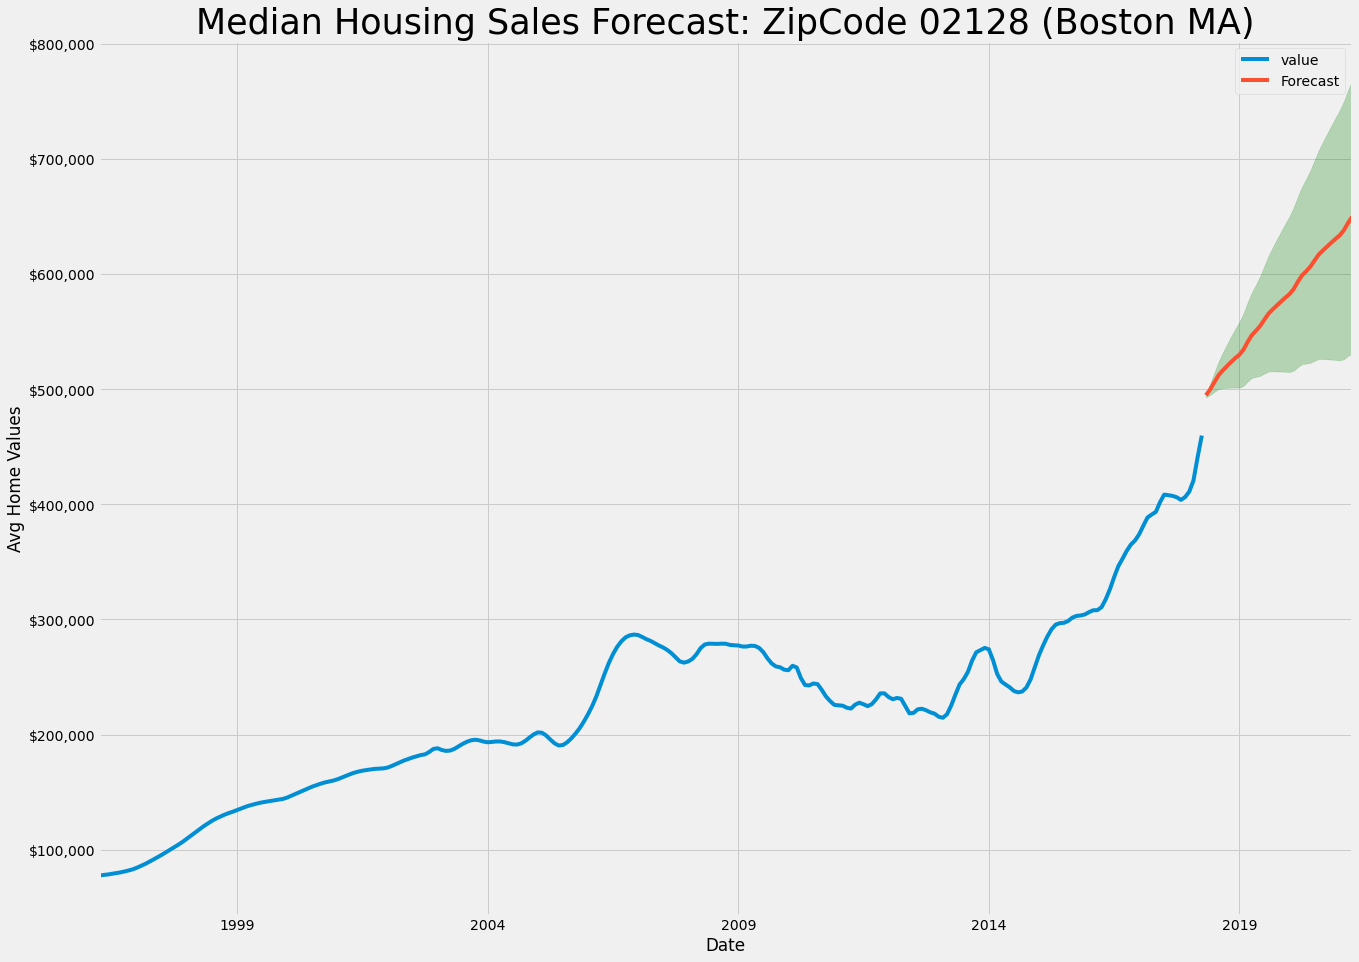

In [221]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_02128_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 02128 (Boston MA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### anaylsis: 
- confidence window is narrow and even the lower forecasted values are gains. I definitely recommend this zipcode!

In [222]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   512,514.32
2019-12-31   557,030.40
2020-12-31   608,620.65
2021-12-31   641,545.46
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   498,942.37   526,086.27
2019-12-31   511,264.16   602,796.64
2020-12-31   522,757.43   694,483.87
2021-12-31   527,880.09   755,210.84


## 07087: Union City NJ

In [223]:
#zip_07087_ts.plot(figsize=(15,6))
#plt.show()

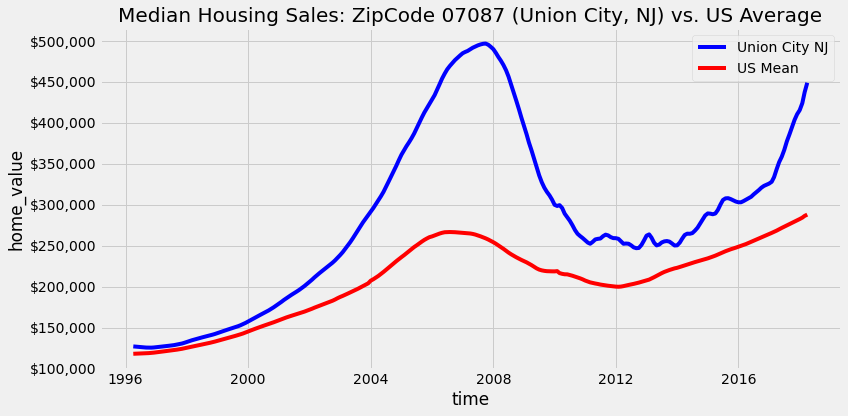

In [224]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_07087_ts, label='Union City NJ', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
ax.legend()
ax.set_title("Median Housing Sales: ZipCode 07087 (Union City, NJ) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [225]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_07087_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7415.227089906849


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6925.4380209997125
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 6135.669201303621
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5856.666854278961
SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5702.250772751864


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 5160.833920362519
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4874.863898357607
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 4863.903011142172
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4644.913759647025


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4542.778421440308


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4376.896638348457


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (1, 1, 1, 12)) AIC: 4365.0200172285895


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 4335.310730776255
SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 4277.448410402095


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 4250.331399736548


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((1, 1, 0), (1, 1, 1, 12)) AIC: 4240.024455766166
SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 4225.780631220172


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 4164.91751452935


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4153.772501773967

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [226]:
combo = ((1,1,1), (1,1,1,12))

In [227]:
# Manually split data.
temp_ts = zip_07087_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1709.800
Date:                            Wed, 18 May 2022   AIC                           3429.601
Time:                                    14:56:48   BIC                           3446.042
Sample:                                04-01-1996   HQIC                          3436.256
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8534      0.041     20.977      0.000       0.774       0.933
ma.L1          0.6464      0.048     13.489      0.000       0.552       0.740
ar.S.L12       0.2031      0.079      2.570      0.010       0.048       0.358
ma.S.L12      -0.5460      0.059     -9.320      0.000      -0.661      -0.431
sigma2      1.988e+06    1.4e+05     14.197      0.000    1.71e+06    2.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.13   Jarque-Bera (JB):               207.66
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):              11.61   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [228]:
zip_07087_model = sarima_model

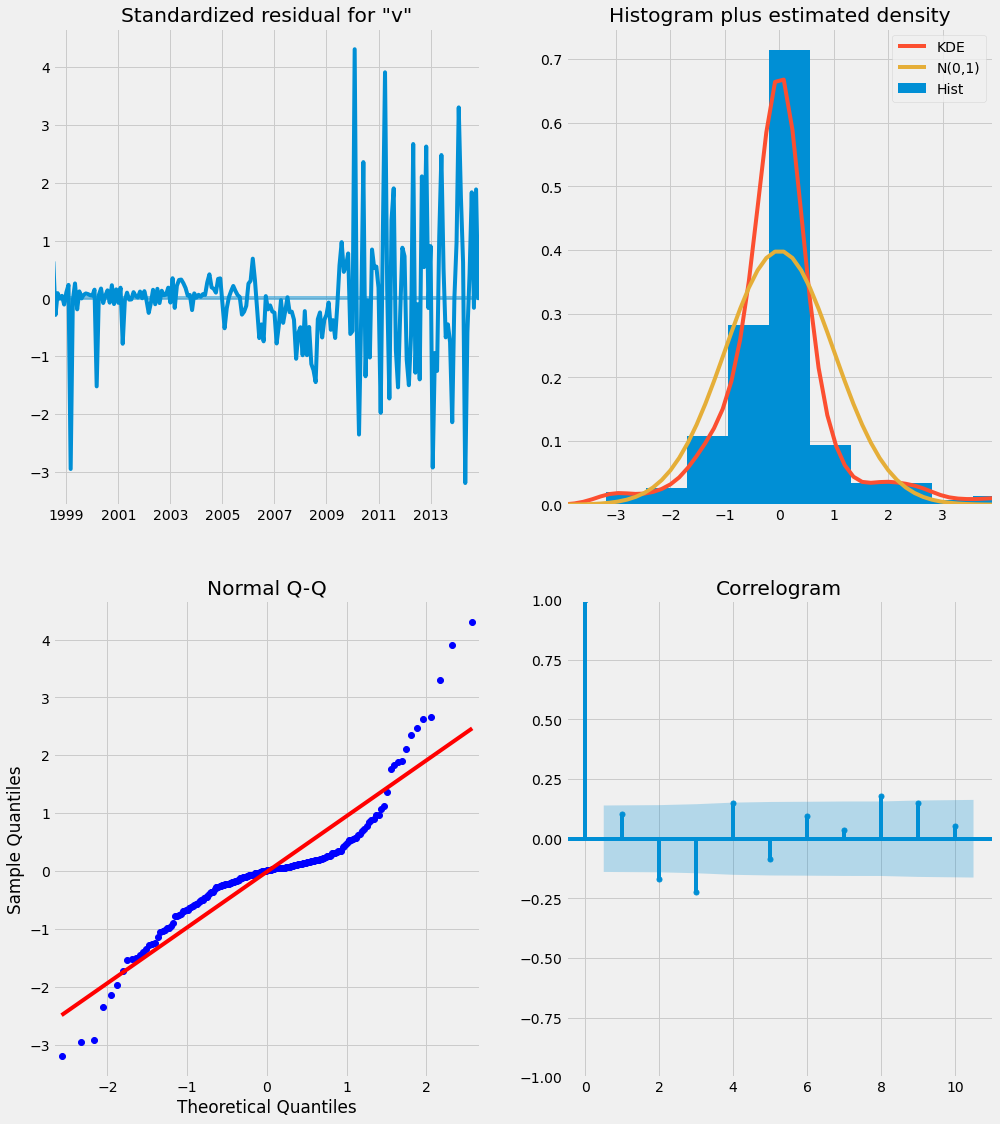

In [229]:
zip_07087_model.plot_diagnostics(figsize=(15, 18))
plt.show()

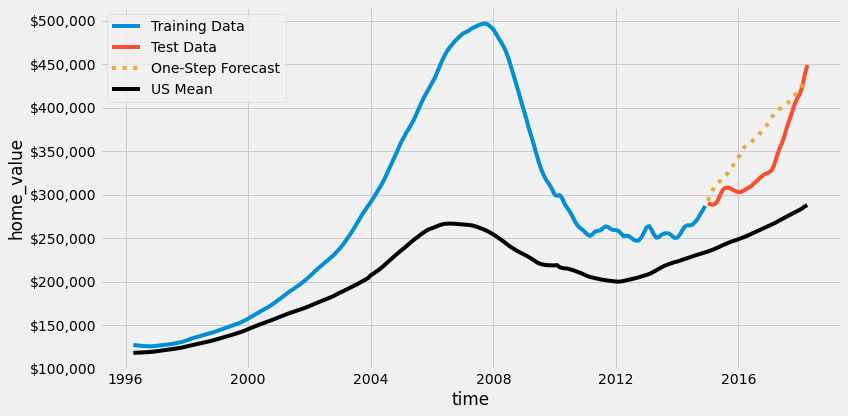

In [230]:
pred = zip_07087_model.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [231]:
pred.conf_int().head()

lower value  upper value
2015-01-01   290,197.31   295,724.59
2015-02-01   292,082.38   306,964.15
2015-03-01   292,621.70   318,272.30
2015-04-01   291,842.85   329,034.20
2015-05-01   289,081.43   338,199.13

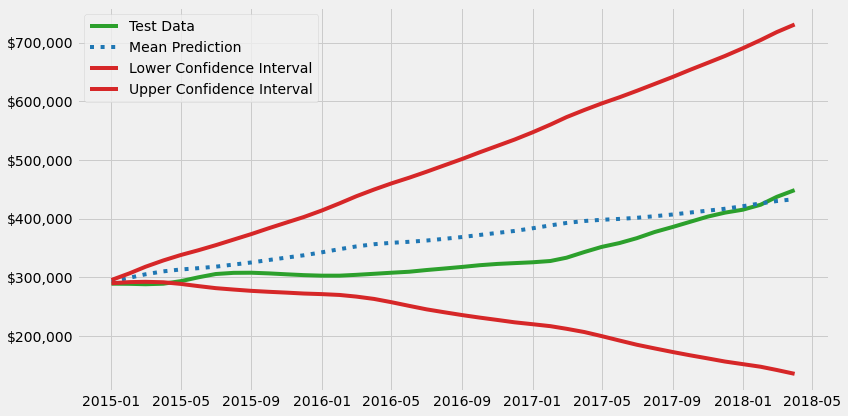

In [232]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

#### Prediction

In [233]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_07087_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2071.886
Date:                            Wed, 18 May 2022   AIC                           4153.773
Time:                                    14:56:49   BIC                           4171.134
Sample:                                04-01-1996   HQIC                          4160.769
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8282      0.037     22.542      0.000       0.756       0.900
ma.L1          0.6684      0.045     14.945      0.000       0.581       0.756
ar.S.L12       0.1974      0.061      3.211      0.001       0.077       0.318
ma.S.L12      -0.5389      0.047    -11.359      0.000      -0.632      -0.446
sigma2      2.265e+06   1.63e+05     13.917      0.000    1.95e+06    2.58e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.31   Jarque-Bera (JB):                97.60
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               9.05   Skew:                             0.51
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [234]:
zip_07087_model_full = sarima_model

In [235]:
zip_07087_ts.tail(1)

value
time                 
2018-04-01 448,900.00

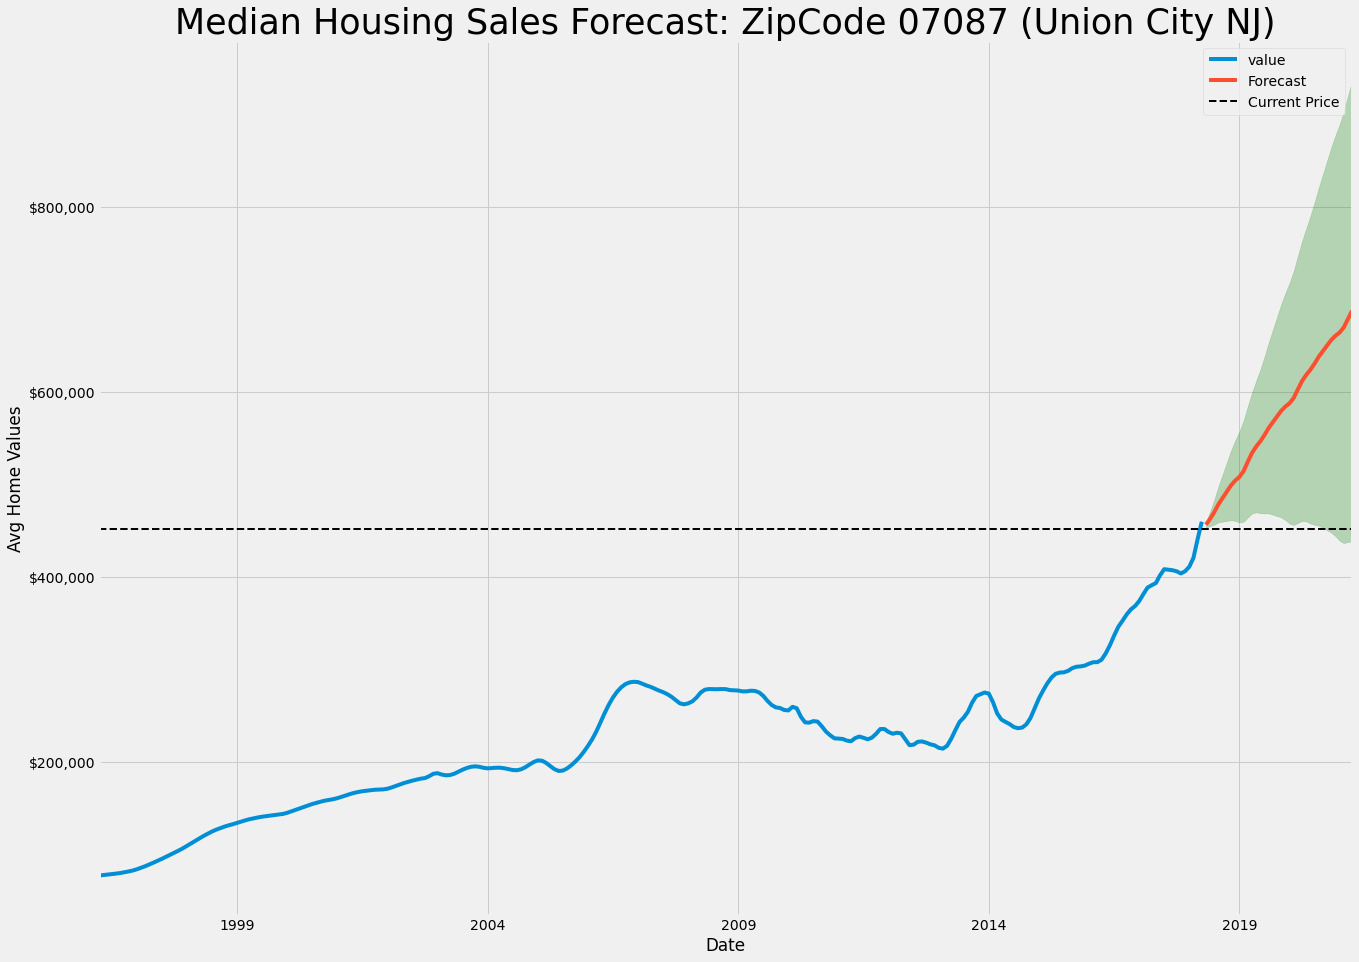

In [298]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_07087_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(452000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 07087 (Union City NJ)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### analysis: 
- minimial losses are in the forecast window, with the potential for high gains.
- RECOMMENDED!

In [237]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   481,223.77
2019-12-31   548,923.26
2020-12-31   626,516.08
2021-12-31   675,178.14
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   458,422.27   504,025.28
2019-12-31   465,659.42   632,187.09
2020-12-31   454,941.94   798,090.22
2021-12-31   438,167.33   912,188.95


## 90304: Inglewood CA

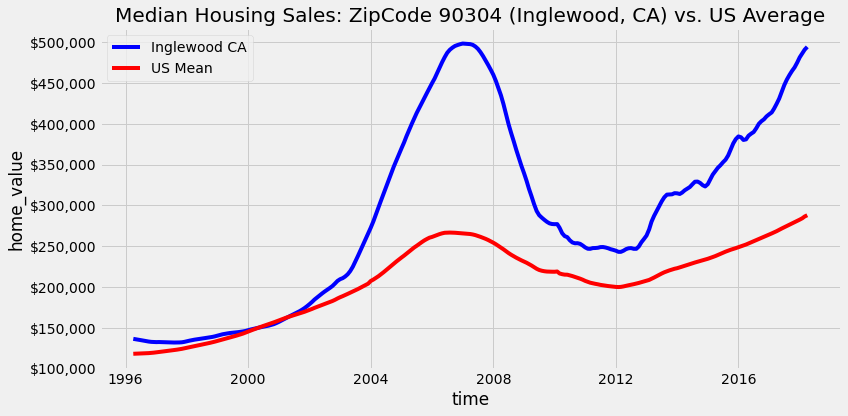

In [238]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_90304_ts, label='Inglewood CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
ax.legend()
ax.set_title("Median Housing Sales: ZipCode 90304 (Inglewood, CA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [239]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_07087_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7415.227089906849


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6925.4380209997125
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 6135.669201303621
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5856.666854278961
SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5702.250772751864


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 5160.833920362519
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4874.863898357607
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 4863.903011142172
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4644.913759647025


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4542.778421440308


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4376.896638348457


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (1, 1, 1, 12)) AIC: 4365.0200172285895


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 4335.310730776255
SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 4277.448410402095


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 4250.331399736548


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((1, 1, 0), (1, 1, 1, 12)) AIC: 4240.024455766166
SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 4225.780631220172


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 4164.91751452935


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4153.772501773967

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [240]:
# Manually split data.
temp_ts = zip_90304_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1673.850
Date:                            Wed, 18 May 2022   AIC                           3357.700
Time:                                    14:57:01   BIC                           3374.141
Sample:                                04-01-1996   HQIC                          3364.355
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9522      0.020     47.986      0.000       0.913       0.991
ma.L1          0.3071      0.026     11.986      0.000       0.257       0.357
ar.S.L12      -0.4492      0.058     -7.784      0.000      -0.562      -0.336
ma.S.L12      -0.0255      0.050     -0.513      0.608      -0.123       0.072
sigma2      1.261e+06   8.38e+04     15.054      0.000     1.1e+06    1.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.06   Jarque-Bera (JB):               113.32
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              10.91   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [241]:
zip_90304_model = sarima_model

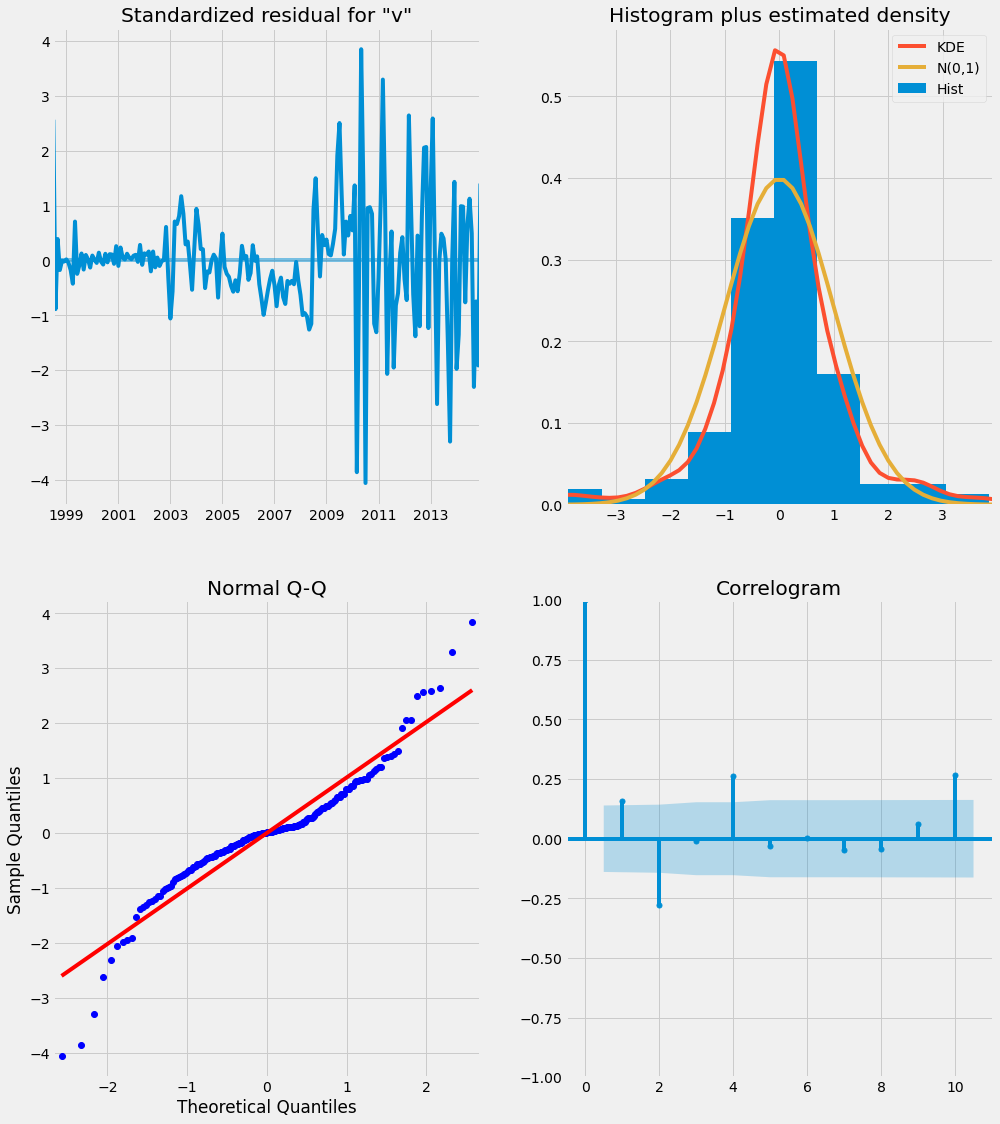

In [242]:
zip_90304_model.plot_diagnostics(figsize=(15, 18))
plt.show()

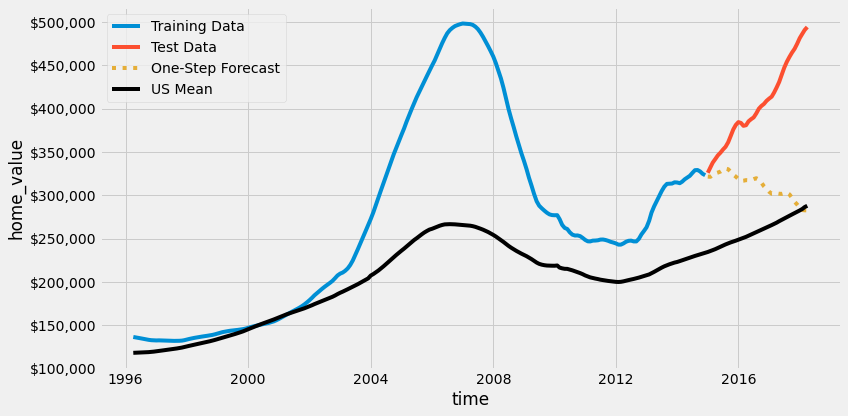

In [243]:
pred = zip_90304_model.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [244]:
pred.conf_int().head()

lower value  upper value
2015-01-01   319,521.24   323,923.81
2015-02-01   316,031.81   326,909.20
2015-03-01   314,228.67   332,940.58
2015-04-01   311,638.65   339,211.89
2015-05-01   307,717.27   344,962.42

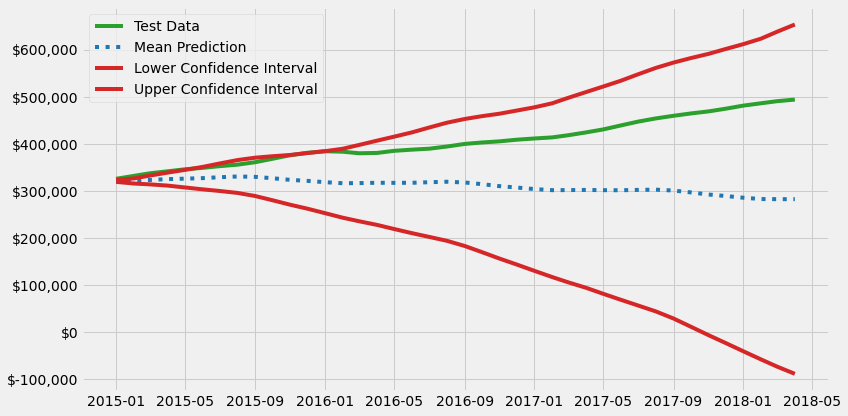

In [245]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

#### Prediction

In [246]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_90304_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2065.138
Date:                            Wed, 18 May 2022   AIC                           4140.276
Time:                                    14:57:03   BIC                           4157.637
Sample:                                04-01-1996   HQIC                          4147.272
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9149      0.031     29.201      0.000       0.853       0.976
ma.L1          0.3350      0.027     12.426      0.000       0.282       0.388
ar.S.L12      -0.4683      0.063     -7.447      0.000      -0.592      -0.345
ma.S.L12      -0.0416      0.038     -1.086      0.277      -0.117       0.033
sigma2      2.319e+06    1.9e+05     12.184      0.000    1.95e+06    2.69e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.10   Jarque-Bera (JB):                46.21
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               8.46   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [247]:
zip_90304_model_full = sarima_model

In [248]:
zip_90304_ts.tail(1)

value
time                 
2018-04-01 494,300.00

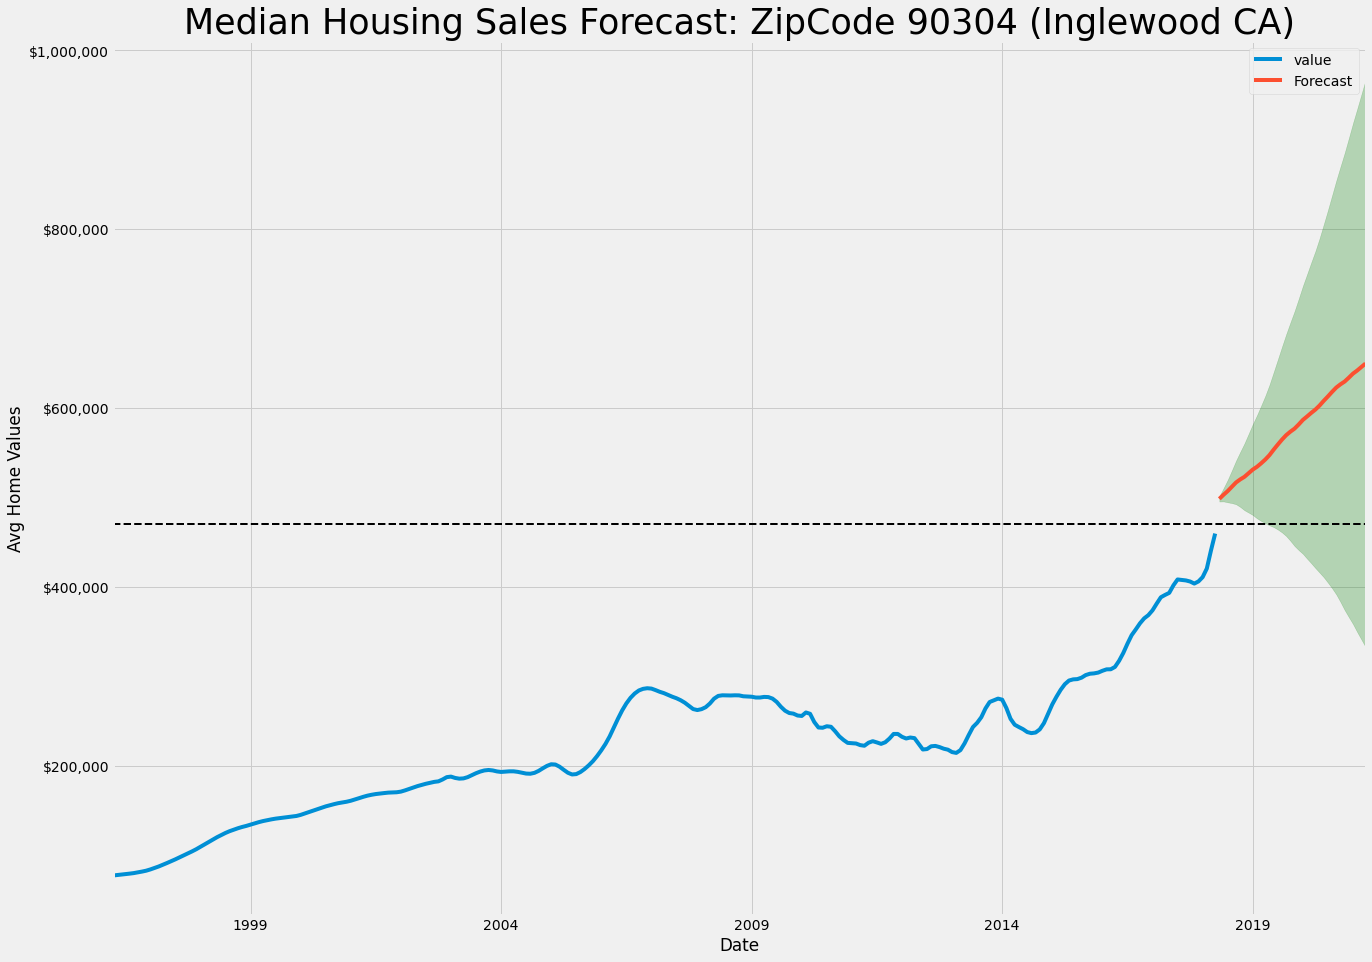

In [249]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_90304_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(470000, ls='--', color='black', linewidth=(2))

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 90304 (Inglewood CA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### Analysis:
- do not recommend during 3 year forecast window that I have been tasked with.
- HOWEVER, I would recommend this as short-term investment (1-2 years) as the forecast window doesn't project losses until year 3.

In [250]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   513,616.27
2019-12-31   556,179.99
2020-12-31   610,556.69
2021-12-31   644,130.96
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   491,455.22   535,777.33
2019-12-31   463,401.02   648,958.96
2020-12-31   405,338.00   815,775.39
2021-12-31   345,834.58   942,427.35


## 95918: Brown's Valley CA

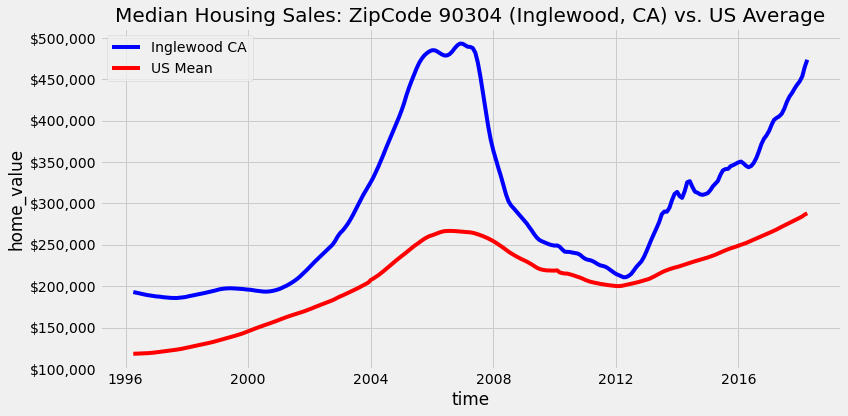

In [251]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_95918_ts, label='Inglewood CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean');
ax.legend()
ax.set_title("Median Housing Sales: ZipCode 90304 (Inglewood, CA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [252]:
# Setting up parameter combinations.
p = d = q = (0, 1)

pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
combo, value = (None, None)
for pdq_combo in pdq:
    for pdqs_combo in pdqs:
        model = SARIMAX(
            zip_07087_ts, 
            order=pdq_combo,
            seasonal_order=pdqs_combo,
            enforce_stationarity=False,
            enforce_invertibility=False
            )
        output = model.fit()

        if value is None or output.aic < value:
            combo, value = ((pdq_combo, pdqs_combo), output.aic)
            print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
            
print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7415.227089906849
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6925.4380209997125
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 6135.669201303621
SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5856.666854278961
SARIMA Combos: ((0, 0, 0), (1, 1, 0, 12)) AIC: 5702.250772751864


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 0, 12)) AIC: 5160.833920362519
SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4874.863898357607
SARIMA Combos: ((0, 1, 0), (0, 1, 0, 12)) AIC: 4863.903011142172
SARIMA Combos: ((0, 1, 0), (0, 1, 1, 12)) AIC: 4644.913759647025


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 0, 1, 12)) AIC: 4542.778421440308


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((0, 1, 1), (0, 1, 1, 12)) AIC: 4376.896638348457


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (1, 1, 1, 12)) AIC: 4365.0200172285895


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (0, 0, 1, 12)) AIC: 4335.310730776255
SARIMA Combos: ((1, 1, 0), (0, 1, 1, 12)) AIC: 4277.448410402095


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 0), (1, 1, 0, 12)) AIC: 4250.331399736548


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((1, 1, 0), (1, 1, 1, 12)) AIC: 4240.024455766166
SARIMA Combos: ((1, 1, 1), (0, 0, 1, 12)) AIC: 4225.780631220172


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 4164.91751452935


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4153.772501773967

********************
Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12))


In [253]:
# Manually split data.
temp_ts = zip_95918_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1763.980
Date:                            Wed, 18 May 2022   AIC                           3537.960
Time:                                    14:57:15   BIC                           3554.402
Sample:                                04-01-1996   HQIC                          3544.615
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8511      0.029     29.292      0.000       0.794       0.908
ma.L1          0.7740      0.029     26.928      0.000       0.718       0.830
ar.S.L12       0.1633      0.053      3.094      0.002       0.060       0.267
ma.S.L12      -0.3715      0.043     -8.544      0.000      -0.457      -0.286
sigma2      3.364e+06   1.97e+05     17.084      0.000    2.98e+06    3.75e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.79   Jarque-Bera (JB):               544.93
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):              14.07   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [254]:
zip_95918_model = sarima_model

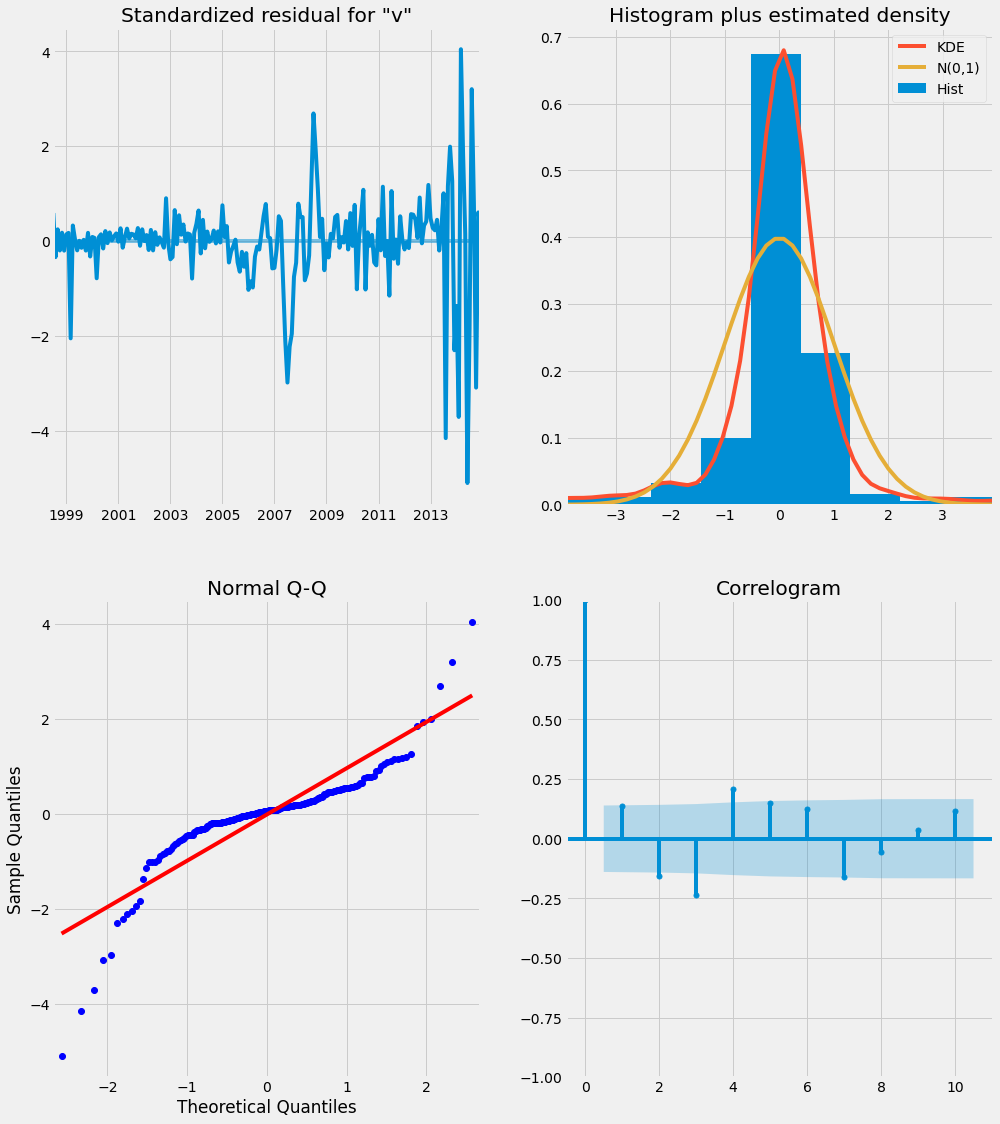

In [255]:
zip_95918_model.plot_diagnostics(figsize=(15, 18))
plt.show()

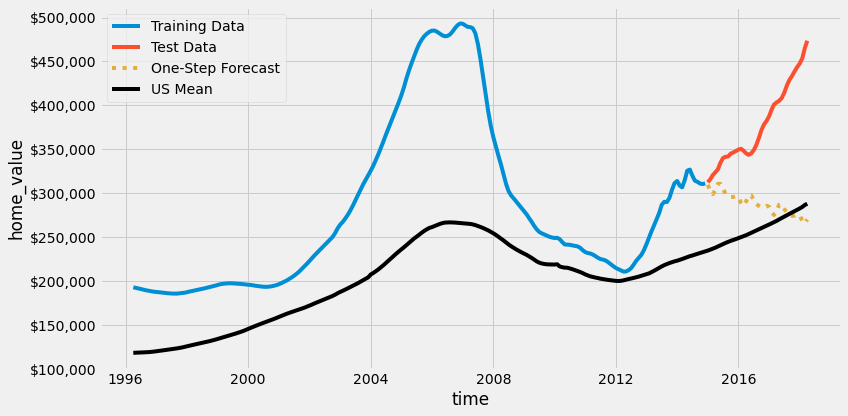

In [256]:
pred = zip_95918_model.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

#### Prediction

In [257]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_95918_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2168.362
Date:                            Wed, 18 May 2022   AIC                           4346.723
Time:                                    14:57:15   BIC                           4364.084
Sample:                                04-01-1996   HQIC                          4353.720
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8646      0.031     28.246      0.000       0.805       0.925
ma.L1          0.3562      0.020     17.419      0.000       0.316       0.396
ar.S.L12      -0.4476      0.051     -8.748      0.000      -0.548      -0.347
ma.S.L12      -0.0353      0.042     -0.845      0.398      -0.117       0.047
sigma2      4.951e+06   2.88e+05     17.197      0.000    4.39e+06    5.52e+06
===================================================================================
Ljung-Box (L1) (Q):                  13.18   Jarque-Bera (JB):               171.00
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.40   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [258]:
zip_95918_model_full = sarima_model

In [259]:
zip_95918_ts.tail(1)

value
time                 
2018-04-01 473,600.00

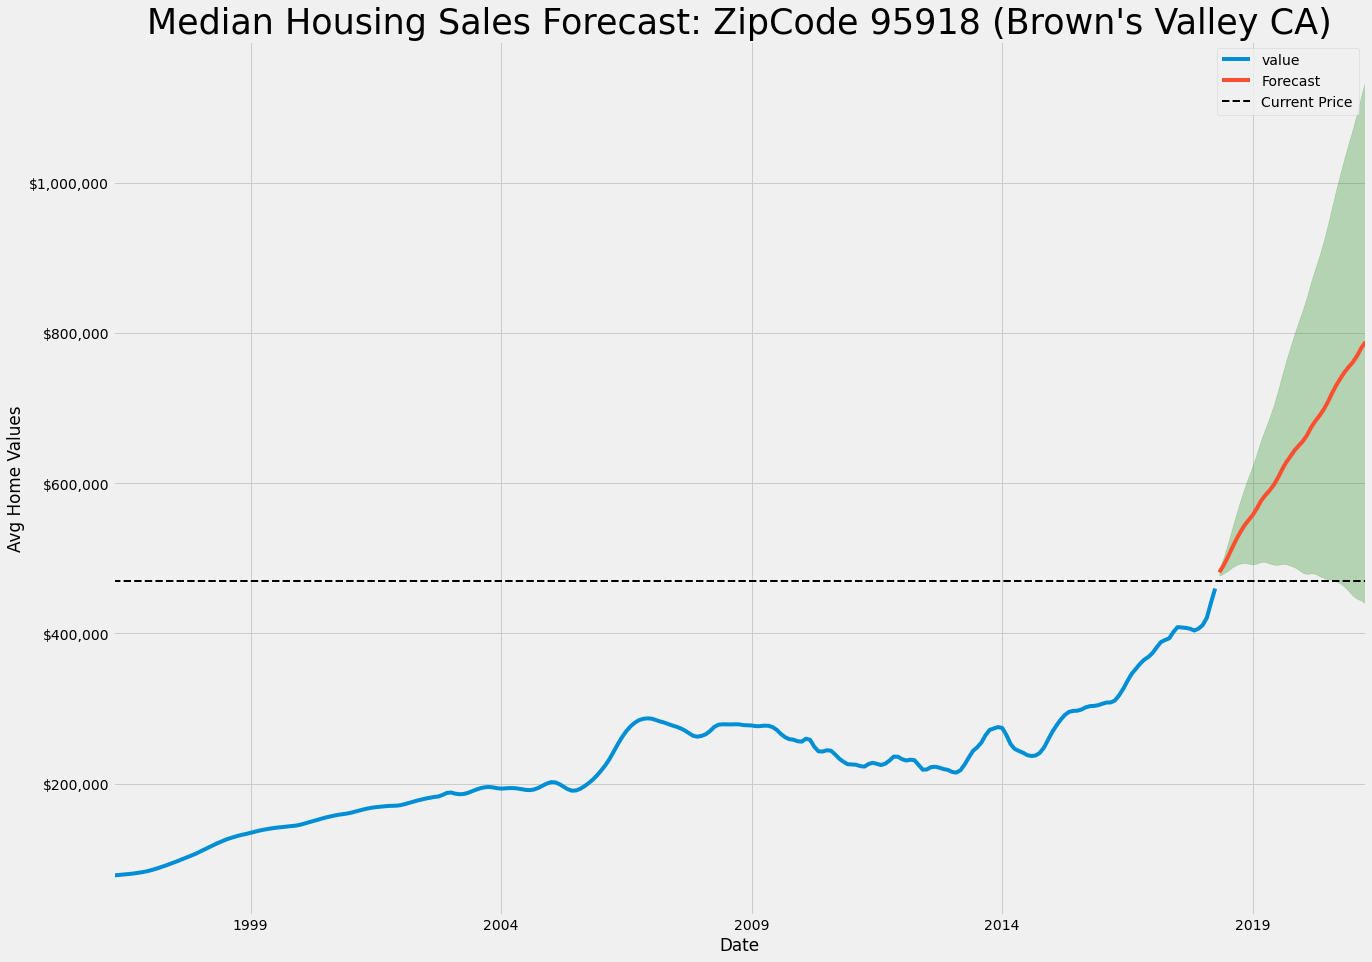

In [292]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_95918_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(470000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 95918 (Brown's Valley CA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### Analysis:
- Minimal forecasted loss, high potential for gains.
- confidence window for year 1 is very narrow, potential losses wouldn't occur until year 3.
- RECOMMENDED!

In [261]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   517,519.57
2019-12-31   604,653.76
2020-12-31   705,750.67
2021-12-31   775,043.95
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   487,398.10   547,641.03
2019-12-31   491,687.09   717,620.44
2020-12-31   472,394.89   939,106.45
2021-12-31   444,921.54 1,105,166.37


# Final Analysis DF

In [262]:
final_df = target_zips.sort_values('ROI', ascending=False).head(11)

In [269]:
rec_1_df = final_df.copy()

In [290]:
junk = rec_1_df.head(3)

# Recommendations

## Recommendation #1: Top 5 ZipCodes to Invest in:
- 1. 37046 College Grove TN
- 2. 98043 Mountlake Terrace WA
- 3. 02121 Boston MA
- 4. 95918 Browns Valley CA
- 5. 07087 Union City NJ </b>

These ZipCodes completely meet the criteria that I was given:
- Cost of Entry: Average Home Values around 500,000.
- Geographic Diversity: Each is in a different State.
- High ROI: Each is forecasted to have a high return on investment over the next 3 years.
- Low Risk: Each has been forecast with a low risk of losing money over the next 3 years.
- Timing: All forecasts were for 3 years.

## Recommendation #2: ZipCodes for Shorter investment


ZipCodes that showed a good return with low risk for 1 or 2 years.

## Recommendation #3